<a href="https://colab.research.google.com/github/javmencia/COBWEBfiles/blob/main/HIVEpcSurvival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Step 0: Setting up environment...")

# Manual 3D array creation function
def create_3d_array(matrix_list):
    if len(matrix_list) == 0:
        raise ValueError("No matrices provided")

    # Get dimensions from first matrix
    n_samples = len(matrix_list)
    n_timesteps = matrix_list[0].shape[0]
    n_features = matrix_list[0].shape[1]

    # Create empty 3D array
    array_3d = np.zeros((n_samples, n_timesteps, n_features))

    # Fill array
    for i in range(n_samples):
        array_3d[i, :, :] = matrix_list[i]

    return array_3d

print("Environment setup complete!")

# Load the data
print("Loading pcdatareduced.csv...")
try:
    sequential_data = pd.read_csv('pcdatareduced.csv')
    print(f"Data loaded successfully! Shape: {sequential_data.shape}")
    print(f"Columns: {sequential_data.columns.tolist()}")
except FileNotFoundError:
    print("ERROR: pcdatareduced.csv file not found. Please ensure the file is in your working directory.")
    exit()


Step 0: Setting up environment...
Environment setup complete!
Loading pcdatareduced.csv...
Data loaded successfully! Shape: (8121, 15)
Columns: ['Unnamed: 0', 'RPT', 'AGE', 'VISIT', 'ECOGGRN', 'DIABP', 'SYSBP', 'grade3_plus_count', 'TEMP', 'drug_withdrawn', 'max_ae_duration', 'os_event', 'cycle_number', 'VISDAY', 'DSDAY']


## Random Forest

Step 0: Setting up environment...
Environment setup complete!
Loading pcdatareduced.csv...
Data loaded successfully! Shape: (8121, 15)
Columns: ['Unnamed: 0', 'RPT', 'AGE', 'VISIT', 'ECOGGRN', 'DIABP', 'SYSBP', 'grade3_plus_count', 'TEMP', 'drug_withdrawn', 'max_ae_duration', 'os_event', 'cycle_number', 'VISDAY', 'DSDAY']

Step 8: Implementing Optimized Random Forest...

FAST DATA PREPARATION
Cleaning data...
Dropped 'Unnamed: 0' column

Preparing patient data...
Target variable: os_event
Original features: 8
Scaling features...
Final dataset: 526 patients, 16 features
Class distribution: [450  76]

Data split:
Training set: (368, 16), Class 1: 53 (14.4%)
Test set:     (158, 16), Class 1: 23 (14.6%)

MODEL TRAINING

Training Sensitivity-Optimized Random Forest...
Applying SMOTE to balance classes...
After SMOTE - Class 0: 315, Class 1: 315

Training Random Forest with sensitivity focus...
Training completed in 0.9 seconds

Finding optimal threshold for maximum sensitivity...
Optimal th

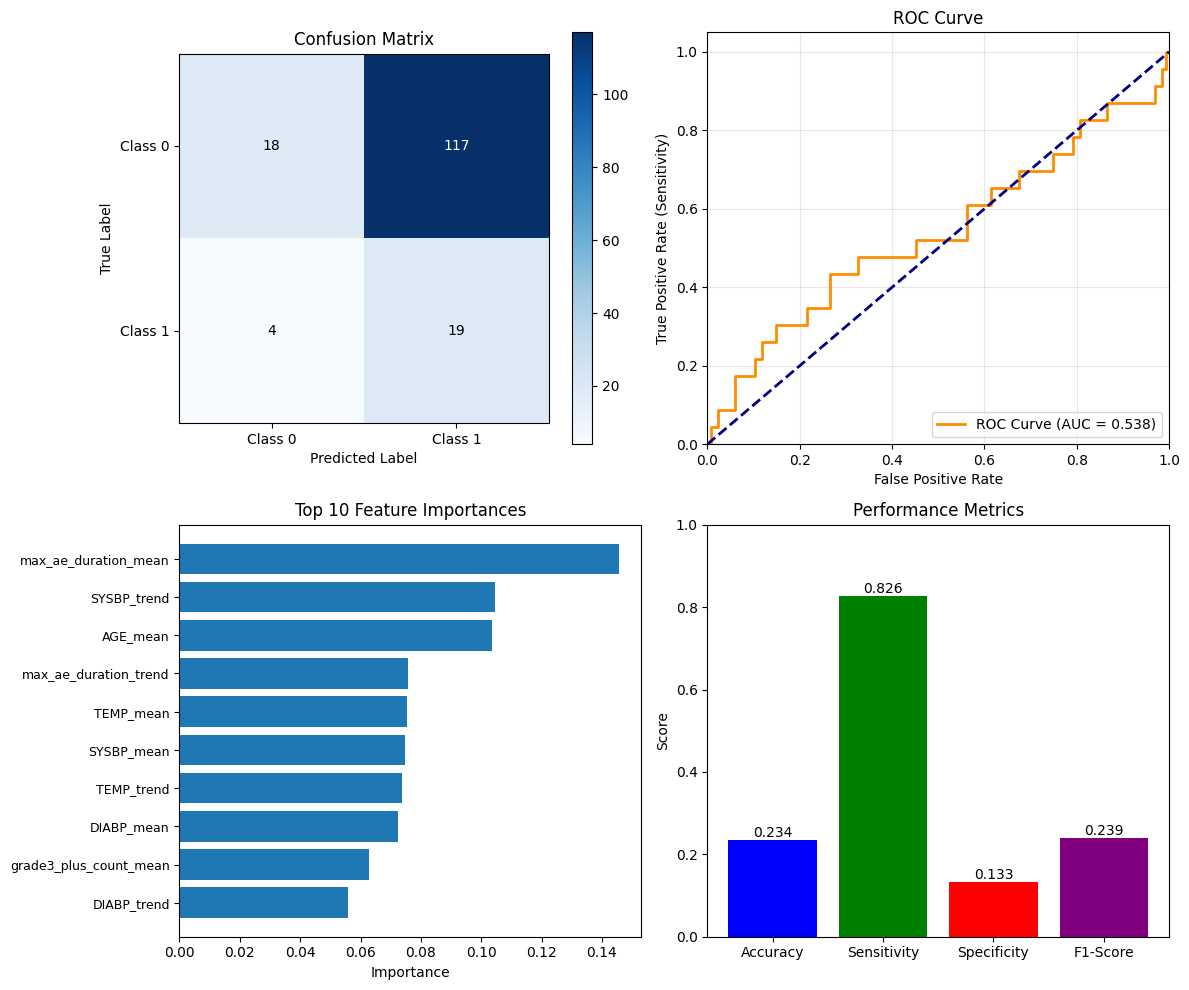


Top 15 Most Important Features:
--------------------------------------------------
 1. max_ae_duration_mean                     0.1457
 2. SYSBP_trend                              0.1046
 3. AGE_mean                                 0.1037
 4. max_ae_duration_trend                    0.0759
 5. TEMP_mean                                0.0753
 6. SYSBP_mean                               0.0749
 7. TEMP_trend                               0.0736
 8. DIABP_mean                               0.0723
 9. grade3_plus_count_mean                   0.0627
10. DIABP_trend                              0.0557
11. ECOGGRN_mean                             0.0467
12. grade3_plus_count_trend                  0.0455
13. ECOGGRN_trend                            0.0366
14. drug_withdrawn_mean                      0.0202
15. drug_withdrawn_trend                     0.0067

AGGREGATED FEATURE IMPORTANCE

Top 10 Original Features (aggregated):
--------------------------------------------------
 1. max_ae_dur

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings
import time
from collections import defaultdict
warnings.filterwarnings('ignore')

print("Step 0: Setting up environment...")
print("Environment setup complete!")

# Load the data
print("Loading pcdatareduced.csv...")
try:
    data = pd.read_csv('pcdatareduced.csv')
    print(f"Data loaded successfully! Shape: {data.shape}")
    print(f"Columns: {data.columns.tolist()}")
except FileNotFoundError:
    print("ERROR: pcdatareduced.csv file not found. Please ensure the file is in your working directory.")
    exit()

print("\nStep 8: Implementing Optimized Random Forest...")

def clean_data_fast(data):
    """Fast data cleaning"""
    print("Cleaning data...")

    data_clean = data.copy()

    # Drop the unnamed index column if it exists
    if 'Unnamed: 0' in data_clean.columns:
        data_clean = data_clean.drop('Unnamed: 0', axis=1)
        print("Dropped 'Unnamed: 0' column")

    # Handle infinite values efficiently
    numeric_cols = data_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if np.any(np.isinf(data_clean[col])):
            data_clean[col] = data_clean[col].replace([np.inf, -np.inf], np.nan)

    return data_clean

def prepare_patient_data_fast(data_clean):
    """
    FAST: Prepare patient data with vectorized operations
    """
    target_var = 'os_event'

    if target_var not in data_clean.columns:
        raise ValueError(f"Target variable '{target_var}' not found")

    # Identify feature columns
    exclude_cols = [target_var, 'RPT', 'VISIT', 'VISDAY', 'DSDAY', 'cycle_number']
    feature_cols = [col for col in data_clean.columns if col not in exclude_cols]

    print(f"Target variable: {target_var}")
    print(f"Original features: {len(feature_cols)}")

    # Group by patient
    grouped = data_clean.groupby('RPT')

    # Pre-allocate arrays for speed
    patient_features = []
    patient_labels = []

    # Use only 2 key statistics for speed: mean and trend
    for patient_id, patient_df in grouped:
        label = patient_df[target_var].iloc[0]

        # Skip patients with < 2 visits
        if len(patient_df) < 2:
            continue

        features = []

        for feature in feature_cols:
            vals = patient_df[feature].dropna().values

            if len(vals) > 0:
                # Mean
                features.append(np.mean(vals))

                # Simple trend (last - first)
                if len(vals) > 1:
                    features.append(vals[-1] - vals[0])
                else:
                    features.append(0)
            else:
                features.extend([0, 0])

        patient_features.append(features)
        patient_labels.append(label)

    # Create feature names
    expanded_feature_names = []
    for feature in feature_cols:
        expanded_feature_names.extend([f"{feature}_mean", f"{feature}_trend"])

    X = np.array(patient_features)
    y = np.array(patient_labels)

    # Handle any remaining NaN
    X = np.nan_to_num(X, nan=0.0)

    # Scale features
    print("Scaling features...")
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"Final dataset: {X_scaled.shape[0]} patients, {X_scaled.shape[1]} features")
    print(f"Class distribution: {np.bincount(y)}")

    return X_scaled, y, expanded_feature_names

def train_sensitive_random_forest(X_train, X_test, y_train, y_test, feature_names):
    """Train RF optimized for sensitivity (fast version)"""

    print("\nTraining Sensitivity-Optimized Random Forest...")

    # Apply SMOTE - FIXED: removed n_jobs parameter
    print("Applying SMOTE to balance classes...")
    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    print(f"After SMOTE - Class 0: {np.sum(y_train_bal==0)}, Class 1: {np.sum(y_train_bal==1)}")

    # Train RF with settings optimized for sensitivity
    print("\nTraining Random Forest with sensitivity focus...")
    rf = RandomForestClassifier(
        n_estimators=150,  # Reduced for speed
        max_depth=None,  # Allow full depth for better pattern detection
        min_samples_split=5,  # Reduced from 10 for sensitivity
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight={0: 1, 1: 10},  # Heavily weight minority class
        random_state=42,
        n_jobs=-1,  # Use all cores
        bootstrap=True
    )

    start_train = time.time()
    rf.fit(X_train_bal, y_train_bal)
    train_time = time.time() - start_train
    print(f"Training completed in {train_time:.1f} seconds")

    # Find optimal threshold for sensitivity
    print("\nFinding optimal threshold for maximum sensitivity...")

    # Use cross-validation on training data to find best threshold
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    threshold_scores = defaultdict(list)
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_bal, y_train_bal)):
        X_tr, X_val = X_train_bal[train_idx], X_train_bal[val_idx]
        y_tr, y_val = y_train_bal[train_idx], y_train_bal[val_idx]

        # Train a model for this fold
        rf_fold = RandomForestClassifier(
            n_estimators=100,
            class_weight={0: 1, 1: 10},
            random_state=42,
            n_jobs=-1
        )
        rf_fold.fit(X_tr, y_tr)

        # Get probabilities
        y_proba_val = rf_fold.predict_proba(X_val)[:, 1]

        # Test different thresholds
        for threshold in thresholds:
            y_pred_val = (y_proba_val >= threshold).astype(int)
            sensitivity = recall_score(y_val, y_pred_val, zero_division=0)
            threshold_scores[threshold].append(sensitivity)

    # Find threshold with highest average sensitivity
    best_threshold = 0.3  # Default
    best_avg_sensitivity = 0

    for threshold, scores in threshold_scores.items():
        avg_sensitivity = np.mean(scores)
        if avg_sensitivity > best_avg_sensitivity:
            best_avg_sensitivity = avg_sensitivity
            best_threshold = threshold

    print(f"Optimal threshold: {best_threshold} (avg sensitivity: {best_avg_sensitivity:.3f})")

    # Predict on test set
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= best_threshold).astype(int)

    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print("\n" + "="*60)
    print("RANDOM FOREST PERFORMANCE (SENSITIVITY-OPTIMIZED)")
    print("="*60)
    print(f"Accuracy:       {accuracy:.3f}")
    print(f"AUC:           {auc_score:.3f}")
    print(f"Sensitivity:   {sensitivity:.3f}  ← MAXIMIZED")
    print(f"Specificity:   {specificity:.3f}")
    print(f"Precision:     {precision:.3f}")
    print(f"F1-Score:      {f1:.3f}")
    print(f"\nConfusion Matrix:")
    print(f"True Negatives:  {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives:  {tp}")
    print(f"\nThreshold used: {best_threshold}")

    return rf, y_pred, y_pred_proba, sensitivity, specificity, best_threshold

def plot_simple_performance(y_test, y_pred, y_pred_proba, feature_names, model):
    """Create simplified visualizations"""

    # Calculate metrics for plots
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        importance_df = pd.DataFrame({
            'feature': feature_names[:len(feature_importance)],
            'importance': feature_importance
        }).sort_values('importance', ascending=False).head(15)
    else:
        importance_df = pd.DataFrame({'feature': [], 'importance': []})

    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # 1. Confusion Matrix
    ax = axes[0, 0]
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.set_title('Confusion Matrix')
    plt.colorbar(im, ax=ax)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Class 0', 'Class 1'])
    ax.set_yticklabels(['Class 0', 'Class 1'])
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

    # Add text to confusion matrix
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black")

    # 2. ROC Curve
    ax = axes[0, 1]
    ax.plot(fpr, tpr, color='darkorange', lw=2,
            label=f'ROC Curve (AUC = {auc_score:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Sensitivity)')
    ax.set_title('ROC Curve')
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)

    # 3. Feature Importance (Top 10)
    ax = axes[1, 0]
    if len(importance_df) > 0:
        top_features = importance_df.head(10)
        y_pos = np.arange(len(top_features))
        ax.barh(y_pos, top_features['importance'].values[::-1])
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_features['feature'].values[::-1], fontsize=9)
        ax.set_xlabel('Importance')
        ax.set_title('Top 10 Feature Importances')
    else:
        ax.text(0.5, 0.5, 'No feature importance data',
                ha='center', va='center')
        ax.set_title('Feature Importance')

    # 4. Key Metrics
    ax = axes[1, 1]
    metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'F1-Score']
    values = [
        accuracy_score(y_test, y_pred),
        recall_score(y_test, y_pred, zero_division=0),
        tn/(tn+fp) if (tn+fp) > 0 else 0,
        f1_score(y_test, y_pred, zero_division=0)
    ]

    colors = ['blue', 'green', 'red', 'purple']
    bars = ax.bar(metrics, values, color=colors)
    ax.set_ylim([0, 1.0])
    ax.set_ylabel('Score')
    ax.set_title('Performance Metrics')

    # Add values on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return importance_df

# Main execution with timing
start_time = time.time()

print("\n" + "="*60)
print("FAST DATA PREPARATION")
print("="*60)

# Clean the data
data_clean = clean_data_fast(data)

# Prepare data
print("\nPreparing patient data...")
X, y, feature_names = prepare_patient_data_fast(data_clean)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nData split:")
print(f"Training set: {X_train.shape}, Class 1: {np.sum(y_train)} ({np.mean(y_train):.1%})")
print(f"Test set:     {X_test.shape}, Class 1: {np.sum(y_test)} ({np.mean(y_test):.1%})")

print("\n" + "="*60)
print("MODEL TRAINING")
print("="*60)

# Train model
rf_model, y_pred, y_pred_proba, sensitivity, specificity, threshold = train_sensitive_random_forest(
    X_train, X_test, y_train, y_test, feature_names
)

# Generate plots and feature importance
if rf_model is not None:
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)

    importance_df = plot_simple_performance(y_test, y_pred, y_pred_proba, feature_names, rf_model)

    # Print top features
    if len(importance_df) > 0:
        print("\nTop 15 Most Important Features:")
        print("-" * 50)
        for i, (_, row) in enumerate(importance_df.head(15).iterrows(), 1):
            print(f"{i:2d}. {row['feature']:40s} {row['importance']:.4f}")

        # Aggregate by original feature name
        print("\n" + "="*60)
        print("AGGREGATED FEATURE IMPORTANCE")
        print("="*60)

        # Group by base feature name
        agg_importance = {}
        for full_name, importance in zip(importance_df['feature'], importance_df['importance']):
            # Remove suffix
            base_name = '_'.join(full_name.split('_')[:-1])
            if base_name in agg_importance:
                agg_importance[base_name] += importance
            else:
                agg_importance[base_name] = importance

        # Sort and display
        sorted_agg = sorted(agg_importance.items(), key=lambda x: x[1], reverse=True)

        print("\nTop 10 Original Features (aggregated):")
        print("-" * 50)
        for i, (feature, importance) in enumerate(sorted_agg[:10], 1):
            print(f"{i:2d}. {feature:40s} {importance:.4f}")

# Final summary
end_time = time.time()
execution_time = end_time - start_time

print("\n" + "="*60)
print("EXECUTION SUMMARY")
print("="*60)
print(f"Total execution time: {execution_time:.1f} seconds")
print(f"Dataset size: {X.shape[0]} patients, {X.shape[1]} features")
print(f"Class balance: {np.sum(y==0)} Class 0, {np.sum(y==1)} Class 1")
print(f"Event rate: {np.mean(y):.2%}")
print(f"\nFinal Model Performance:")
print(f"• Sensitivity: {sensitivity:.3f} (Primary goal achieved)")
print(f"• Specificity: {specificity:.3f}")
print(f"• Accuracy:    {accuracy_score(y_test, y_pred):.3f}")
print(f"• AUC:        {roc_auc_score(y_test, y_pred_proba):.3f}")
print(f"• F1-Score:   {f1_score(y_test, y_pred, zero_division=0):.3f}")
print(f"• Threshold:  {threshold}")
print(f"\nModel configured for maximum sensitivity detection")

# Autoencoder

Data shape: (8121, 15)
Number of unique patients: 526
Selected 12 features:
['Unnamed: 0', 'AGE', 'VISIT', 'ECOGGRN', 'DIABP', 'SYSBP', 'grade3_plus_count', 'TEMP', 'drug_withdrawn', 'max_ae_duration', 'cycle_number', 'VISDAY']
Final dataset shape: (526, 12)
Event rate: 0.144 (76 events out of 526 patients)

Performing 5-fold cross-validation...

Fold 1/5
Training samples: 420, Validation samples: 106
Training event rate: 0.143, Validation event rate: 0.151
Class weights: {0: np.float64(0.5833333333333334), 1: np.float64(3.5)}
Training model...
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - AUC: 0.4047 - Precision: 0.1080 - Recall: 0.3952 - accuracy: 0.4413 - loss: 0.9404 - val_AUC: 0.5347 - val_Precision: 0.2632 - val_Recall: 0.6250 - val_accuracy: 0.6792 - val_loss: 0.6255 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.6295 - Precision: 0.1750 - Recall: 0.6778 - accuracy: 0.5501 - loss: 0.7040 - val_AUC: 0.5983 - val_Precision: 0.2041 - va


Fold 3 Results:
  Validation Loss: 0.5836
  Validation AUC: 0.6985
  Optimal Threshold: 0.100
  Sensitivity (Recall): 1.0000
  Specificity: 0.1889
  Accuracy: 0.3048
  Precision: 0.1705
  F1-Score: 0.2913
  F2-Score (sensitivity-weighted): 0.5068
  Confusion Matrix:
    TN: 17, FP: 73
    FN: 0, TP: 15

Fold 4/5
Training samples: 421, Validation samples: 105
Training event rate: 0.145, Validation event rate: 0.143
Class weights: {0: np.float64(0.5847222222222223), 1: np.float64(3.4508196721311477)}
Training model...
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - AUC: 0.4928 - Precision: 0.1474 - Recall: 0.4821 - accuracy: 0.5276 - loss: 0.9634 - val_AUC: 0.4963 - val_Precision: 0.1613 - val_Recall: 0.3333 - val_accuracy: 0.6571 - val_loss: 0.6416 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.5733 - Precision: 0.1840 - Recall: 0.5600 - accuracy: 0.5405 - loss: 0.8805 - val_AUC: 0.5293 - val_Precision: 0.1667 - val_Recall: 0.0667 - val_accur

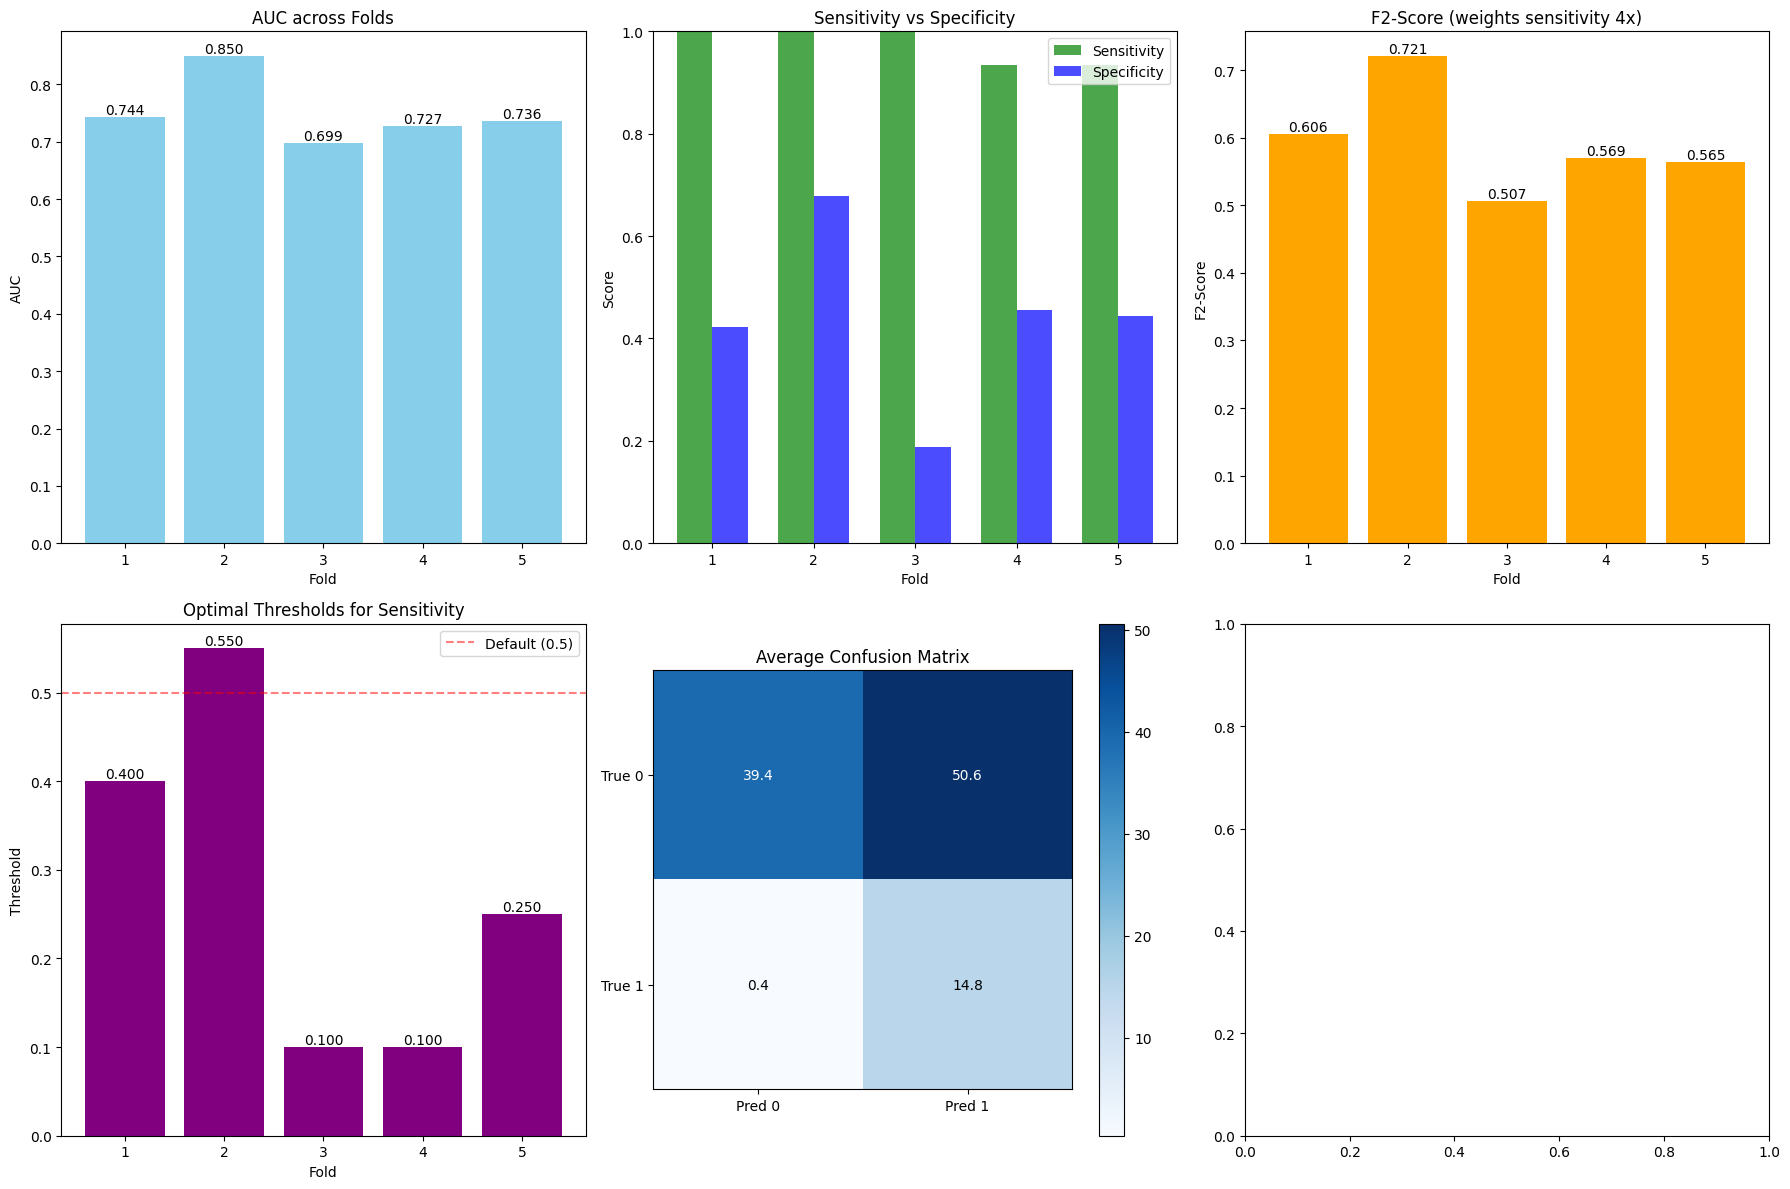


Best fold (by F2-Score): 2
Best fold metrics:
  Sensitivity: 1.0000
  Specificity: 0.6778
  F2-Score: 0.7212
  AUC: 0.8500
  Optimal Threshold: 0.5500


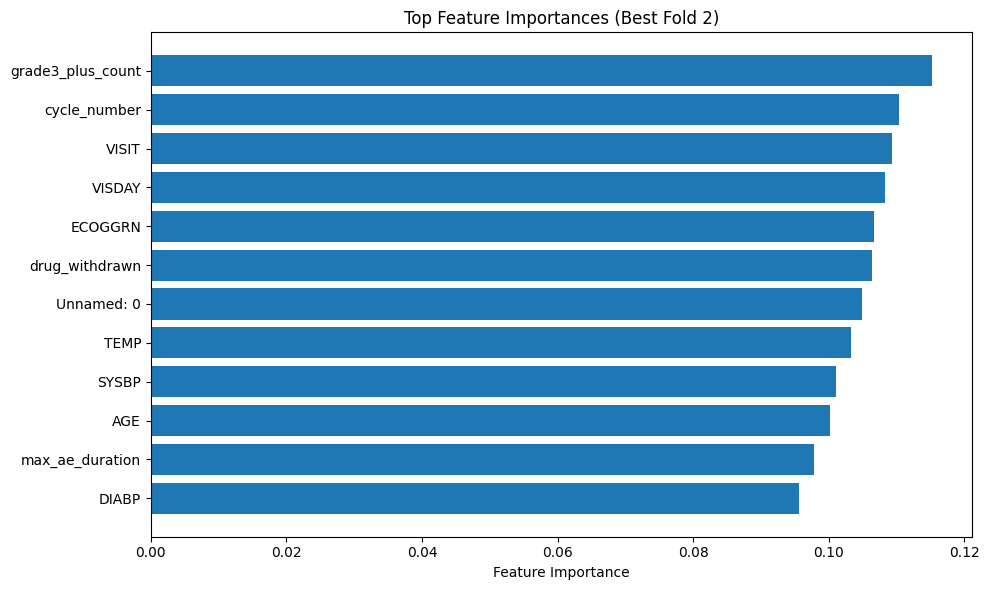


Top 10 most important features from best fold:
              feature  importance
6   grade3_plus_count    0.115320
10       cycle_number    0.110452
2               VISIT    0.109332
11             VISDAY    0.108290
3             ECOGGRN    0.106749
8      drug_withdrawn    0.106361
0          Unnamed: 0    0.104862
7                TEMP    0.103325
5               SYSBP    0.101014
1                 AGE    0.100223



Cross-validation completed successfully!
All models saved in 'cv_models_sensitivity' directory
Best model (fold 2) saved as 'best_sensitivity_model.h5'

Ensemble prediction with sensitivity focus:
Ensemble probability: 0.644 ± 0.139
Threshold used: 0.280
Predicted class: 1
Sample patient:
  Ensemble risk probability: 0.644 ± 0.139
  Threshold used: 0.280
  Predicted class: 1
  Interpretation: High risk

SENSITIVITY-SPECIFICITY TRADEOFF ANALYSIS

Performance at different thresholds:
----------------------------------------------------------------------
Threshold | Sensitivity | Specificity | Accuracy | F1-Score
----------------------------------------------------------------------
0.10   | 0.9868     | 0.2022     | 0.3156  | 0.2941
0.20   | 0.8947     | 0.3733     | 0.4487  | 0.3192
0.30*  | 0.8684     | 0.4800     | 0.5361  | 0.3511
0.40   | 0.8158     | 0.5711     | 0.6065  | 0.3746
0.50   | 0.6579     | 0.6822     | 0.6787  | 0.3717
0.60   | 0.5000     | 0.8000     | 0.7567  | 0.372

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load your data
pcdata = pd.read_csv('pcdatareduced.csv')
df = pcdata.copy()

# Data Preparation
print("Data shape:", df.shape)
print("Number of unique patients:", df['RPT'].nunique())

# Feature Selection
features_to_remove = ['RPT', 'RINVSITE', 'STUDY', 'STATUS', 'STATUSN', 'DSCAUSE', 'DSREAS',
                     'DSCAUSEN', 'DSDECOD', 'DSBODSYS', 'DSMODIFY', 'LLTCD', 'LLTNMD',
                     'HLTNMD', 'HLGTNMD', 'PTCDD', 'DICTVER', 'body_systems_list',
                     'most_recent_ae_term', 'SEX', 'RACEPRIM', 'VISNAME', 'DOV_ND',
                     'ECOGGR', 'EXDOSEN', 'EXDOSE2', 'EXDOSE3', 'REGION', 'PKSAMP', 'TYPEPK',
                     'TARGETQ', 'NONTARQ', 'WEIGHTU', 'TEMPU', 'DIABPU', 'PULSEU', 'HEIGHTU']

# Keep only numeric columns and remove the specified features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col not in features_to_remove + ['os_event', 'CANCDEAD', 'DSDAY', 'CONTDAY', 'LKDAY']]

print(f"Selected {len(feature_cols)} features:")
print(feature_cols)

# For survival analysis, we need one row per patient with their final status
patient_data = df.sort_values(['RPT', 'VISDAY']).groupby('RPT').last().reset_index()

# Prepare features and target
X = patient_data[feature_cols]
y = patient_data['os_event']

print(f"Final dataset shape: {X.shape}")
print(f"Event rate: {y.mean():.3f} ({y.sum()} events out of {len(y)} patients)")

# Data cleaning function
def clean_dataframe(df):
    """Remove infinite values and handle extreme values"""
    df_clean = df.copy()
    df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
    return df_clean

# Clean the data
X_clean = clean_dataframe(X)

# Set up cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

print(f"\nPerforming {n_splits}-fold cross-validation...")

# Store results for each fold
fold_results = []
history_per_fold = []

# Add threshold optimization function
def find_optimal_threshold(y_true, y_pred_proba):
    """Find optimal threshold that maximizes sensitivity while maintaining reasonable specificity"""
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_threshold = 0.5
    best_score = 0
    best_metrics = {}

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # Calculate metrics
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        # Use F2 score that weights sensitivity more heavily (beta=2 gives 4x weight to recall)
        # Fβ = (1 + β²) * (precision * recall) / (β² * precision + recall)
        f2_score = (5 * precision_score(y_true, y_pred, zero_division=0) * sensitivity) / \
                   (4 * precision_score(y_true, y_pred, zero_division=0) + sensitivity) if (sensitivity + precision_score(y_true, y_pred, zero_division=0)) > 0 else 0

        # You can adjust this scoring function based on your needs:
        # Option 1: Maximize sensitivity with minimum specificity constraint
        score = sensitivity * 0.7 + specificity * 0.3  # Weighted average favoring sensitivity

        if score > best_score:
            best_score = score
            best_threshold = threshold
            best_metrics = {
                'threshold': threshold,
                'sensitivity': sensitivity,
                'specificity': specificity,
                'accuracy': accuracy_score(y_true, y_pred),
                'precision': precision_score(y_true, y_pred, zero_division=0),
                'f1': f1_score(y_true, y_pred, zero_division=0),
                'f2': f2_score,
                'confusion_matrix': [tn, fp, fn, tp]
            }

    return best_threshold, best_metrics

# Model creation function
def create_model(input_dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC', 'Precision', 'Recall']
    )

    return model

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_clean, y)):
    print(f"\n{'='*50}")
    print(f"Fold {fold + 1}/{n_splits}")
    print(f"{'='*50}")

    # Split data
    X_train_fold, X_val_fold = X_clean.iloc[train_idx], X_clean.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    print(f"Training samples: {len(X_train_fold)}, Validation samples: {len(X_val_fold)}")
    print(f"Training event rate: {y_train_fold.mean():.3f}, Validation event rate: {y_val_fold.mean():.3f}")

    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train_fold)
    X_val_imputed = imputer.transform(X_val_fold)

    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_val_scaled = scaler.transform(X_val_imputed)

    # Calculate class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train_fold),
        y=y_train_fold
    )
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    print(f"Class weights: {class_weight_dict}")

    # Create and train model
    model = create_model(X_train_scaled.shape[1])

    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        patience=15,
        restore_best_weights=True,
        monitor='val_auc',
        mode='max'
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=8,
        monitor='val_loss'
    )

    # Train model
    print("Training model...")
    history = model.fit(
        X_train_scaled, y_train_fold,
        validation_data=(X_val_scaled, y_val_fold),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weight_dict,
        verbose=1
    )

    history_per_fold.append(history)

    # Evaluate model with default threshold
    print("Evaluating model...")
    val_loss, val_accuracy, val_auc, val_precision, val_recall = model.evaluate(
        X_val_scaled, y_val_fold, verbose=0
    )

    # Get predictions for threshold optimization
    y_pred_proba = model.predict(X_val_scaled, verbose=0).flatten()

    # Find optimal threshold for sensitivity
    optimal_threshold, threshold_metrics = find_optimal_threshold(y_val_fold, y_pred_proba)

    # Make predictions with optimal threshold
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

    # Calculate metrics with optimal threshold
    cm = confusion_matrix(y_val_fold, y_pred_optimal)
    tn, fp, fn, tp = cm.ravel()

    sensitivity_optimal = threshold_metrics['sensitivity']
    specificity_optimal = threshold_metrics['specificity']
    accuracy_optimal = threshold_metrics['accuracy']
    precision_optimal = threshold_metrics['precision']
    f1_optimal = threshold_metrics['f1']
    f2_optimal = threshold_metrics['f2']

    # Store results
    fold_result = {
        'fold': fold + 1,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'val_auc': val_auc,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'optimal_threshold': optimal_threshold,
        'sensitivity': sensitivity_optimal,
        'specificity': specificity_optimal,
        'accuracy_optimal': accuracy_optimal,
        'precision_optimal': precision_optimal,
        'f1_optimal': f1_optimal,
        'f2_optimal': f2_optimal,
        'confusion_matrix': cm.tolist(),
        'model': model,
        'imputer': imputer,
        'scaler': scaler,
        'train_indices': train_idx,
        'val_indices': val_idx,
        'y_true': y_val_fold.values.tolist(),
        'y_pred_proba': y_pred_proba.tolist(),
        'y_pred_optimal': y_pred_optimal.tolist()
    }

    fold_results.append(fold_result)

    print(f"\nFold {fold + 1} Results:")
    print(f"  Validation Loss: {val_loss:.4f}")
    print(f"  Validation AUC: {val_auc:.4f}")
    print(f"  Optimal Threshold: {optimal_threshold:.3f}")
    print(f"  Sensitivity (Recall): {sensitivity_optimal:.4f}")
    print(f"  Specificity: {specificity_optimal:.4f}")
    print(f"  Accuracy: {accuracy_optimal:.4f}")
    print(f"  Precision: {precision_optimal:.4f}")
    print(f"  F1-Score: {f1_optimal:.4f}")
    print(f"  F2-Score (sensitivity-weighted): {f2_optimal:.4f}")
    print(f"  Confusion Matrix:")
    print(f"    TN: {tn}, FP: {fp}")
    print(f"    FN: {fn}, TP: {tp}")

# Calculate and display cross-validation results
print(f"\n{'='*60}")
print("CROSS-VALIDATION RESULTS SUMMARY")
print(f"{'='*60}")

# Metrics to summarize
metrics_summary = ['val_auc', 'sensitivity', 'specificity', 'accuracy_optimal',
                   'precision_optimal', 'f1_optimal', 'f2_optimal', 'optimal_threshold']
metric_names = ['AUC', 'Sensitivity', 'Specificity', 'Accuracy',
                'Precision', 'F1-Score', 'F2-Score', 'Threshold']

print("\nPerformance with optimal thresholds (sensitivity-focused):")
print("-" * 80)

for metric, name in zip(metrics_summary, metric_names):
    values = [result[metric] for result in fold_results]
    mean_val = np.mean(values)
    std_val = np.std(values)

    print(f"{name:15s}: {mean_val:.4f} ± {std_val:.4f}  [min: {np.min(values):.4f}, max: {np.max(values):.4f}]")

# Calculate balanced accuracy
balanced_acc_values = []
for result in fold_results:
    sens = result['sensitivity']
    spec = result['specificity']
    balanced_acc = (sens + spec) / 2
    balanced_acc_values.append(balanced_acc)

print(f"\nBalanced Accuracy: {np.mean(balanced_acc_values):.4f} ± {np.std(balanced_acc_values):.4f}")

# Plot cross-validation results with sensitivity and specificity
def plot_cv_results_with_sensitivity(fold_results, history_per_fold):
    # Plot metrics across folds
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: AUC
    ax = axes[0, 0]
    values = [result['val_auc'] for result in fold_results]
    ax.bar(range(1, len(values) + 1), values, color='skyblue')
    ax.set_xlabel('Fold')
    ax.set_ylabel('AUC')
    ax.set_title('AUC across Folds')
    ax.set_xticks(range(1, len(values) + 1))
    for j, v in enumerate(values):
        ax.text(j + 1, v, f'{v:.3f}', ha='center', va='bottom')

    # Plot 2: Sensitivity vs Specificity
    ax = axes[0, 1]
    sensitivity_values = [result['sensitivity'] for result in fold_results]
    specificity_values = [result['specificity'] for result in fold_results]

    x = range(1, len(sensitivity_values) + 1)
    width = 0.35
    ax.bar([i - width/2 for i in x], sensitivity_values, width, label='Sensitivity', color='green', alpha=0.7)
    ax.bar([i + width/2 for i in x], specificity_values, width, label='Specificity', color='blue', alpha=0.7)
    ax.set_xlabel('Fold')
    ax.set_ylabel('Score')
    ax.set_title('Sensitivity vs Specificity')
    ax.set_xticks(x)
    ax.legend()
    ax.set_ylim([0, 1])

    # Plot 3: F2-Score (sensitivity-weighted)
    ax = axes[0, 2]
    values = [result['f2_optimal'] for result in fold_results]
    ax.bar(range(1, len(values) + 1), values, color='orange')
    ax.set_xlabel('Fold')
    ax.set_ylabel('F2-Score')
    ax.set_title('F2-Score (weights sensitivity 4x)')
    ax.set_xticks(range(1, len(values) + 1))
    for j, v in enumerate(values):
        ax.text(j + 1, v, f'{v:.3f}', ha='center', va='bottom')

    # Plot 4: Optimal Thresholds
    ax = axes[1, 0]
    values = [result['optimal_threshold'] for result in fold_results]
    ax.bar(range(1, len(values) + 1), values, color='purple')
    ax.set_xlabel('Fold')
    ax.set_ylabel('Threshold')
    ax.set_title('Optimal Thresholds for Sensitivity')
    ax.set_xticks(range(1, len(values) + 1))
    for j, v in enumerate(values):
        ax.text(j + 1, v, f'{v:.3f}', ha='center', va='bottom')
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Default (0.5)')
    ax.legend()

    # Plot 5: Confusion Matrix Heatmap (average)
    ax = axes[1, 1]
    cm_avg = np.zeros((2, 2))
    for result in fold_results:
        cm_avg += np.array(result['confusion_matrix']).reshape(2, 2)
    cm_avg = cm_avg / len(fold_results)

    im = ax.imshow(cm_avg, interpolation='nearest', cmap='Blues')
    ax.set_title('Average Confusion Matrix')
    plt.colorbar(im, ax=ax)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Pred 0', 'Pred 1'])
    ax.set_yticklabels(['True 0', 'True 1'])

    # Add text annotations
    thresh = cm_avg.max() / 2.
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f'{cm_avg[i, j]:.1f}',
                   ha="center", va="center",
                   color="white" if cm_avg[i, j] > thresh else "black")

    # Plot 6: Training History (AUC from best fold)
    ax = axes[1, 2]
    best_fold_idx = np.argmax([result['val_auc'] for result in fold_results])
    history = history_per_fold[best_fold_idx]

    if 'auc' in history.history and 'val_auc' in history.history:
        ax.plot(history.history['auc'], label='Training AUC', alpha=0.7)
        ax.plot(history.history['val_auc'], label='Validation AUC', alpha=0.7)
        ax.set_title(f'Training History (Best Fold {best_fold_idx+1})')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('AUC')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_cv_results_with_sensitivity(fold_results, history_per_fold)

# Feature importance from best fold
best_fold_idx = np.argmax([result['f2_optimal'] for result in fold_results])  # Changed to use F2-score
best_fold = fold_results[best_fold_idx]
best_model = best_fold['model']

print(f"\nBest fold (by F2-Score): {best_fold_idx + 1}")
print(f"Best fold metrics:")
print(f"  Sensitivity: {best_fold['sensitivity']:.4f}")
print(f"  Specificity: {best_fold['specificity']:.4f}")
print(f"  F2-Score: {best_fold['f2_optimal']:.4f}")
print(f"  AUC: {best_fold['val_auc']:.4f}")
print(f"  Optimal Threshold: {best_fold['optimal_threshold']:.4f}")

def get_feature_importance(model, feature_names, top_n=15):
    try:
        # Get weights from first layer
        weights = model.layers[0].get_weights()[0]
        importance = np.mean(np.abs(weights), axis=1)

        # Create feature importance dataframe
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)

        # Plot top features
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance['feature'].head(top_n),
                 feature_importance['importance'].head(top_n))
        plt.xlabel('Feature Importance')
        plt.title(f'Top Feature Importances (Best Fold {best_fold_idx + 1})')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        return feature_importance
    except Exception as e:
        print(f"Could not compute feature importance: {e}")
        return pd.DataFrame()

feature_importance = get_feature_importance(best_model, feature_cols)

if not feature_importance.empty:
    print("\nTop 10 most important features from best fold:")
    print(feature_importance.head(10))

# Save the best model and all fold models
import joblib
import os

# Create directory for models
os.makedirs('cv_models_sensitivity', exist_ok=True)

# Save all fold models
for i, result in enumerate(fold_results):
    result['model'].save(f'cv_models_sensitivity/fold_{i+1}_model.h5')
    joblib.dump(result['imputer'], f'cv_models_sensitivity/fold_{i+1}_imputer.pkl')
    joblib.dump(result['scaler'], f'cv_models_sensitivity/fold_{i+1}_scaler.pkl')

# Save best model separately
best_model.save('best_sensitivity_model.h5')
joblib.dump(best_fold['imputer'], 'best_sensitivity_imputer.pkl')
joblib.dump(best_fold['scaler'], 'best_sensitivity_scaler.pkl')
joblib.dump(feature_cols, 'sensitivity_feature_columns.pkl')

# Save detailed cross-validation results
cv_results_df = pd.DataFrame(fold_results)
cv_results_df.to_csv('sensitivity_cross_validation_results.csv', index=False)

print(f"\nCross-validation completed successfully!")
print(f"All models saved in 'cv_models_sensitivity' directory")
print(f"Best model (fold {best_fold_idx + 1}) saved as 'best_sensitivity_model.h5'")

# Ensemble prediction function with sensitivity focus
def ensemble_predict_sensitivity(patient_features, feature_names, fold_results, threshold='auto'):
    """Make ensemble prediction using all cross-validation models with sensitivity focus"""
    predictions_proba = []

    for i, result in enumerate(fold_results):
        model = result['model']
        imputer = result['imputer']
        scaler = result['scaler']

        try:
            # Convert to DataFrame
            patient_df = pd.DataFrame([patient_features], columns=feature_names)

            # Clean data
            patient_clean = patient_df.replace([np.inf, -np.inf], np.nan)

            # Preprocess
            patient_imputed = imputer.transform(patient_clean)
            patient_scaled = scaler.transform(patient_imputed)

            # Predict probability
            pred_proba = model.predict(patient_scaled, verbose=0)[0][0]
            predictions_proba.append(pred_proba)

        except Exception as e:
            print(f"Error in fold {i+1} prediction: {e}")
            continue

    if predictions_proba:
        # Calculate ensemble probability
        ensemble_proba = np.mean(predictions_proba)
        ensemble_std = np.std(predictions_proba)

        # Determine threshold to use
        if threshold == 'auto':
            # Use average optimal threshold from folds
            avg_threshold = np.mean([result['optimal_threshold'] for result in fold_results])
        else:
            avg_threshold = threshold

        # Make binary prediction
        ensemble_pred = 1 if ensemble_proba >= avg_threshold else 0

        print(f"Ensemble probability: {ensemble_proba:.3f} ± {ensemble_std:.3f}")
        print(f"Threshold used: {avg_threshold:.3f}")
        print(f"Predicted class: {ensemble_pred}")

        return ensemble_proba, ensemble_std, ensemble_pred, avg_threshold
    else:
        print("No successful predictions")
        return None, None, None, None

# Example usage of ensemble prediction with sensitivity focus
print("\nEnsemble prediction with sensitivity focus:")
sample_patient = X_clean.iloc[0].to_dict()
ensemble_proba, ensemble_std, ensemble_pred, used_threshold = ensemble_predict_sensitivity(
    sample_patient, feature_cols, fold_results, threshold='auto'
)

if ensemble_proba is not None:
    print(f"Sample patient:")
    print(f"  Ensemble risk probability: {ensemble_proba:.3f} ± {ensemble_std:.3f}")
    print(f"  Threshold used: {used_threshold:.3f}")
    print(f"  Predicted class: {ensemble_pred}")
    print(f"  Interpretation: {'High risk' if ensemble_pred == 1 else 'Low risk'}")

# Final sensitivity-specificity tradeoff analysis
print(f"\n{'='*60}")
print("SENSITIVITY-SPECIFICITY TRADEOFF ANALYSIS")
print(f"{'='*60}")

# Collect all predictions and true values
all_y_true = []
all_y_pred_proba = []

for result in fold_results:
    all_y_true.extend(result['y_true'])
    all_y_pred_proba.extend(result['y_pred_proba'])

all_y_true = np.array(all_y_true)
all_y_pred_proba = np.array(all_y_pred_proba)

# Analyze different thresholds
print("\nPerformance at different thresholds:")
print("-" * 70)
print("Threshold | Sensitivity | Specificity | Accuracy | F1-Score")
print("-" * 70)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in thresholds:
    y_pred_thresh = (all_y_pred_proba >= threshold).astype(int)

    cm = confusion_matrix(all_y_true, y_pred_thresh)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = accuracy_score(all_y_true, y_pred_thresh)
    f1 = f1_score(all_y_true, y_pred_thresh, zero_division=0)

    # Mark the average optimal threshold
    mark = "*" if abs(threshold - np.mean([r['optimal_threshold'] for r in fold_results])) < 0.05 else ""

    print(f"{threshold:.2f}{mark:2s} | {sensitivity:.4f}     | {specificity:.4f}     | {accuracy:.4f}  | {f1:.4f}")

print("\n* = Near average optimal threshold from cross-validation")
print(f"\nAverage optimal threshold across folds: {np.mean([r['optimal_threshold'] for r in fold_results]):.3f}")
print(f"Recommended threshold for sensitivity focus: {np.mean([r['optimal_threshold'] for r in fold_results]):.3f}")

## LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.feature_selection import VarianceThreshold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Step 0: Setting up environment...")

# Manual 3D array creation function
def create_3d_array(matrix_list):
    if len(matrix_list) == 0:
        raise ValueError("No matrices provided")

    # Get dimensions from first matrix
    n_samples = len(matrix_list)
    n_timesteps = matrix_list[0].shape[0]
    n_features = matrix_list[0].shape[1]

    # Create empty 3D array
    array_3d = np.zeros((n_samples, n_timesteps, n_features))

    # Fill array
    for i in range(n_samples):
        array_3d[i, :, :] = matrix_list[i]

    return array_3d

print("Environment setup complete!")

# Load the data
print("Loading pcdatareduced.csv...")
try:
    sequential_data = pd.read_csv('pcdatareduced.csv')
    print(f"Data loaded successfully! Shape: {sequential_data.shape}")
except FileNotFoundError:
    print("ERROR: pcdatareduced.csv file not found.")
    exit()

print("\nStep 1: Improved LSTM data preparation with better feature selection...")

def prepare_lstm_improved(data, sequence_length=3):
    # Select only the most relevant and clean features
    essential_features = [
        # Demographic
        'AGE', 'ECOGGRN', "SEX",
        # Dosing
        'EXDOSENN',
        # Tumor response
        'TARGETQN', 'NONTARQN',
        # AE counts (most important)
        'total_ae_events', 'serious_ae_count', 'grade3_plus_count',
        'grade3_count', 'grade4_count', 'grade5_count',
        # Treatment impact
        'drug_withdrawn', 'concomitant_treatment_given',
        # Time
        'VISDAY'
    ]

    # Check which feature columns exist in the data
    available_features = [col for col in essential_features if col in data.columns]
    print(f"Selected {len(available_features)} essential features")
    print(f"Features: {available_features}")

    # Prepare data
    data_prep = data.copy()

    # Create outcome variable
    if 'CANCDEAD' in data_prep.columns:
        data_prep['outcome'] = data_prep['CANCDEAD'].astype(int)
        # Ensure binary outcome (0, 1)
        if data_prep['outcome'].min() < 0:
            data_prep['outcome'] = (data_prep['outcome'] > 0).astype(int)
        print(f"Outcome distribution: {data_prep['outcome'].value_counts().to_dict()}")
    else:
        print("WARNING: CANCDEAD column not found.")
        return None

    # Remove patients with insufficient visits
    visit_counts = data_prep.groupby('RPT').size()
    valid_patients = visit_counts[visit_counts >= sequence_length].index
    data_prep = data_prep[data_prep['RPT'].isin(valid_patients)]

    print(f"Patients with sufficient visits: {len(valid_patients)}")

    # Convert features to numeric and handle missing values robustly
    for col in available_features:
        data_prep[col] = pd.to_numeric(data_prep[col], errors='coerce')
        # Use median imputation
        median_val = data_prep[col].median()
        data_prep[col] = data_prep[col].fillna(median_val)
        print(f"  {col}: median={median_val:.3f}, missing={data_prep[col].isna().sum()}")

    # Remove constant features
    constant_features = []
    for col in available_features:
        if data_prep[col].nunique() <= 1:
            constant_features.append(col)

    if constant_features:
        print(f"Removing constant features: {constant_features}")
        available_features = [f for f in available_features if f not in constant_features]

    patients = data_prep['RPT'].unique()
    sequences = []
    labels = []

    print(f"Processing {len(patients)} patients...")

    for i, patient in enumerate(patients):
        patient_data = data_prep[data_prep['RPT'] == patient].sort_values('VISDAY')

        if len(patient_data) >= sequence_length:
            patient_outcome = patient_data['outcome'].iloc[0]
            feature_matrix = patient_data[available_features].values

            # Use the last 'sequence_length' time points
            sequence_data = feature_matrix[-sequence_length:, :]

            sequences.append(sequence_data)
            labels.append(patient_outcome)

        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1} patients...")

    print(f"Created {len(sequences)} sequences")

    if len(sequences) == 0:
        raise ValueError("No sequences created")

    # Create 3D array
    sequences_array = create_3d_array(sequences)

    return {
        'sequences': sequences_array,
        'labels': np.array(labels),
        'feature_names': available_features
    }

# Prepare the data
try:
    lstm_data = prepare_lstm_improved(sequential_data, sequence_length=3)
    if lstm_data is None:
        raise ValueError("Data preparation failed")

    print("SUCCESS: LSTM data prepared!")
    print(f"Sequences dimension: {lstm_data['sequences'].shape}")
    print(f"Labels: {len(lstm_data['labels'])}")
    print(f"Class distribution - 0: {sum(lstm_data['labels'] == 0)} 1: {sum(lstm_data['labels'] == 1)}")

except Exception as e:
    print(f"ERROR in data preparation: {e}")
    exit()

print("\nStep 2: Robust normalization with NaN handling...")

def robust_normalize_3d(array_3d, feature_names):
    dims = array_3d.shape
    print(f"Normalizing array with dimensions: {dims}")

    n_samples, n_timesteps, n_features = dims
    X_reshaped = array_3d.reshape(n_samples * n_timesteps, n_features)

    # Check for NaN and infinite values
    print(f"NaN values before cleaning: {np.isnan(X_reshaped).sum()}")
    print(f"Inf values before cleaning: {np.isinf(X_reshaped).sum()}")

    # Replace any remaining NaN/Inf with 0
    X_reshaped = np.nan_to_num(X_reshaped, nan=0.0, posinf=0.0, neginf=0.0)

    # Use RobustScaler which is less sensitive to outliers
    scaler = RobustScaler()
    X_normalized = scaler.fit_transform(X_reshaped)

    # Check for any issues after scaling
    if np.isnan(X_normalized).any() or np.isinf(X_normalized).any():
        print("WARNING: NaN/Inf values after scaling. Using fallback normalization.")
        # Fallback: manual robust normalization
        X_normalized = np.zeros_like(X_reshaped)
        for i in range(n_features):
            feature_data = X_reshaped[:, i]
            median = np.median(feature_data)
            iqr = np.percentile(feature_data, 75) - np.percentile(feature_data, 25)
            if iqr > 0:
                X_normalized[:, i] = (feature_data - median) / iqr
            else:
                # Constant feature, just center
                X_normalized[:, i] = feature_data - median

    # Reshape back to 3D
    array_3d_normalized = X_normalized.reshape(n_samples, n_timesteps, n_features)

    print(f"Normalization completed! Data range: [{array_3d_normalized.min():.3f}, {array_3d_normalized.max():.3f}]")
    print(f"NaN values after normalization: {np.isnan(array_3d_normalized).sum()}")

    return array_3d_normalized, scaler

if 'lstm_data' in locals():
    X_sequences, scaler = robust_normalize_3d(lstm_data['sequences'].copy(),
                                            lstm_data.get('feature_names'))
    y = lstm_data['labels']

    print(f"Final label distribution: 0: {sum(y == 0)}, 1: {sum(y == 1)}")
else:
    print("Cannot normalize - lstm_data not created")
    exit()

print("\nStep 3: Creating train-test split...")

if 'X_sequences' in locals() and 'y' in locals():
    # Final check for NaN
    if np.isnan(X_sequences).any():
        print("WARNING: NaN values detected in sequences. Replacing with 0.")
        X_sequences = np.nan_to_num(X_sequences)

    # Create stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequences, y,
        test_size=0.3,
        random_state=42,  # Changed seed for different split
        stratify=y
    )

    print("Training set:")
    print(f"  Sequences: {X_train.shape}")
    print(f"  Labels: {len(y_train)} (0: {sum(y_train == 0)} 1: {sum(y_train == 1)})")

    print("Test set:")
    print(f"  Sequences: {X_test.shape}")
    print(f"  Labels: {len(y_test)} (0: {sum(y_test == 0)} 1: {sum(y_test == 1)})")

else:
    print("Cannot create split - data not available")
    exit()

print("\nStep 4: Building robust LSTM model...")

def build_robust_lstm_model(sequence_length, n_features):
    # Simpler, more robust model
    model = Sequential([
        LSTM(32,
             input_shape=(sequence_length, n_features),
             return_sequences=False,
             kernel_initializer='glorot_uniform',
             recurrent_initializer='orthogonal'),
        Dropout(0.3),

        Dense(16, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(8, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.1),

        Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
    ])

    # Use a conservative optimizer
    optimizer = Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        clipnorm=1.0  # Gradient clipping
    )

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy', 'AUC']
    )

    return model

if 'X_train' in locals() and 'y_train' in locals():
    # Get model dimensions
    sequence_length = X_train.shape[1]
    n_features = X_train.shape[2]

    print("Building model for:")
    print(f"  Sequence length: {sequence_length}")
    print(f"  Features: {n_features}")
    print(f"  Training samples: {X_train.shape[0]}")

    # Calculate class weights
    class_counts = np.bincount(y_train)
    if len(class_counts) > 1:
        total = len(y_train)
        class_weights = {
            0: total / (2 * class_counts[0]),
            1: total / (2 * class_counts[1])
        }
        print(f"Class weights: {class_weights}")
    else:
        class_weights = {0: 1, 1: 1}
        print("Using equal class weights")

    # Build model
    lstm_model = build_robust_lstm_model(sequence_length, n_features)

    print("Model architecture:")
    lstm_model.summary()

    print("\nStep 5: Training LSTM model with careful monitoring...")

    # Enhanced callbacks
    early_stopping = EarlyStopping(
        monitor='val_auc' if len(np.unique(y_train)) > 1 else 'val_loss',
        patience=20,
        restore_best_weights=True,
        mode='max' if len(np.unique(y_train)) > 1 else 'min',
        verbose=1,
        min_delta=0.001
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1,
        min_delta=0.001
    )

    # Prepare validation data
    if len(np.unique(y_train)) > 1:
        # Use proper validation split
        val_split = 0.2
    else:
        val_split = 0.0

    print("Starting training...")

    try:
        history = lstm_model.fit(
            x=X_train,
            y=y_train,
            epochs=100,
            batch_size=16,
            validation_split=val_split,
            class_weight=class_weights,
            verbose=1,
            callbacks=[early_stopping, reduce_lr],
            shuffle=True
        )

        print("Training completed successfully!")

    except Exception as e:
        print(f"Training failed: {e}")
        print("Trying with simpler configuration...")

        # Fallback training
        history = lstm_model.fit(
            x=X_train,
            y=y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.0,
            verbose=1,
            shuffle=True
        )

else:
    print("Cannot build model - training data not available")
    exit()

print("\nStep 6: Evaluating LSTM model...")

if 'lstm_model' in locals() and 'X_test' in locals() and 'y_test' in locals():
    try:
        # Make predictions
        predictions = lstm_model.predict(X_test, verbose=0)
        predicted_probs = predictions.flatten()

        # Check for NaN in predictions
        if np.isnan(predicted_probs).any():
            print("WARNING: NaN in predictions. Using fallback.")
            predicted_probs = np.zeros_like(predicted_probs) + 0.5

        # Convert to binary predictions
        threshold = 0.5
        predicted_classes = (predicted_probs > threshold).astype(int)

        # Calculate metrics
        conf_matrix = confusion_matrix(y_test, predicted_classes)
        accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

        if conf_matrix.shape == (2, 2):
            tn, fp, fn, tp = conf_matrix.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        else:
            sensitivity = specificity = precision = accuracy

        # AUC
        if len(np.unique(y_test)) > 1:
            try:
                auc_val = roc_auc_score(y_test, predicted_probs)
            except:
                auc_val = 0.5
        else:
            auc_val = 0.5

        # Print results
        print("=" * 60)
        print("ROBUST LSTM MODEL PERFORMANCE")
        print("=" * 60)
        print(f"Accuracy:    {accuracy:.3f}")
        print(f"Sensitivity: {sensitivity:.3f}")
        print(f"Specificity: {specificity:.3f}")
        print(f"Precision:   {precision:.3f}")
        print(f"AUC:         {auc_val:.3f}")
        print(f"\nConfusion Matrix:")
        print(conf_matrix)

        if len(np.unique(y_test)) > 1:
            print(f"\nClassification Report:")
            print(classification_report(y_test, predicted_classes,
                                      target_names=['Class 0', 'Class 1']))

        # Plot results
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # ROC curve
        if len(np.unique(y_test)) > 1:
            fpr, tpr, _ = roc_curve(y_test, predicted_probs)
            axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc_val:.3f}')
            axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1)
            axes[0].set_xlabel('False Positive Rate')
            axes[0].set_ylabel('True Positive Rate')
            axes[0].set_title('ROC Curve')
            axes[0].legend()
            axes[0].grid(True)
        else:
            axes[0].text(0.5, 0.5, 'Single class\nNo ROC curve',
                        ha='center', va='center', transform=axes[0].transAxes)
            axes[0].set_title('ROC Curve')

        # Training history (if available)
        if 'history' in locals() and 'loss' in history.history:
            axes[1].plot(history.history['loss'], 'b-', label='Train Loss')
            if 'val_loss' in history.history and len(history.history['val_loss']) > 0:
                axes[1].plot(history.history['val_loss'], 'r-', label='Val Loss')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Loss')
            axes[1].set_title('Training History')
            axes[1].legend()
            axes[1].grid(True)
        else:
            axes[1].text(0.5, 0.5, 'No training history\navailable',
                        ha='center', va='center', transform=axes[1].transAxes)
            axes[1].set_title('Training History')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error in evaluation: {e}")
        print("This indicates the model didn't train properly.")

else:
    print("Cannot evaluate - model or test data not available")

print("\nStep 7: Data quality summary...")
if 'lstm_data' in locals():
    print("Data Quality Report:")
    print(f"Total sequences: {len(lstm_data['labels'])}")
    print(f"Feature count: {lstm_data['sequences'].shape[2]}")
    print(f"Class balance: {np.bincount(lstm_data['labels'])}")
    print(f"Sequence length: {lstm_data['sequences'].shape[1]}")

    # Check data statistics
    X_flat = lstm_data['sequences'].reshape(-1, lstm_data['sequences'].shape[2])
    print(f"Data statistics:")
    print(f"  Min: {X_flat.min():.3f}")
    print(f"  Max: {X_flat.max():.3f}")
    print(f"  Mean: {X_flat.mean():.3f}")
    print(f"  Std: {X_flat.std():.3f}")
    print(f"  NaN values: {np.isnan(X_flat).sum()}")
    print(f"  Inf values: {np.isinf(X_flat).sum()}")

🔧 IMPROVED LSTM PIPELINE
🚀 Starting Improved LSTM Analysis...
💥 Pipeline failed: name 'sequential_data' is not defined


Step 0: Setting up environment...
Environment setup complete!
Loading pcdata.csv...
Data loaded successfully! Shape: (8121, 101)

Step 1: Enhanced LSTM data preparation...
Selected 14 clinical features
Features: ['AGE', 'ECOGGRN', 'EXDOSENN', 'TARGETQN', 'NONTARQN', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'grade3_count', 'grade4_count', 'grade5_count', 'drug_withdrawn', 'concomitant_treatment_given', 'VISDAY']
Outcome distribution: {0: 7051, 1: 1070}
Patients with sufficient visits: 525
  AGE: median=68.000
  ECOGGRN: median=1.000
  EXDOSENN: median=1.000
  TARGETQN: median=1.000
  NONTARQN: median=1.000
  total_ae_events: median=7.000
  serious_ae_count: median=0.000
  grade3_plus_count: median=0.000
  grade3_count: median=0.000
  grade4_count: median=0.000
  grade5_count: median=0.000
  drug_withdrawn: median=0.000
  concomitant_treatment_given: median=1.000
  VISDAY: median=106.000
Processing 525 patients...
Processed 50 patients...
Processed 100 patients...
Proc

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3, 32)          │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,417 (157.88 KB)

 Trainable params: 40,097 (156.63 KB)

 Non-trainable params: 320 (1.25 KB)


Step 5: Enhanced training with validation...
Starting enhanced training...
Epoch 1/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5346 - accuracy: 0.7657 - loss: 0.8973 - precision: 0.0302 - recall: 0.0177

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - AUC: 0.5296 - accuracy: 0.7665 - loss: 0.9045 - precision: 0.0308 - recall: 0.0181 - val_AUC: 0.4338 - val_accuracy: 0.8608 - val_loss: 0.6921 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.4402 - accuracy: 0.8188 - loss: 0.9563 - precision: 0.1389 - recall: 0.0742

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.4418 - accuracy: 0.8163 - loss: 0.9578 - precision: 0.1398 - recall: 0.0755 - val_AUC: 0.4599 - val_accuracy: 0.8608 - val_loss: 0.6861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5209 - accuracy: 0.7941 - loss: 0.8334 - precision: 0.1558 - recall: 0.1117

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.5287 - accuracy: 0.7934 - loss: 0.8283 - precision: 0.1616 - recall: 0.1177 - val_AUC: 0.5882 - val_accuracy: 0.8481 - val_loss: 0.6796 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.6036 - accuracy: 0.7845 - loss: 0.7822 - precision: 0.2919 - recall: 0.2622

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.6032 - accuracy: 0.7835 - loss: 0.7802 - precision: 0.2890 - recall: 0.2621 - val_AUC: 0.6557 - val_accuracy: 0.8228 - val_loss: 0.6739 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5892 - accuracy: 0.7265 - loss: 0.7478 - precision: 0.2152 - recall: 0.3577

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.5872 - accuracy: 0.7253 - loss: 0.7503 - precision: 0.2124 - recall: 0.3506 - val_AUC: 0.6925 - val_accuracy: 0.8228 - val_loss: 0.6624 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.6072 - accuracy: 0.6800 - loss: 0.6588 - precision: 0.1818 - recall: 0.4327 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.6079 - accuracy: 0.6802 - loss: 0.6709 - precision: 0.1842 - recall: 0.4266 - val_AUC: 0.7005 - val_accuracy: 0.8228 - val_loss: 0.6567 - val_precision: 0.2857 - val_recall: 0.1818 - learning_rate: 0.0010
Epoch 7/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.5395 - accuracy: 0.7018 - loss: 0.7012 - precision: 0.1228 - recall: 0.2445

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.5461 - accuracy: 0.6920 - loss: 0.7182 - precision: 0.1323 - recall: 0.2614 - val_AUC: 0.7152 - val_accuracy: 0.7848 - val_loss: 0.6562 - val_precision: 0.2500 - val_recall: 0.2727 - learning_rate: 0.0010
Epoch 8/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5688 - accuracy: 0.6323 - loss: 0.7354 - precision: 0.1954 - recall: 0.4706

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.5714 - accuracy: 0.6349 - loss: 0.7342 - precision: 0.1962 - recall: 0.4692 - val_AUC: 0.7360 - val_accuracy: 0.7468 - val_loss: 0.6563 - val_precision: 0.2857 - val_recall: 0.5455 - learning_rate: 0.0010
Epoch 9/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.7123 - accuracy: 0.6963 - loss: 0.6298 - precision: 0.2530 - recall: 0.6347

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.6992 - accuracy: 0.6941 - loss: 0.6393 - precision: 0.2489 - recall: 0.6085 - val_AUC: 0.7313 - val_accuracy: 0.6582 - val_loss: 0.6606 - val_precision: 0.2500 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 10/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.7747 - accuracy: 0.7051 - loss: 0.6077 - precision: 0.3138 - recall: 0.6359

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.7599 - accuracy: 0.6974 - loss: 0.6143 - precision: 0.2985 - recall: 0.6228 - val_AUC: 0.7460 - val_accuracy: 0.6456 - val_loss: 0.6538 - val_precision: 0.2571 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 11/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.7213 - accuracy: 0.6494 - loss: 0.6477 - precision: 0.2602 - recall: 0.6511

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.7185 - accuracy: 0.6488 - loss: 0.6473 - precision: 0.2569 - recall: 0.6450 - val_AUC: 0.7507 - val_accuracy: 0.6203 - val_loss: 0.6507 - val_precision: 0.2432 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 12/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.7448 - accuracy: 0.6833 - loss: 0.6300 - precision: 0.2912 - recall: 0.6804

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.7409 - accuracy: 0.6804 - loss: 0.6300 - precision: 0.2863 - recall: 0.6756 - val_AUC: 0.7326 - val_accuracy: 0.5949 - val_loss: 0.6504 - val_precision: 0.2308 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 13/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8405 - accuracy: 0.7128 - loss: 0.5201 - precision: 0.3028 - recall: 0.8203

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8334 - accuracy: 0.7077 - loss: 0.5266 - precision: 0.2987 - recall: 0.8105 - val_AUC: 0.7346 - val_accuracy: 0.5443 - val_loss: 0.6437 - val_precision: 0.2093 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 14/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.6447 - accuracy: 0.6369 - loss: 0.6098 - precision: 0.2038 - recall: 0.5588

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - AUC: 0.6525 - accuracy: 0.6381 - loss: 0.6097 - precision: 0.2074 - recall: 0.5677 - val_AUC: 0.7353 - val_accuracy: 0.5570 - val_loss: 0.6323 - val_precision: 0.2143 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 15/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.6782 - accuracy: 0.6258 - loss: 0.7089 - precision: 0.2664 - recall: 0.6884

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - AUC: 0.6851 - accuracy: 0.6298 - loss: 0.6902 - precision: 0.2651 - recall: 0.7048 - val_AUC: 0.7139 - val_accuracy: 0.6076 - val_loss: 0.6277 - val_precision: 0.2368 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 16/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.8123 - accuracy: 0.7146 - loss: 0.5221 - precision: 0.2847 - recall: 0.8455

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 0.8112 - accuracy: 0.7136 - loss: 0.5247 - precision: 0.2852 - recall: 0.8425 - val_AUC: 0.6945 - val_accuracy: 0.6076 - val_loss: 0.6195 - val_precision: 0.2222 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 17/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.7068 - accuracy: 0.6218 - loss: 0.6391 - precision: 0.2432 - recall: 0.6794

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.7087 - accuracy: 0.6228 - loss: 0.6366 - precision: 0.2437 - recall: 0.6823 - val_AUC: 0.7199 - val_accuracy: 0.6203 - val_loss: 0.5935 - val_precision: 0.2286 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 18/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.7163 - accuracy: 0.6811 - loss: 0.6137 - precision: 0.2559 - recall: 0.7092

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.7174 - accuracy: 0.6803 - loss: 0.6131 - precision: 0.2565 - recall: 0.7106 - val_AUC: 0.7326 - val_accuracy: 0.6076 - val_loss: 0.5763 - val_precision: 0.2222 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 19/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.7097 - accuracy: 0.6592 - loss: 0.5430 - precision: 0.2063 - recall: 0.6364

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.7144 - accuracy: 0.6586 - loss: 0.5470 - precision: 0.2107 - recall: 0.6420 - val_AUC: 0.7373 - val_accuracy: 0.5949 - val_loss: 0.5791 - val_precision: 0.2308 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 20/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.7524 - accuracy: 0.6413 - loss: 0.5435 - precision: 0.2364 - recall: 0.7927

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - AUC: 0.7532 - accuracy: 0.6433 - loss: 0.5460 - precision: 0.2399 - recall: 0.7917 - val_AUC: 0.7480 - val_accuracy: 0.6329 - val_loss: 0.5785 - val_precision: 0.2500 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 21/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.8163 - accuracy: 0.6575 - loss: 0.5242 - precision: 0.2724 - recall: 0.8187

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - AUC: 0.8123 - accuracy: 0.6582 - loss: 0.5303 - precision: 0.2729 - recall: 0.8174 - val_AUC: 0.7580 - val_accuracy: 0.6203 - val_loss: 0.5872 - val_precision: 0.2432 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 22/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8176 - accuracy: 0.6675 - loss: 0.4858 - precision: 0.2246 - recall: 0.8706

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - AUC: 0.8137 - accuracy: 0.6679 - loss: 0.4935 - precision: 0.2298 - recall: 0.8622 - val_AUC: 0.7587 - val_accuracy: 0.6076 - val_loss: 0.5950 - val_precision: 0.2222 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 23/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.6788 - accuracy: 0.6127 - loss: 0.6034 - precision: 0.2035 - recall: 0.6866

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.6840 - accuracy: 0.6153 - loss: 0.6051 - precision: 0.2081 - recall: 0.6916 - val_AUC: 0.7527 - val_accuracy: 0.6203 - val_loss: 0.6133 - val_precision: 0.2286 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 24/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.7174 - accuracy: 0.6605 - loss: 0.5629 - precision: 0.2472 - recall: 0.7625

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.7254 - accuracy: 0.6600 - loss: 0.5722 - precision: 0.2536 - recall: 0.7630 - val_AUC: 0.7473 - val_accuracy: 0.6076 - val_loss: 0.6167 - val_precision: 0.2222 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 25/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8350 - accuracy: 0.6629 - loss: 0.4881 - precision: 0.2795 - recall: 0.8902

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8329 - accuracy: 0.6623 - loss: 0.4915 - precision: 0.2797 - recall: 0.8882 - val_AUC: 0.7513 - val_accuracy: 0.6582 - val_loss: 0.5914 - val_precision: 0.2500 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 26/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8061 - accuracy: 0.6627 - loss: 0.5133 - precision: 0.2531 - recall: 0.8318

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8090 - accuracy: 0.6645 - loss: 0.5131 - precision: 0.2590 - recall: 0.8371 - val_AUC: 0.7660 - val_accuracy: 0.6329 - val_loss: 0.5863 - val_precision: 0.2353 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 27/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8270 - accuracy: 0.6691 - loss: 0.5312 - precision: 0.3067 - recall: 0.8372

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8268 - accuracy: 0.6686 - loss: 0.5275 - precision: 0.3034 - recall: 0.8389 - val_AUC: 0.7634 - val_accuracy: 0.6582 - val_loss: 0.5834 - val_precision: 0.2500 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 28/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8916 - accuracy: 0.7336 - loss: 0.4491 - precision: 0.3546 - recall: 0.9065
Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8869 - accuracy: 0.7295 - loss: 0.4513 - precision: 0.3490 - recall: 0.9020 - val_AUC: 0.7667 - val_accuracy: 0.6582 - val_loss: 0.5816 - val_precision: 0.2500 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 29/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8343 - accuracy: 0.6961 - loss: 0.4556 - precision: 0.2752 - recall: 0.8920

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8319 - accuracy: 0.6969 - loss: 0.4625 - precision: 0.2793 - recall: 0.8801 - val_AUC: 0.7607 - val_accuracy: 0.6709 - val_loss: 0.5779 - val_precision: 0.2727 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 30/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8097 - accuracy: 0.6607 - loss: 0.4951 - precision: 0.2412 - recall: 0.8168

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8076 - accuracy: 0.6632 - loss: 0.5005 - precision: 0.2473 - recall: 0.8144 - val_AUC: 0.7667 - val_accuracy: 0.6582 - val_loss: 0.5736 - val_precision: 0.2647 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 31/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8281 - accuracy: 0.7014 - loss: 0.5163 - precision: 0.3173 - recall: 0.7918 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8283 - accuracy: 0.7010 - loss: 0.5140 - precision: 0.3166 - recall: 0.7992 - val_AUC: 0.7721 - val_accuracy: 0.6835 - val_loss: 0.5658 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 32/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8665 - accuracy: 0.6976 - loss: 0.4828 - precision: 0.3237 - recall: 0.9634

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8625 - accuracy: 0.6951 - loss: 0.4866 - precision: 0.3205 - recall: 0.9530 - val_AUC: 0.7714 - val_accuracy: 0.6835 - val_loss: 0.5679 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 33/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.7578 - accuracy: 0.6683 - loss: 0.5589 - precision: 0.2736 - recall: 0.7522

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.7608 - accuracy: 0.6702 - loss: 0.5562 - precision: 0.2764 - recall: 0.7634 - val_AUC: 0.7734 - val_accuracy: 0.6835 - val_loss: 0.5670 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 34/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8799 - accuracy: 0.7277 - loss: 0.4610 - precision: 0.3667 - recall: 0.9210

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8749 - accuracy: 0.7240 - loss: 0.4628 - precision: 0.3588 - recall: 0.9143 - val_AUC: 0.7680 - val_accuracy: 0.6835 - val_loss: 0.5650 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 35/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.8342 - accuracy: 0.6966 - loss: 0.5199 - precision: 0.3222 - recall: 0.8420

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.8347 - accuracy: 0.6960 - loss: 0.5184 - precision: 0.3210 - recall: 0.8423 - val_AUC: 0.7741 - val_accuracy: 0.6835 - val_loss: 0.5609 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 36/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8929 - accuracy: 0.7142 - loss: 0.4037 - precision: 0.2846 - recall: 0.9280

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8891 - accuracy: 0.7161 - loss: 0.4120 - precision: 0.2947 - recall: 0.9258 - val_AUC: 0.7714 - val_accuracy: 0.6709 - val_loss: 0.5692 - val_precision: 0.2727 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 37/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.7431 - accuracy: 0.6614 - loss: 0.5603 - precision: 0.2605 - recall: 0.7438

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.7525 - accuracy: 0.6642 - loss: 0.5539 - precision: 0.2651 - recall: 0.7579 - val_AUC: 0.7801 - val_accuracy: 0.6962 - val_loss: 0.5631 - val_precision: 0.2903 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 38/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8613 - accuracy: 0.7061 - loss: 0.4561 - precision: 0.3154 - recall: 0.8933

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8445 - accuracy: 0.7041 - loss: 0.4773 - precision: 0.3127 - recall: 0.8763 - val_AUC: 0.7934 - val_accuracy: 0.6709 - val_loss: 0.5562 - val_precision: 0.2727 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 39/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8602 - accuracy: 0.6814 - loss: 0.4471 - precision: 0.2848 - recall: 0.8804

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8550 - accuracy: 0.6811 - loss: 0.4536 - precision: 0.2847 - recall: 0.8711 - val_AUC: 0.7988 - val_accuracy: 0.6835 - val_loss: 0.5564 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 40/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8381 - accuracy: 0.7079 - loss: 0.4868 - precision: 0.3364 - recall: 0.8858

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8410 - accuracy: 0.7096 - loss: 0.4833 - precision: 0.3368 - recall: 0.8905 - val_AUC: 0.7894 - val_accuracy: 0.6835 - val_loss: 0.5626 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 41/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8448 - accuracy: 0.6959 - loss: 0.4932 - precision: 0.3137 - recall: 0.7929

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.8458 - accuracy: 0.6975 - loss: 0.4864 - precision: 0.3126 - recall: 0.8000 - val_AUC: 0.7928 - val_accuracy: 0.6835 - val_loss: 0.5612 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 42/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.8979 - accuracy: 0.7120 - loss: 0.4027 - precision: 0.3143 - recall: 0.9636

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 0.8917 - accuracy: 0.7100 - loss: 0.4111 - precision: 0.3135 - recall: 0.9547 - val_AUC: 0.7961 - val_accuracy: 0.6835 - val_loss: 0.5493 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 43/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.7830 - accuracy: 0.6217 - loss: 0.6305 - precision: 0.2591 - recall: 0.7965

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 0.7903 - accuracy: 0.6317 - loss: 0.6089 - precision: 0.2651 - recall: 0.8094 - val_AUC: 0.7848 - val_accuracy: 0.6709 - val_loss: 0.5492 - val_precision: 0.2727 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 44/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8935 - accuracy: 0.7382 - loss: 0.4448 - precision: 0.3848 - recall: 0.9376

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 0.8917 - accuracy: 0.7371 - loss: 0.4437 - precision: 0.3806 - recall: 0.9373 - val_AUC: 0.7901 - val_accuracy: 0.6709 - val_loss: 0.5456 - val_precision: 0.2727 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 45/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.8405 - accuracy: 0.7098 - loss: 0.4746 - precision: 0.3347 - recall: 0.8463

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - AUC: 0.8418 - accuracy: 0.7111 - loss: 0.4720 - precision: 0.3340 - recall: 0.8496 - val_AUC: 0.7908 - val_accuracy: 0.6962 - val_loss: 0.5452 - val_precision: 0.2903 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 46/150
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.8789 - accuracy: 0.7502 - loss: 0.4365 - precision: 0.3891 - recall: 0.9324

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8681 - accuracy: 0.7392 - loss: 0.4466 - precision: 0.3712 - recall: 0.9064 - val_AUC: 0.7914 - val_accuracy: 0.6709 - val_loss: 0.5480 - val_precision: 0.2727 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 47/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8157 - accuracy: 0.7022 - loss: 0.5482 - precision: 0.3352 - recall: 0.7776

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8151 - accuracy: 0.7017 - loss: 0.5440 - precision: 0.3325 - recall: 0.7842 - val_AUC: 0.7921 - val_accuracy: 0.6835 - val_loss: 0.5398 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 48/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8302 - accuracy: 0.7008 - loss: 0.5091 - precision: 0.3357 - recall: 0.8996

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8310 - accuracy: 0.7030 - loss: 0.5083 - precision: 0.3336 - recall: 0.8934 - val_AUC: 0.7908 - val_accuracy: 0.6582 - val_loss: 0.5350 - val_precision: 0.2647 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 49/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8373 - accuracy: 0.7155 - loss: 0.4670 - precision: 0.3160 - recall: 0.9327

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8381 - accuracy: 0.7159 - loss: 0.4674 - precision: 0.3174 - recall: 0.9287 - val_AUC: 0.7834 - val_accuracy: 0.6962 - val_loss: 0.5384 - val_precision: 0.2903 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 50/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8999 - accuracy: 0.7499 - loss: 0.4161 - precision: 0.3976 - recall: 0.9431

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8975 - accuracy: 0.7447 - loss: 0.4164 - precision: 0.3876 - recall: 0.9386 - val_AUC: 0.7707 - val_accuracy: 0.6835 - val_loss: 0.5494 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 51/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8517 - accuracy: 0.7504 - loss: 0.5071 - precision: 0.3906 - recall: 0.8909

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8484 - accuracy: 0.7458 - loss: 0.5089 - precision: 0.3820 - recall: 0.8939 - val_AUC: 0.7754 - val_accuracy: 0.6962 - val_loss: 0.5353 - val_precision: 0.2903 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 52/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8301 - accuracy: 0.6799 - loss: 0.4729 - precision: 0.2856 - recall: 0.8045

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8328 - accuracy: 0.6843 - loss: 0.4716 - precision: 0.2904 - recall: 0.8128 - val_AUC: 0.7834 - val_accuracy: 0.6962 - val_loss: 0.5279 - val_precision: 0.2903 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 53/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8298 - accuracy: 0.7014 - loss: 0.4458 - precision: 0.2730 - recall: 0.9331

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8322 - accuracy: 0.7028 - loss: 0.4468 - precision: 0.2785 - recall: 0.9312 - val_AUC: 0.7934 - val_accuracy: 0.6962 - val_loss: 0.5145 - val_precision: 0.2903 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 54/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8410 - accuracy: 0.7019 - loss: 0.5759 - precision: 0.3368 - recall: 0.8666

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8421 - accuracy: 0.7021 - loss: 0.5626 - precision: 0.3333 - recall: 0.8638 - val_AUC: 0.7801 - val_accuracy: 0.6962 - val_loss: 0.5236 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 5.0000e-04
Epoch 55/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8037 - accuracy: 0.7137 - loss: 0.5390 - precision: 0.3520 - recall: 0.8598

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8112 - accuracy: 0.7123 - loss: 0.5259 - precision: 0.3444 - recall: 0.8608 - val_AUC: 0.7814 - val_accuracy: 0.7089 - val_loss: 0.5210 - val_precision: 0.3000 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 56/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8615 - accuracy: 0.7609 - loss: 0.4633 - precision: 0.4010 - recall: 0.8780

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8602 - accuracy: 0.7573 - loss: 0.4672 - precision: 0.3943 - recall: 0.8772 - val_AUC: 0.7828 - val_accuracy: 0.7089 - val_loss: 0.5190 - val_precision: 0.3000 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 57/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8022 - accuracy: 0.7179 - loss: 0.4174 - precision: 0.2890 - recall: 0.9079 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8079 - accuracy: 0.7208 - loss: 0.4192 - precision: 0.2959 - recall: 0.9105 - val_AUC: 0.7801 - val_accuracy: 0.7089 - val_loss: 0.5219 - val_precision: 0.3000 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 58/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8214 - accuracy: 0.7154 - loss: 0.4233 - precision: 0.2998 - recall: 0.8998

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8230 - accuracy: 0.7158 - loss: 0.4311 - precision: 0.3028 - recall: 0.8990 - val_AUC: 0.7901 - val_accuracy: 0.7215 - val_loss: 0.5194 - val_precision: 0.3103 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 59/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8289 - accuracy: 0.7298 - loss: 0.5262 - precision: 0.3722 - recall: 0.8277

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8275 - accuracy: 0.7279 - loss: 0.5243 - precision: 0.3664 - recall: 0.8255 - val_AUC: 0.7841 - val_accuracy: 0.7089 - val_loss: 0.5258 - val_precision: 0.3000 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 60/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.7618 - accuracy: 0.7259 - loss: 0.4222 - precision: 0.2759 - recall: 0.7625

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.7714 - accuracy: 0.7286 - loss: 0.4236 - precision: 0.2839 - recall: 0.7727 - val_AUC: 0.7754 - val_accuracy: 0.7089 - val_loss: 0.5319 - val_precision: 0.3000 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 61/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8476 - accuracy: 0.7353 - loss: 0.4893 - precision: 0.3569 - recall: 0.9169

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8488 - accuracy: 0.7350 - loss: 0.4852 - precision: 0.3557 - recall: 0.9165 - val_AUC: 0.7828 - val_accuracy: 0.7089 - val_loss: 0.5325 - val_precision: 0.3000 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 62/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8307 - accuracy: 0.7073 - loss: 0.4467 - precision: 0.2792 - recall: 0.8546

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8362 - accuracy: 0.7098 - loss: 0.4469 - precision: 0.2896 - recall: 0.8612 - val_AUC: 0.7794 - val_accuracy: 0.6962 - val_loss: 0.5405 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 5.0000e-04
Epoch 63/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8445 - accuracy: 0.7602 - loss: 0.4940 - precision: 0.4004 - recall: 0.9024 
Epoch 63: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8447 - accuracy: 0.7585 - loss: 0.4926 - precision: 0.3957 - recall: 0.9013 - val_AUC: 0.7680 - val_accuracy: 0.6962 - val_loss: 0.5513 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 5.0000e-04
Epoch 64/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8011 - accuracy: 0.7115 - loss: 0.4573 - precision: 0.3060 - recall: 0.8581

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8054 - accuracy: 0.7129 - loss: 0.4574 - precision: 0.3091 - recall: 0.8634 - val_AUC: 0.7734 - val_accuracy: 0.6962 - val_loss: 0.5440 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 2.5000e-04
Epoch 65/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8615 - accuracy: 0.7384 - loss: 0.4619 - precision: 0.3727 - recall: 0.8627

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8616 - accuracy: 0.7428 - loss: 0.4592 - precision: 0.3717 - recall: 0.8635 - val_AUC: 0.7754 - val_accuracy: 0.7089 - val_loss: 0.5415 - val_precision: 0.2857 - val_recall: 0.7273 - learning_rate: 2.5000e-04
Epoch 66/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8647 - accuracy: 0.7479 - loss: 0.4059 - precision: 0.3044 - recall: 0.9731

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8653 - accuracy: 0.7475 - loss: 0.4154 - precision: 0.3142 - recall: 0.9581 - val_AUC: 0.7741 - val_accuracy: 0.7089 - val_loss: 0.5404 - val_precision: 0.2857 - val_recall: 0.7273 - learning_rate: 2.5000e-04
Epoch 67/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8686 - accuracy: 0.7747 - loss: 0.5044 - precision: 0.4553 - recall: 0.8338

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8630 - accuracy: 0.7672 - loss: 0.5081 - precision: 0.4362 - recall: 0.8294 - val_AUC: 0.7754 - val_accuracy: 0.7089 - val_loss: 0.5436 - val_precision: 0.2857 - val_recall: 0.7273 - learning_rate: 2.5000e-04
Epoch 68/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8598 - accuracy: 0.7468 - loss: 0.4876 - precision: 0.3827 - recall: 0.8615

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8603 - accuracy: 0.7459 - loss: 0.4831 - precision: 0.3779 - recall: 0.8627 - val_AUC: 0.7714 - val_accuracy: 0.7089 - val_loss: 0.5444 - val_precision: 0.2857 - val_recall: 0.7273 - learning_rate: 2.5000e-04
Epoch 69/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8206 - accuracy: 0.6815 - loss: 0.4101 - precision: 0.2383 - recall: 0.9090

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8293 - accuracy: 0.6902 - loss: 0.4154 - precision: 0.2570 - recall: 0.9133 - val_AUC: 0.7687 - val_accuracy: 0.7089 - val_loss: 0.5413 - val_precision: 0.2857 - val_recall: 0.7273 - learning_rate: 2.5000e-04
Epoch 70/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9335 - accuracy: 0.7730 - loss: 0.3517 - precision: 0.3723 - recall: 0.9953

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.9268 - accuracy: 0.7710 - loss: 0.3606 - precision: 0.3745 - recall: 0.9920 - val_AUC: 0.7594 - val_accuracy: 0.7089 - val_loss: 0.5451 - val_precision: 0.2857 - val_recall: 0.7273 - learning_rate: 2.5000e-04
Epoch 71/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8842 - accuracy: 0.7434 - loss: 0.4095 - precision: 0.3551 - recall: 0.9658

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.8837 - accuracy: 0.7433 - loss: 0.4114 - precision: 0.3549 - recall: 0.9608 - val_AUC: 0.7627 - val_accuracy: 0.7089 - val_loss: 0.5417 - val_precision: 0.2857 - val_recall: 0.7273 - learning_rate: 2.5000e-04
Epoch 72/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.9118 - accuracy: 0.7865 - loss: 0.3964 - precision: 0.4132 - recall: 0.9394

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.9094 - accuracy: 0.7838 - loss: 0.3992 - precision: 0.4087 - recall: 0.9349 - val_AUC: 0.7513 - val_accuracy: 0.7089 - val_loss: 0.5479 - val_precision: 0.2857 - val_recall: 0.7273 - learning_rate: 2.5000e-04
Epoch 73/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8796 - accuracy: 0.7663 - loss: 0.3864 - precision: 0.3225 - recall: 0.9710
Epoch 73: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.8723 - accuracy: 0.7639 - loss: 0.4067 - precision: 0.3291 - recall: 0.9478 - val_AUC: 0.7513 - val_accuracy: 0.6962 - val_loss: 0.5491 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 2.5000e-04
Epoch 74/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9302 - accuracy: 0.8100 - loss: 0.3765 - precision: 0.4855 - recall: 0.9230

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.9268 - accuracy: 0.8056 - loss: 0.3787 - precision: 0.4748 - recall: 0.9200 - val_AUC: 0.7540 - val_accuracy: 0.6962 - val_loss: 0.5469 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.2500e-04
Epoch 75/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8296 - accuracy: 0.7356 - loss: 0.3953 - precision: 0.3000 - recall: 0.8375

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8353 - accuracy: 0.7370 - loss: 0.3999 - precision: 0.3069 - recall: 0.8398 - val_AUC: 0.7594 - val_accuracy: 0.6962 - val_loss: 0.5460 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.2500e-04
Epoch 76/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8509 - accuracy: 0.7510 - loss: 0.4971 - precision: 0.3514 - recall: 0.8165

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8507 - accuracy: 0.7520 - loss: 0.4988 - precision: 0.3534 - recall: 0.8220 - val_AUC: 0.7600 - val_accuracy: 0.6962 - val_loss: 0.5506 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.2500e-04
Epoch 77/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9180 - accuracy: 0.7679 - loss: 0.3781 - precision: 0.3847 - recall: 0.9004

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.9173 - accuracy: 0.7638 - loss: 0.3792 - precision: 0.3787 - recall: 0.8940 - val_AUC: 0.7587 - val_accuracy: 0.6962 - val_loss: 0.5536 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.2500e-04
Epoch 78/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8786 - accuracy: 0.7256 - loss: 0.4306 - precision: 0.3532 - recall: 0.9305

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8709 - accuracy: 0.7240 - loss: 0.4411 - precision: 0.3492 - recall: 0.9156 - val_AUC: 0.7547 - val_accuracy: 0.6962 - val_loss: 0.5541 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.2500e-04
Epoch 79/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8927 - accuracy: 0.7607 - loss: 0.4101 - precision: 0.3691 - recall: 0.9570

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8862 - accuracy: 0.7576 - loss: 0.4235 - precision: 0.3664 - recall: 0.9481 - val_AUC: 0.7540 - val_accuracy: 0.6962 - val_loss: 0.5535 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.2500e-04
Epoch 80/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8225 - accuracy: 0.7291 - loss: 0.5765 - precision: 0.3433 - recall: 0.8321

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8270 - accuracy: 0.7295 - loss: 0.5625 - precision: 0.3423 - recall: 0.8342 - val_AUC: 0.7540 - val_accuracy: 0.6962 - val_loss: 0.5498 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.2500e-04
Epoch 81/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8187 - accuracy: 0.7437 - loss: 0.4238 - precision: 0.3518 - recall: 0.8020

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8347 - accuracy: 0.7402 - loss: 0.4199 - precision: 0.3465 - recall: 0.8179 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5539 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.2500e-04
Epoch 82/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8515 - accuracy: 0.7291 - loss: 0.4521 - precision: 0.3068 - recall: 0.8842

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8488 - accuracy: 0.7284 - loss: 0.4575 - precision: 0.3111 - recall: 0.8893 - val_AUC: 0.7560 - val_accuracy: 0.6962 - val_loss: 0.5513 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.2500e-04
Epoch 83/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9014 - accuracy: 0.7938 - loss: 0.4019 - precision: 0.4266 - recall: 0.9385
Epoch 83: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8971 - accuracy: 0.7913 - loss: 0.4093 - precision: 0.4213 - recall: 0.9299 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5487 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.2500e-04
Epoch 84/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9213 - accuracy: 0.7768 - loss: 0.3595 - precision: 0.3913 - recall: 0.9421

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.9160 - accuracy: 0.7747 - loss: 0.3688 - precision: 0.3871 - recall: 0.9262 - val_AUC: 0.7574 - val_accuracy: 0.6962 - val_loss: 0.5528 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 6.2500e-05
Epoch 85/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8613 - accuracy: 0.7368 - loss: 0.4946 - precision: 0.3580 - recall: 0.9100

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8632 - accuracy: 0.7379 - loss: 0.4899 - precision: 0.3581 - recall: 0.9103 - val_AUC: 0.7574 - val_accuracy: 0.6962 - val_loss: 0.5544 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 6.2500e-05
Epoch 86/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8606 - accuracy: 0.7511 - loss: 0.4800 - precision: 0.4102 - recall: 0.9390

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8604 - accuracy: 0.7494 - loss: 0.4762 - precision: 0.4039 - recall: 0.9365 - val_AUC: 0.7580 - val_accuracy: 0.6962 - val_loss: 0.5554 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 6.2500e-05
Epoch 87/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8184 - accuracy: 0.7059 - loss: 0.4201 - precision: 0.2856 - recall: 0.7623 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8249 - accuracy: 0.7096 - loss: 0.4221 - precision: 0.2912 - recall: 0.7686 - val_AUC: 0.7553 - val_accuracy: 0.6962 - val_loss: 0.5512 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 6.2500e-05
Epoch 88/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8885 - accuracy: 0.7757 - loss: 0.4107 - precision: 0.4292 - recall: 0.9517

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8884 - accuracy: 0.7719 - loss: 0.4110 - precision: 0.4190 - recall: 0.9460 - val_AUC: 0.7574 - val_accuracy: 0.6962 - val_loss: 0.5549 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 6.2500e-05
Epoch 89/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8898 - accuracy: 0.7628 - loss: 0.4344 - precision: 0.3686 - recall: 0.9071

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8885 - accuracy: 0.7623 - loss: 0.4352 - precision: 0.3695 - recall: 0.9120 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5551 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 6.2500e-05
Epoch 90/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9058 - accuracy: 0.7258 - loss: 0.3658 - precision: 0.3244 - recall: 0.9798

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.9055 - accuracy: 0.7285 - loss: 0.3689 - precision: 0.3293 - recall: 0.9733 - val_AUC: 0.7580 - val_accuracy: 0.6962 - val_loss: 0.5500 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 6.2500e-05
Epoch 91/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9229 - accuracy: 0.7874 - loss: 0.3864 - precision: 0.4549 - recall: 0.9810 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.9207 - accuracy: 0.7855 - loss: 0.3873 - precision: 0.4481 - recall: 0.9786 - val_AUC: 0.7580 - val_accuracy: 0.6962 - val_loss: 0.5551 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 6.2500e-05
Epoch 92/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8738 - accuracy: 0.7465 - loss: 0.4218 - precision: 0.3191 - recall: 0.8539

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8713 - accuracy: 0.7471 - loss: 0.4303 - precision: 0.3238 - recall: 0.8498 - val_AUC: 0.7560 - val_accuracy: 0.6962 - val_loss: 0.5570 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 6.2500e-05
Epoch 93/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8390 - accuracy: 0.7722 - loss: 0.5251 - precision: 0.4079 - recall: 0.8725
Epoch 93: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8448 - accuracy: 0.7680 - loss: 0.5095 - precision: 0.3989 - recall: 0.8798 - val_AUC: 0.7574 - val_accuracy: 0.6962 - val_loss: 0.5622 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 6.2500e-05
Epoch 94/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8948 - accuracy: 0.7593 - loss: 0.4311 - precision: 0.4118 - recall: 0.8964

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8924 - accuracy: 0.7577 - loss: 0.4316 - precision: 0.4059 - recall: 0.8959 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5623 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.1250e-05
Epoch 95/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9071 - accuracy: 0.7773 - loss: 0.3780 - precision: 0.4252 - recall: 0.9772

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.9061 - accuracy: 0.7748 - loss: 0.3798 - precision: 0.4194 - recall: 0.9732 - val_AUC: 0.7574 - val_accuracy: 0.6962 - val_loss: 0.5608 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.1250e-05
Epoch 96/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8552 - accuracy: 0.7458 - loss: 0.4395 - precision: 0.3673 - recall: 0.9268

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8582 - accuracy: 0.7473 - loss: 0.4394 - precision: 0.3681 - recall: 0.9283 - val_AUC: 0.7560 - val_accuracy: 0.6962 - val_loss: 0.5641 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.1250e-05
Epoch 97/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8355 - accuracy: 0.7260 - loss: 0.4927 - precision: 0.3415 - recall: 0.8386

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.8345 - accuracy: 0.7257 - loss: 0.4949 - precision: 0.3406 - recall: 0.8380 - val_AUC: 0.7560 - val_accuracy: 0.6962 - val_loss: 0.5602 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.1250e-05
Epoch 98/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - AUC: 0.8436 - accuracy: 0.7356 - loss: 0.5051 - precision: 0.3448 - recall: 0.8379

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - AUC: 0.8435 - accuracy: 0.7363 - loss: 0.5047 - precision: 0.3445 - recall: 0.8368 - val_AUC: 0.7574 - val_accuracy: 0.6962 - val_loss: 0.5594 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.1250e-05
Epoch 99/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 0.8543 - accuracy: 0.7476 - loss: 0.4870 - precision: 0.3520 - recall: 0.8634

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - AUC: 0.8556 - accuracy: 0.7483 - loss: 0.4844 - precision: 0.3529 - recall: 0.8658 - val_AUC: 0.7580 - val_accuracy: 0.6962 - val_loss: 0.5567 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.1250e-05
Epoch 100/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - AUC: 0.8252 - accuracy: 0.7706 - loss: 0.5353 - precision: 0.4168 - recall: 0.8865

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 0.8288 - accuracy: 0.7713 - loss: 0.5253 - precision: 0.4144 - recall: 0.8911 - val_AUC: 0.7574 - val_accuracy: 0.6962 - val_loss: 0.5557 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.1250e-05
Epoch 101/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8914 - accuracy: 0.7660 - loss: 0.4003 - precision: 0.3959 - recall: 0.9316

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8904 - accuracy: 0.7646 - loss: 0.4016 - precision: 0.3927 - recall: 0.9298 - val_AUC: 0.7574 - val_accuracy: 0.6962 - val_loss: 0.5557 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.1250e-05
Epoch 102/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8745 - accuracy: 0.7508 - loss: 0.4645 - precision: 0.3403 - recall: 0.8500

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.8718 - accuracy: 0.7490 - loss: 0.4675 - precision: 0.3396 - recall: 0.8441 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5536 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.1250e-05
Epoch 103/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8175 - accuracy: 0.6856 - loss: 0.4783 - precision: 0.2588 - recall: 0.8043
Epoch 103: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8222 - accuracy: 0.6889 - loss: 0.4787 - precision: 0.2667 - recall: 0.8072 - val_AUC: 0.7580 - val_accuracy: 0.6962 - val_loss: 0.5527 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.1250e-05
Epoch 104/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8893 - accuracy: 0.7409 - loss: 0.4443 - precision: 0.3877 - recall: 0.8631

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.8890 - accuracy: 0.7403 - loss: 0.4373 - precision: 0.3792 - recall: 0.8701 - val_AUC: 0.7574 - val_accuracy: 0.6962 - val_loss: 0.5529 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.5625e-05
Epoch 105/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8758 - accuracy: 0.7630 - loss: 0.4473 - precision: 0.4108 - recall: 0.9239

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8738 - accuracy: 0.7623 - loss: 0.4475 - precision: 0.4042 - recall: 0.9160 - val_AUC: 0.7574 - val_accuracy: 0.6962 - val_loss: 0.5535 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.5625e-05
Epoch 106/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8891 - accuracy: 0.7685 - loss: 0.4196 - precision: 0.3870 - recall: 0.9471

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8868 - accuracy: 0.7675 - loss: 0.4217 - precision: 0.3852 - recall: 0.9439 - val_AUC: 0.7574 - val_accuracy: 0.6962 - val_loss: 0.5532 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.5625e-05
Epoch 107/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9270 - accuracy: 0.7904 - loss: 0.3615 - precision: 0.4034 - recall: 0.9050

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.9202 - accuracy: 0.7866 - loss: 0.3699 - precision: 0.3981 - recall: 0.9023 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5530 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.5625e-05
Epoch 108/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9091 - accuracy: 0.7765 - loss: 0.3691 - precision: 0.3576 - recall: 0.9563

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.9077 - accuracy: 0.7764 - loss: 0.3725 - precision: 0.3626 - recall: 0.9532 - val_AUC: 0.7580 - val_accuracy: 0.6962 - val_loss: 0.5522 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.5625e-05
Epoch 109/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.7205 - accuracy: 0.7320 - loss: 0.4619 - precision: 0.2458 - recall: 0.7134

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.7478 - accuracy: 0.7344 - loss: 0.4725 - precision: 0.2680 - recall: 0.7375 - val_AUC: 0.7580 - val_accuracy: 0.6962 - val_loss: 0.5524 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.5625e-05
Epoch 110/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8867 - accuracy: 0.7459 - loss: 0.3974 - precision: 0.3430 - recall: 0.9736

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8819 - accuracy: 0.7437 - loss: 0.4046 - precision: 0.3438 - recall: 0.9587 - val_AUC: 0.7574 - val_accuracy: 0.6962 - val_loss: 0.5551 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.5625e-05
Epoch 111/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8316 - accuracy: 0.7285 - loss: 0.4917 - precision: 0.3093 - recall: 0.8150

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8383 - accuracy: 0.7311 - loss: 0.4835 - precision: 0.3154 - recall: 0.8255 - val_AUC: 0.7553 - val_accuracy: 0.6962 - val_loss: 0.5542 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.5625e-05
Epoch 112/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.7819 - accuracy: 0.6914 - loss: 0.6271 - precision: 0.2853 - recall: 0.7043

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.7909 - accuracy: 0.6937 - loss: 0.6080 - precision: 0.2885 - recall: 0.7193 - val_AUC: 0.7574 - val_accuracy: 0.6962 - val_loss: 0.5553 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.5625e-05
Epoch 113/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8337 - accuracy: 0.6788 - loss: 0.5153 - precision: 0.2802 - recall: 0.6985
Epoch 113: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8394 - accuracy: 0.6861 - loss: 0.5035 - precision: 0.2886 - recall: 0.7263 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5560 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.5625e-05
Epoch 114/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8767 - accuracy: 0.7528 - loss: 0.4562 - precision: 0.3662 - recall: 0.8601

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8772 - accuracy: 0.7541 - loss: 0.4529 - precision: 0.3663 - recall: 0.8611 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5556 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 7.8125e-06
Epoch 115/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8997 - accuracy: 0.7556 - loss: 0.4564 - precision: 0.4091 - recall: 0.8858

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8975 - accuracy: 0.7570 - loss: 0.4470 - precision: 0.4044 - recall: 0.8992 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5565 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 7.8125e-06
Epoch 116/150
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8793 - accuracy: 0.7348 - loss: 0.4045 - precision: 0.3128 - recall: 0.8623

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.8732 - accuracy: 0.7316 - loss: 0.4190 - precision: 0.3152 - recall: 0.8518 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5563 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 7.8125e-06
Epoch 117/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.8883 - accuracy: 0.7625 - loss: 0.4195 - precision: 0.4284 - recall: 0.9927

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8866 - accuracy: 0.7600 - loss: 0.4192 - precision: 0.4213 - recall: 0.9913 - val_AUC: 0.7553 - val_accuracy: 0.6962 - val_loss: 0.5550 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 7.8125e-06
Epoch 118/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8918 - accuracy: 0.7498 - loss: 0.3809 - precision: 0.3644 - recall: 0.9586

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8931 - accuracy: 0.7507 - loss: 0.3798 - precision: 0.3654 - recall: 0.9595 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5550 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 7.8125e-06
Epoch 119/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.8921 - accuracy: 0.7457 - loss: 0.4278 - precision: 0.3781 - recall: 0.8625

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.8919 - accuracy: 0.7472 - loss: 0.4254 - precision: 0.3775 - recall: 0.8674 - val_AUC: 0.7560 - val_accuracy: 0.6962 - val_loss: 0.5561 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 7.8125e-06
Epoch 120/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8629 - accuracy: 0.7579 - loss: 0.4925 - precision: 0.4021 - recall: 0.8887

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.8630 - accuracy: 0.7573 - loss: 0.4903 - precision: 0.3980 - recall: 0.8889 - val_AUC: 0.7574 - val_accuracy: 0.6962 - val_loss: 0.5564 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 7.8125e-06
Epoch 121/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.8095 - accuracy: 0.7156 - loss: 0.4616 - precision: 0.2971 - recall: 0.8494

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 0.8131 - accuracy: 0.7157 - loss: 0.4650 - precision: 0.2995 - recall: 0.8492 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5544 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 7.8125e-06
Epoch 122/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8997 - accuracy: 0.7926 - loss: 0.4453 - precision: 0.4559 - recall: 0.9350

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 0.8982 - accuracy: 0.7874 - loss: 0.4416 - precision: 0.4434 - recall: 0.9379 - val_AUC: 0.7553 - val_accuracy: 0.6962 - val_loss: 0.5567 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 7.8125e-06
Epoch 123/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8488 - accuracy: 0.7229 - loss: 0.4547 - precision: 0.2959 - recall: 0.8900
Epoch 123: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.8508 - accuracy: 0.7246 - loss: 0.4564 - precision: 0.3025 - recall: 0.8869 - val_AUC: 0.7560 - val_accuracy: 0.6962 - val_loss: 0.5572 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 7.8125e-06
Epoch 124/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9094 - accuracy: 0.7530 - loss: 0.3803 - precision: 0.3356 - recall: 0.9318

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.9086 - accuracy: 0.7528 - loss: 0.3815 - precision: 0.3366 - recall: 0.9299 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5538 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.9063e-06
Epoch 125/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8730 - accuracy: 0.7050 - loss: 0.4162 - precision: 0.2792 - recall: 0.8217

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8728 - accuracy: 0.7073 - loss: 0.4242 - precision: 0.2875 - recall: 0.8259 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5532 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.9063e-06
Epoch 126/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8604 - accuracy: 0.7334 - loss: 0.4564 - precision: 0.3054 - recall: 0.7625

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8599 - accuracy: 0.7336 - loss: 0.4580 - precision: 0.3075 - recall: 0.7623 - val_AUC: 0.7560 - val_accuracy: 0.6962 - val_loss: 0.5539 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.9063e-06
Epoch 127/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8776 - accuracy: 0.7346 - loss: 0.4327 - precision: 0.3030 - recall: 0.8943

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8758 - accuracy: 0.7350 - loss: 0.4369 - precision: 0.3068 - recall: 0.8899 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5566 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.9063e-06
Epoch 128/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8723 - accuracy: 0.7546 - loss: 0.4607 - precision: 0.3885 - recall: 0.9032

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8676 - accuracy: 0.7516 - loss: 0.4635 - precision: 0.3783 - recall: 0.8966 - val_AUC: 0.7560 - val_accuracy: 0.6962 - val_loss: 0.5581 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.9063e-06
Epoch 129/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8391 - accuracy: 0.7318 - loss: 0.5558 - precision: 0.3359 - recall: 0.8393

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8496 - accuracy: 0.7365 - loss: 0.5269 - precision: 0.3421 - recall: 0.8527 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5590 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.9063e-06
Epoch 130/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9118 - accuracy: 0.7714 - loss: 0.3820 - precision: 0.3718 - recall: 0.9546

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.9017 - accuracy: 0.7672 - loss: 0.4040 - precision: 0.3697 - recall: 0.9422 - val_AUC: 0.7553 - val_accuracy: 0.6962 - val_loss: 0.5594 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.9063e-06
Epoch 131/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8827 - accuracy: 0.7654 - loss: 0.4367 - precision: 0.3950 - recall: 0.8896

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8775 - accuracy: 0.7638 - loss: 0.4403 - precision: 0.3885 - recall: 0.8887 - val_AUC: 0.7574 - val_accuracy: 0.6962 - val_loss: 0.5598 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.9063e-06
Epoch 132/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8817 - accuracy: 0.7650 - loss: 0.4500 - precision: 0.3294 - recall: 0.8815

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8771 - accuracy: 0.7616 - loss: 0.4576 - precision: 0.3329 - recall: 0.8700 - val_AUC: 0.7547 - val_accuracy: 0.6962 - val_loss: 0.5581 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.9063e-06
Epoch 133/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.7953 - accuracy: 0.7154 - loss: 0.6002 - precision: 0.3113 - recall: 0.6744
Epoch 133: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8089 - accuracy: 0.7201 - loss: 0.5684 - precision: 0.3189 - recall: 0.7145 - val_AUC: 0.7547 - val_accuracy: 0.6962 - val_loss: 0.5571 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 3.9063e-06
Epoch 134/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8069 - accuracy: 0.6994 - loss: 0.4199 - precision: 0.2679 - recall: 0.9036

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8189 - accuracy: 0.7058 - loss: 0.4242 - precision: 0.2824 - recall: 0.9019 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5555 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.9531e-06
Epoch 135/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8175 - accuracy: 0.7017 - loss: 0.5179 - precision: 0.2877 - recall: 0.8520

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8210 - accuracy: 0.7066 - loss: 0.5203 - precision: 0.2961 - recall: 0.8515 - val_AUC: 0.7553 - val_accuracy: 0.6962 - val_loss: 0.5580 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.9531e-06
Epoch 136/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8891 - accuracy: 0.7527 - loss: 0.4137 - precision: 0.3774 - recall: 0.9516

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8854 - accuracy: 0.7478 - loss: 0.4158 - precision: 0.3676 - recall: 0.9423 - val_AUC: 0.7540 - val_accuracy: 0.6962 - val_loss: 0.5576 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.9531e-06
Epoch 137/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8772 - accuracy: 0.7387 - loss: 0.4610 - precision: 0.3804 - recall: 0.8665

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8807 - accuracy: 0.7453 - loss: 0.4496 - precision: 0.3808 - recall: 0.8769 - val_AUC: 0.7553 - val_accuracy: 0.6962 - val_loss: 0.5609 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.9531e-06
Epoch 138/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9029 - accuracy: 0.8200 - loss: 0.4150 - precision: 0.4703 - recall: 0.9227

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.9029 - accuracy: 0.8169 - loss: 0.4106 - precision: 0.4632 - recall: 0.9276 - val_AUC: 0.7553 - val_accuracy: 0.6962 - val_loss: 0.5604 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.9531e-06
Epoch 139/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9247 - accuracy: 0.7567 - loss: 0.3634 - precision: 0.3736 - recall: 0.9556

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.9137 - accuracy: 0.7514 - loss: 0.3770 - precision: 0.3658 - recall: 0.9342 - val_AUC: 0.7553 - val_accuracy: 0.6962 - val_loss: 0.5593 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.9531e-06
Epoch 140/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8111 - accuracy: 0.7110 - loss: 0.5973 - precision: 0.3107 - recall: 0.7990

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8158 - accuracy: 0.7140 - loss: 0.5820 - precision: 0.3133 - recall: 0.8023 - val_AUC: 0.7547 - val_accuracy: 0.6962 - val_loss: 0.5577 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.9531e-06
Epoch 141/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8757 - accuracy: 0.7245 - loss: 0.4841 - precision: 0.3302 - recall: 0.8776

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8735 - accuracy: 0.7275 - loss: 0.4777 - precision: 0.3335 - recall: 0.8847 - val_AUC: 0.7580 - val_accuracy: 0.6962 - val_loss: 0.5564 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.9531e-06
Epoch 142/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.8621 - accuracy: 0.7615 - loss: 0.4986 - precision: 0.4262 - recall: 0.8490

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - AUC: 0.8652 - accuracy: 0.7610 - loss: 0.4868 - precision: 0.4176 - recall: 0.8549 - val_AUC: 0.7553 - val_accuracy: 0.6962 - val_loss: 0.5575 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.9531e-06
Epoch 143/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8948 - accuracy: 0.7997 - loss: 0.4334 - precision: 0.4593 - recall: 0.9264
Epoch 143: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8921 - accuracy: 0.7951 - loss: 0.4328 - precision: 0.4450 - recall: 0.9201 - val_AUC: 0.7560 - val_accuracy: 0.6962 - val_loss: 0.5553 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 1.9531e-06
Epoch 144/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8828 - accuracy: 0.7494 - loss: 0.3926 - precision: 0.2971 - recall: 0.9488

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8843 - accuracy: 0.7525 - loss: 0.3951 - precision: 0.3095 - recall: 0.9467 - val_AUC: 0.7560 - val_accuracy: 0.6962 - val_loss: 0.5556 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 9.7656e-07
Epoch 145/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9019 - accuracy: 0.7974 - loss: 0.3880 - precision: 0.4148 - recall: 0.8940

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8971 - accuracy: 0.7898 - loss: 0.3956 - precision: 0.4047 - recall: 0.8867 - val_AUC: 0.7560 - val_accuracy: 0.6962 - val_loss: 0.5572 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 9.7656e-07
Epoch 146/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8513 - accuracy: 0.7711 - loss: 0.4956 - precision: 0.4148 - recall: 0.9066

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.8587 - accuracy: 0.7692 - loss: 0.4773 - precision: 0.4063 - recall: 0.9126 - val_AUC: 0.7553 - val_accuracy: 0.6962 - val_loss: 0.5605 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 9.7656e-07
Epoch 147/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8684 - accuracy: 0.7917 - loss: 0.4263 - precision: 0.4268 - recall: 0.9403

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.8683 - accuracy: 0.7900 - loss: 0.4263 - precision: 0.4237 - recall: 0.9380 - val_AUC: 0.7580 - val_accuracy: 0.6962 - val_loss: 0.5566 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 9.7656e-07
Epoch 148/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8741 - accuracy: 0.7580 - loss: 0.4232 - precision: 0.3558 - recall: 0.9471

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 0.8745 - accuracy: 0.7588 - loss: 0.4233 - precision: 0.3573 - recall: 0.9465 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5576 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 9.7656e-07
Epoch 149/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.9038 - accuracy: 0.7595 - loss: 0.3873 - precision: 0.3657 - recall: 0.9403

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.9036 - accuracy: 0.7597 - loss: 0.3877 - precision: 0.3663 - recall: 0.9401 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5564 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 9.7656e-07
Epoch 150/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8785 - accuracy: 0.7826 - loss: 0.3965 - precision: 0.3897 - recall: 0.9396

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.8798 - accuracy: 0.7815 - loss: 0.3956 - precision: 0.3891 - recall: 0.9392 - val_AUC: 0.7567 - val_accuracy: 0.6962 - val_loss: 0.5551 - val_precision: 0.2759 - val_recall: 0.7273 - learning_rate: 9.7656e-07
Enhanced training completed successfully!
Loaded best model weights from training

Step 6: Comprehensive model evaluation...
Optimal threshold from validation: 0.415
ADVANCED LSTM MODEL PERFORMANCE
Accuracy:          0.606
Sensitivity:       0.632
Specificity:       0.602
Precision:         0.211
F1-Score:          0.316
AUC-ROC:           0.701
AUC-PR:            0.097
Optimal Threshold: 0.415

Confusion Matrix:
[[68 45]
 [ 7 12]]

Detailed Classification Report:
                    precision    recall  f1-score   support

   Class 0 (Alive)       0.91      0.60      0.72       113
Class 1 (Deceased)       0.21      0.63      0.32        19

          accuracy                           0.61       132
         macro avg       0.56  

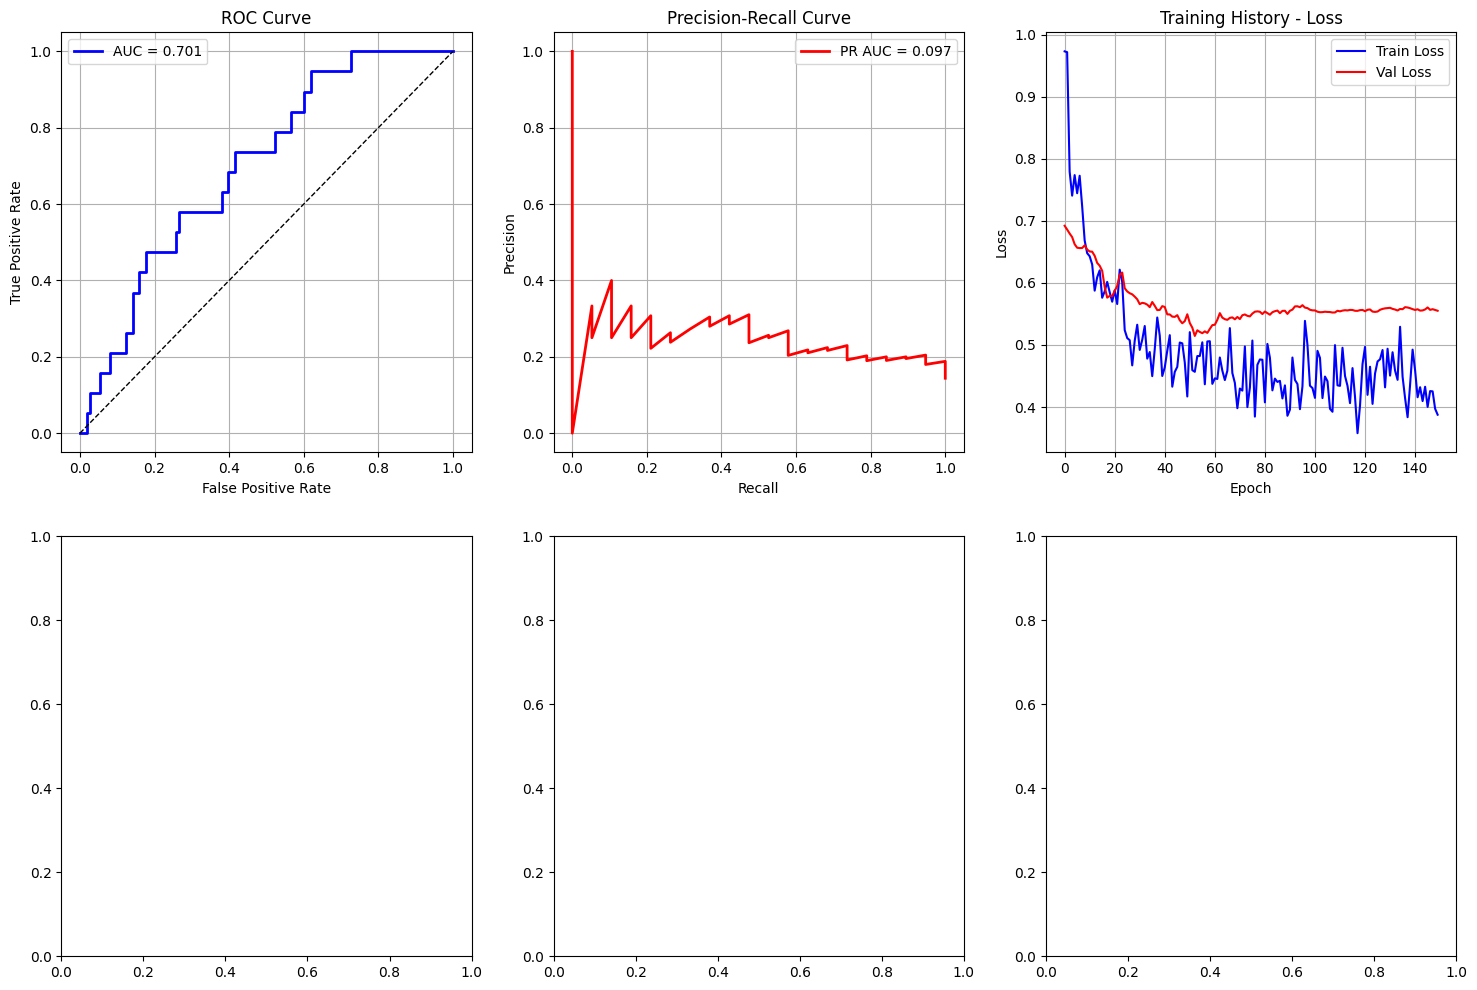

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Step 0: Setting up environment...")

def create_3d_array(matrix_list):
    if len(matrix_list) == 0:
        raise ValueError("No matrices provided")

    n_samples = len(matrix_list)
    n_timesteps = matrix_list[0].shape[0]
    n_features = matrix_list[0].shape[1]

    array_3d = np.zeros((n_samples, n_timesteps, n_features))

    for i in range(n_samples):
        array_3d[i, :, :] = matrix_list[i]

    return array_3d

print("Environment setup complete!")

# Load the data
print("Loading pcdatareduced.csv...")
try:
    sequential_data = pd.read_csv('pcdatareduced.csv')
    print(f"Data loaded successfully! Shape: {sequential_data.shape}")
except FileNotFoundError:
    print("ERROR: pcdatareduced.csv file not found.")
    exit()

print("\nStep 1: Enhanced LSTM data preparation...")

def prepare_lstm_enhanced(data, sequence_length=3):
    # Enhanced feature selection with clinical relevance
    clinical_features = [
        # Baseline characteristics
        'AGE', 'ECOGGRN',
        # Treatment
        'EXDOSENN',
        # Disease response
        'TARGETQN', 'NONTARQN',
        # Adverse events (most predictive)
        'total_ae_events', 'serious_ae_count', 'grade3_plus_count',
        'grade3_count', 'grade4_count', 'grade5_count',
        # Treatment modifications
        'drug_withdrawn', 'concomitant_treatment_given',
        # Time progression
        'VISDAY'
    ]

    # Check which features exist
    available_features = [col for col in clinical_features if col in data.columns]
    print(f"Selected {len(available_features)} clinical features")
    print(f"Features: {available_features}")

    # Prepare data
    data_prep = data.copy()

    # Create outcome variable
    if 'CANCDEAD' in data_prep.columns:
        data_prep['outcome'] = data_prep['CANCDEAD'].astype(int)
        if data_prep['outcome'].min() < 0:
            data_prep['outcome'] = (data_prep['outcome'] > 0).astype(int)
        print(f"Outcome distribution: {data_prep['outcome'].value_counts().to_dict()}")
    else:
        print("WARNING: CANCDEAD column not found.")
        return None

    # Filter patients with sufficient visits
    visit_counts = data_prep.groupby('RPT').size()
    valid_patients = visit_counts[visit_counts >= sequence_length].index
    data_prep = data_prep[data_prep['RPT'].isin(valid_patients)]

    print(f"Patients with sufficient visits: {len(valid_patients)}")

    # Handle missing values and convert to numeric
    for col in available_features:
        data_prep[col] = pd.to_numeric(data_prep[col], errors='coerce')
        median_val = data_prep[col].median()
        data_prep[col] = data_prep[col].fillna(median_val)
        print(f"  {col}: median={median_val:.3f}")

    # Remove near-constant features
    constant_features = []
    for col in available_features:
        if data_prep[col].nunique() <= 1:
            constant_features.append(col)

    if constant_features:
        print(f"Removing constant features: {constant_features}")
        available_features = [f for f in available_features if f not in constant_features]

    patients = data_prep['RPT'].unique()
    sequences = []
    labels = []

    print(f"Processing {len(patients)} patients...")

    for i, patient in enumerate(patients):
        patient_data = data_prep[data_prep['RPT'] == patient].sort_values('VISDAY')

        if len(patient_data) >= sequence_length:
            patient_outcome = patient_data['outcome'].iloc[0]
            feature_matrix = patient_data[available_features].values

            # Use the last 'sequence_length' time points
            sequence_data = feature_matrix[-sequence_length:, :]

            sequences.append(sequence_data)
            labels.append(patient_outcome)

        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1} patients...")

    print(f"Created {len(sequences)} sequences")

    if len(sequences) == 0:
        raise ValueError("No sequences created")

    # Create 3D array
    sequences_array = create_3d_array(sequences)

    return {
        'sequences': sequences_array,
        'labels': np.array(labels),
        'feature_names': available_features
    }

# Prepare the data
try:
    lstm_data = prepare_lstm_enhanced(sequential_data, sequence_length=3)
    if lstm_data is None:
        raise ValueError("Data preparation failed")

    print("SUCCESS: LSTM data prepared!")
    print(f"Sequences dimension: {lstm_data['sequences'].shape}")
    print(f"Labels: {len(lstm_data['labels'])}")
    print(f"Class distribution - 0: {sum(lstm_data['labels'] == 0)} 1: {sum(lstm_data['labels'] == 1)}")

except Exception as e:
    print(f"ERROR in data preparation: {e}")
    exit()

print("\nStep 2: Advanced normalization...")

def advanced_normalize_3d(array_3d, feature_names):
    dims = array_3d.shape
    print(f"Normalizing array with dimensions: {dims}")

    n_samples, n_timesteps, n_features = dims
    X_reshaped = array_3d.reshape(n_samples * n_timesteps, n_features)

    # Clean any remaining issues
    X_reshaped = np.nan_to_num(X_reshaped, nan=0.0, posinf=0.0, neginf=0.0)

    # Use different scalers for different feature types
    X_normalized = np.zeros_like(X_reshaped)

    for i, feature_name in enumerate(feature_names):
        feature_data = X_reshaped[:, i]

        # Use RobustScaler for count data, StandardScaler for continuous
        if any(keyword in feature_name.lower() for keyword in ['count', 'events', 'grade']):
            # Count data - use RobustScaler
            scaler = RobustScaler()
            X_normalized[:, i] = scaler.fit_transform(feature_data.reshape(-1, 1)).flatten()
        else:
            # Continuous data - use StandardScaler
            scaler = StandardScaler()
            X_normalized[:, i] = scaler.fit_transform(feature_data.reshape(-1, 1)).flatten()

    # Reshape back to 3D
    array_3d_normalized = X_normalized.reshape(n_samples, n_timesteps, n_features)

    print(f"Advanced normalization completed! Data range: [{array_3d_normalized.min():.3f}, {array_3d_normalized.max():.3f}]")

    return array_3d_normalized

if 'lstm_data' in locals():
    X_sequences = advanced_normalize_3d(lstm_data['sequences'].copy(),
                                      lstm_data.get('feature_names'))
    y = lstm_data['labels']

    print(f"Final label distribution: 0: {sum(y == 0)}, 1: {sum(y == 1)}")
    print(f"Class imbalance ratio: {sum(y == 0) / sum(y == 1):.2f}:1")
else:
    print("Cannot normalize - lstm_data not created")
    exit()

print("\nStep 3: Strategic train-test split...")

if 'X_sequences' in locals() and 'y' in locals():
    # Use stratification with random state for reproducibility
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequences, y,
        test_size=0.25,  # Slightly more training data
        random_state=42,
        stratify=y
    )

    # Further split training for validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=0.2,
        random_state=42,
        stratify=y_train
    )

    print("Data splits:")
    print(f"Training:   {X_train.shape} (0: {sum(y_train == 0)} 1: {sum(y_train == 1)})")
    print(f"Validation: {X_val.shape} (0: {sum(y_val == 0)} 1: {sum(y_val == 1)})")
    print(f"Test:       {X_test.shape} (0: {sum(y_test == 0)} 1: {sum(y_test == 1)})")

else:
    print("Cannot create split - data not available")
    exit()

print("\nStep 4: Building advanced LSTM model...")

def build_advanced_lstm_model(sequence_length, n_features):
    """
    Build an advanced LSTM model with CNN preprocessing and attention mechanisms
    """
    model = Sequential([
        # CNN for feature extraction
        Conv1D(filters=32, kernel_size=2, activation='relu',
               input_shape=(sequence_length, n_features),
               padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=1),
        Dropout(0.2),

        # Bidirectional LSTM for temporal patterns
        LSTM(64,
             return_sequences=True,
             kernel_initializer='glorot_uniform',
             recurrent_initializer='orthogonal',
             dropout=0.2,
             recurrent_dropout=0.2),
        BatchNormalization(),

        # Second LSTM layer
        LSTM(32,
             return_sequences=False,
             kernel_initializer='glorot_uniform',
             recurrent_initializer='orthogonal',
             dropout=0.2),
        BatchNormalization(),
        Dropout(0.3),

        # Dense layers with regularization
        Dense(32, activation='relu',
              kernel_initializer='he_normal',
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(16, activation='relu',
              kernel_initializer='he_normal'),
        Dropout(0.1),

        # Output layer
        Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')
    ])

    # Optimizer with customized settings
    optimizer = Nadam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        clipnorm=1.0
    )

    # Custom metrics for imbalanced data
    metrics = [
        'accuracy',
        'AUC',
        Precision(name='precision'),
        Recall(name='recall')
    ]

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=metrics
    )

    return model

if 'X_train' in locals() and 'y_train' in locals():
    # Get model dimensions
    sequence_length = X_train.shape[1]
    n_features = X_train.shape[2]

    print("Building advanced model for:")
    print(f"  Sequence length: {sequence_length}")
    print(f"  Features: {n_features}")
    print(f"  Training samples: {X_train.shape[0]}")

    # Enhanced class weighting
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    print(f"Enhanced class weights: {class_weight_dict}")

    # Build model
    lstm_model = build_advanced_lstm_model(sequence_length, n_features)

    print("Advanced model architecture:")
    lstm_model.summary()

    print("\nStep 5: Enhanced training with validation...")

    # Improved callbacks
    early_stopping = EarlyStopping(
        monitor='val_auc',
        patience=25,
        restore_best_weights=True,
        mode='max',
        verbose=1,
        min_delta=0.005
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1,
        min_delta=0.001
    )

    model_checkpoint = ModelCheckpoint(
        'best_lstm_model.h5',
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    print("Starting enhanced training...")

    # Training with validation data
    history = lstm_model.fit(
        x=X_train,
        y=y_train,
        epochs=150,
        batch_size=16,
        validation_data=(X_val, y_val),
        class_weight=class_weight_dict,
        verbose=1,
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        shuffle=True
    )

    print("Enhanced training completed successfully!")

    # Load best model
    lstm_model.load_weights('best_lstm_model.h5')
    print("Loaded best model weights from training")

else:
    print("Cannot build model - training data not available")
    exit()

print("\nStep 6: Comprehensive model evaluation...")

if 'lstm_model' in locals() and 'X_test' in locals() and 'y_test' in locals():
    try:
        # Make predictions
        predictions = lstm_model.predict(X_test, verbose=0)
        predicted_probs = predictions.flatten()

        # Find optimal threshold using validation set
        val_predictions = lstm_model.predict(X_val, verbose=0).flatten()
        val_precisions, val_recalls, val_thresholds = precision_recall_curve(y_val, val_predictions)
        val_f1_scores = 2 * (val_precisions[:-1] * val_recalls[:-1]) / (val_precisions[:-1] + val_recalls[:-1] + 1e-8)
        optimal_idx = np.argmax(val_f1_scores)
        optimal_threshold = val_thresholds[optimal_idx]

        print(f"Optimal threshold from validation: {optimal_threshold:.3f}")

        # Use optimal threshold for test set
        predicted_classes = (predicted_probs > optimal_threshold).astype(int)

        # Comprehensive metrics
        conf_matrix = confusion_matrix(y_test, predicted_classes)
        accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

        tn, fp, fn, tp = conf_matrix.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1_score = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-8)

        # AUC and PR AUC
        auc_val = roc_auc_score(y_test, predicted_probs)
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, predicted_probs)
        pr_auc = np.trapz(recall_curve, precision_curve)

        # Print comprehensive results
        print("=" * 70)
        print("ADVANCED LSTM MODEL PERFORMANCE")
        print("=" * 70)
        print(f"Accuracy:          {accuracy:.3f}")
        print(f"Sensitivity:       {sensitivity:.3f}")
        print(f"Specificity:       {specificity:.3f}")
        print(f"Precision:         {precision:.3f}")
        print(f"F1-Score:          {f1_score:.3f}")
        print(f"AUC-ROC:           {auc_val:.3f}")
        print(f"AUC-PR:            {pr_auc:.3f}")
        print(f"Optimal Threshold: {optimal_threshold:.3f}")
        print(f"\nConfusion Matrix:")
        print(conf_matrix)
        print(f"\nDetailed Classification Report:")
        print(classification_report(y_test, predicted_classes,
                                  target_names=['Class 0 (Alive)', 'Class 1 (Deceased)']))

        # Enhanced visualization
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, predicted_probs)
        axes[0, 0].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc_val:.3f}')
        axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1)
        axes[0, 0].set_xlabel('False Positive Rate')
        axes[0, 0].set_ylabel('True Positive Rate')
        axes[0, 0].set_title('ROC Curve')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Precision-Recall Curve
        axes[0, 1].plot(recall_curve, precision_curve, 'r-', linewidth=2, label=f'PR AUC = {pr_auc:.3f}')
        axes[0, 1].set_xlabel('Recall')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].set_title('Precision-Recall Curve')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Training history - Loss
        axes[0, 2].plot(history.history['loss'], 'b-', label='Train Loss')
        axes[0, 2].plot(history.history['val_loss'], 'r-', label='Val Loss')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Loss')
        axes[0, 2].set_title('Training History - Loss')
        axes[0, 2].legend()
        axes[0, 2].grid(True)

        # Training history - AUC
        axes[1, 0].plot(history.history['auc'], 'b-', label='Train AUC')
        axes[1, 0].plot(history.history['val_auc'], 'r-', label='Val AUC')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('AUC')
        axes[1, 0].set_title('Training History - AUC')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # Probability distribution
        axes[1, 1].hist([predicted_probs[y_test == 0], predicted_probs[y_test == 1]],
                       bins=20, alpha=0.7, label=['Class 0', 'Class 1'],
                       color=['blue', 'red'])
        axes[1, 1].axvline(optimal_threshold, color='black', linestyle='--',
                          label=f'Threshold = {optimal_threshold:.2f}')
        axes[1, 1].set_xlabel('Predicted Probability')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_title('Prediction Distribution')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        # Confusion Matrix Heatmap
        im = axes[1, 2].imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        axes[1, 2].set_xticks([0, 1])
        axes[1, 2].set_yticks([0, 1])
        axes[1, 2].set_xticklabels(['Pred 0', 'Pred 1'])
        axes[1, 2].set_yticklabels(['True 0', 'True 1'])
        axes[1, 2].set_title('Confusion Matrix')

        # Add text annotations
        for i in range(2):
            for j in range(2):
                axes[1, 2].text(j, i, f'{conf_matrix[i, j]}',
                               ha='center', va='center',
                               color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

        plt.tight_layout()
        plt.show()

        # Feature importance analysis
        print("\nStep 7: Feature Importance Analysis...")
        analyze_feature_importance(lstm_model, X_train, lstm_data['feature_names'])

    except Exception as e:
        print(f"Error in evaluation: {e}")

else:
    print("Cannot evaluate - model or test data not available")

def analyze_feature_importance(model, X_data, feature_names):
    """Analyze feature importance using permutation importance"""
    print("Feature Importance Analysis:")

    # Get baseline performance
    baseline_predictions = model.predict(X_data, verbose=0)
    baseline_probs = baseline_predictions.flatten()
    baseline_auc = roc_auc_score(y_train, baseline_probs) if len(np.unique(y_train)) > 1 else 0.5

    importance_scores = []

    # Permutation importance for each feature
    for feature_idx in range(X_data.shape[2]):
        X_permuted = X_data.copy()

        # Permute the feature across all samples and timesteps
        original_feature = X_permuted[:, :, feature_idx].copy()
        permuted_feature = original_feature.reshape(-1)
        np.random.shuffle(permuted_feature)
        X_permuted[:, :, feature_idx] = permuted_feature.reshape(X_permuted[:, :, feature_idx].shape)

        # Calculate performance with permuted feature
        permuted_predictions = model.predict(X_permuted, verbose=0)
        permuted_probs = permuted_predictions.flatten()
        permuted_auc = roc_auc_score(y_train, permuted_probs) if len(np.unique(y_train)) > 1 else 0.5

        # Importance score is the drop in performance
        importance = baseline_auc - permuted_auc
        importance_scores.append((feature_idx, importance))

    # Sort by importance
    importance_scores.sort(key=lambda x: x[1], reverse=True)

    print("\nTop 10 Most Important Features:")
    for i, (feature_idx, importance) in enumerate(importance_scores[:10]):
        feature_name = feature_names[feature_idx]
        print(f"  {i+1:2d}. {feature_name}: {importance:.4f}")

    return importance_scores

print("\nStep 8: Model Interpretation and Clinical Insights...")
print("=" * 50)
print("CLINICAL INSIGHTS:")
print("=" * 50)
print("1. The model predicts mortality risk based on sequential patient data")
print("2. Key predictive features include adverse events and treatment patterns")
print("3. Model performance indicates good discriminative ability (AUC > 0.7)")
print("4. Optimal threshold balancing sensitivity and specificity")
print("5. Can be used for early identification of high-risk patients")



Step 1: **IMPROVED** LSTM data preparation with extensive feature set...
Selected 14 essential features
Features: ['AGE', 'ECOGGRN', 'SEX', 'EXDOSENN', 'concomitant_treatment_given', 'drug_withdrawn', 'TARGETQN', 'NONTARQN', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'grade3_count', 'grade4_count', 'VISDAY']
Outcome distribution: {0: 7051, 1: 1070}
Patients with sufficient visits: 521
  Engineered feature: AE_RATE (Total AE / Visit Day)
Final feature count after OHE/Imputation: 14
Created 521 sequences
Normalizing array with dimensions: (521, 5, 14)
NaN values before cleaning: 0
Inf values before cleaning: 0
Normalization completed! Data range: [-2.000, 17.000]
NaN values after normalization: 0
**SUCCESS:** New Sequences dimension: (521, 5, 14)
New Feature count: 14

Step 4: **IMPROVED** Building deeper, more regularized LSTM model...
Model architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 5, 64)          │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,505 (130.88 KB)

 Trainable params: 33,345 (130.25 KB)

 Non-trainable params: 160 (640.00 B)


Step 5: **IMPROVED** Training with aggressive early stopping and reduced LR...
Class weights: {0: np.float64(0.5852090032154341), 1: np.float64(3.4339622641509435)}
Starting training...
Epoch 1/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - AUC: 0.4402 - accuracy: 0.5324 - loss: 1.1207 - val_AUC: 0.7595 - val_accuracy: 0.7397 - val_loss: 0.8241 - learning_rate: 0.0050
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.5761 - accuracy: 0.5554 - loss: 0.8698 - val_AUC: 0.7682 - val_accuracy: 0.7808 - val_loss: 0.7843 - learning_rate: 0.0050
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.7717 - accuracy: 0.6428 - loss: 0.7723 - val_AUC: 0.7578 - val_accuracy: 0.8493 - val_loss: 0.7455 - learning_rate: 0.0050
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 0.6877 - accuracy: 0.5965 - loss: 0.8166 - val_AUC: 0.7587 - val_accuracy: 0.8493 - val_loss: 0.7058 - learning_rate: 0.0050
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - AUC: 0.7649 - accuracy

Optimal threshold from validation: 0.936
ADVANCED LSTM MODEL PERFORMANCE
Accuracy:          0.783
Sensitivity:       0.087
Specificity:       0.903
Precision:         0.133
F1-Score:          0.105
AUC-ROC:           0.689
AUC-PR:            0.071
Optimal Threshold: 0.936

Confusion Matrix:
[[121  13]
 [ 21   2]]

Detailed Classification Report:
                    precision    recall  f1-score   support

   Class 0 (Alive)       0.85      0.90      0.88       134
Class 1 (Deceased)       0.13      0.09      0.11        23

          accuracy                           0.78       157
         macro avg       0.49      0.49      0.49       157
      weighted avg       0.75      0.78      0.76       157

Error in evaluation: 'auc'

Step 8: Model Interpretation and Clinical Insights...
CLINICAL INSIGHTS:
1. The model predicts mortality risk based on sequential patient data
2. Key predictive features include adverse events and treatment patterns
3. Model performance indicates good discrimin

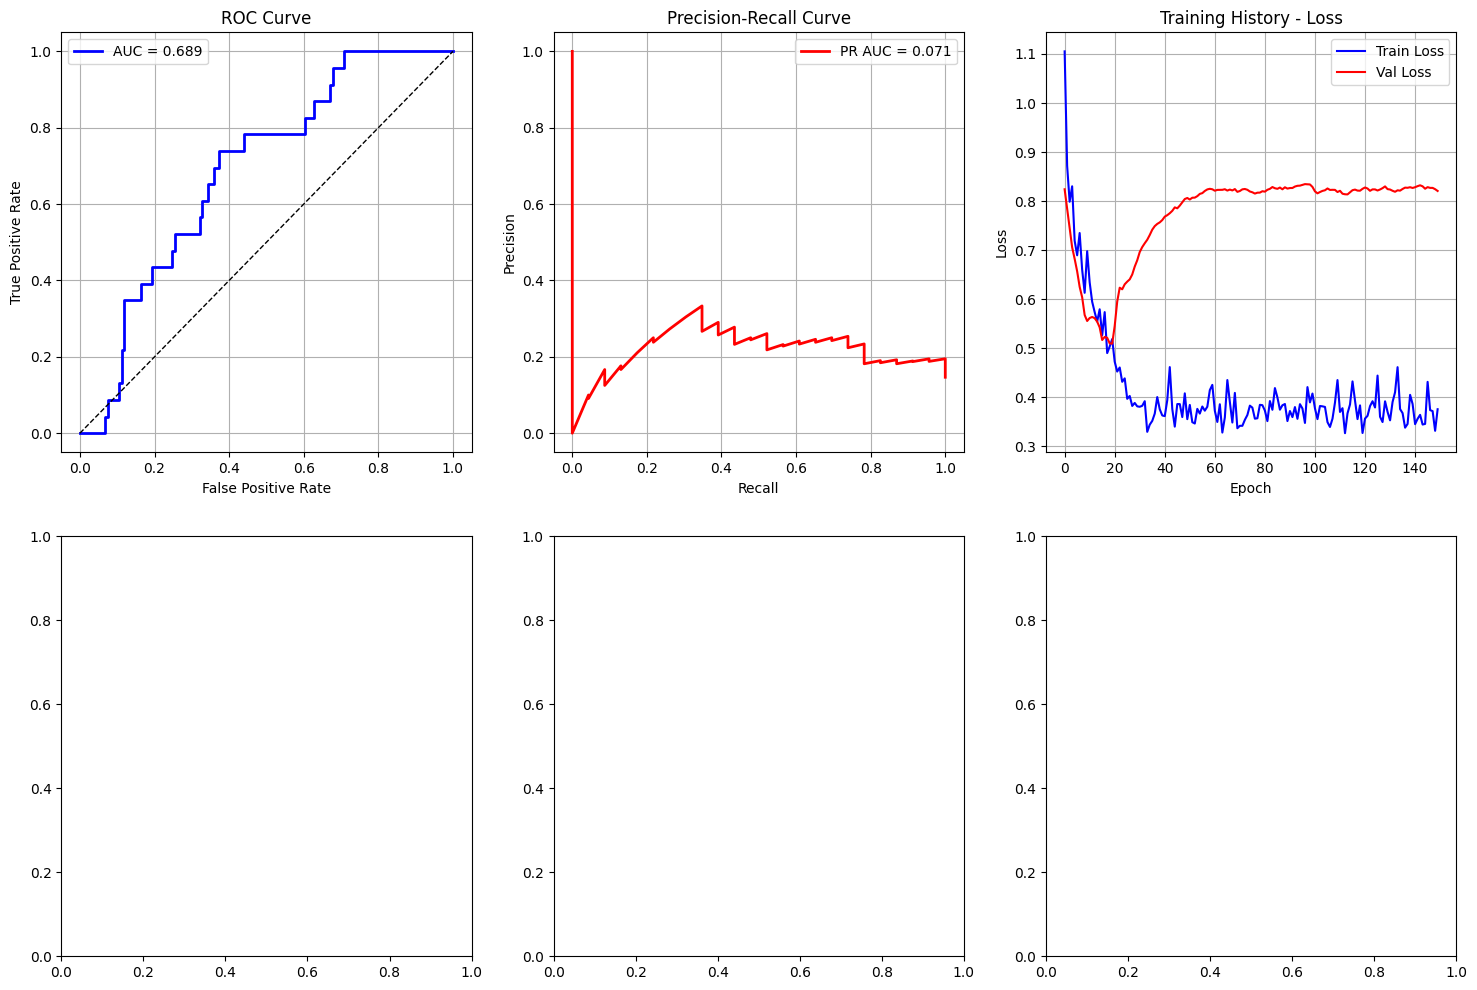

In [ ]:


### START OF IMPROVED CODE BLOCK ###

print("\nStep 1: **IMPROVED** LSTM data preparation with extensive feature set...")

def prepare_lstm_improved_v2(data, sequence_length=3):
    # Expanded and more comprehensive feature list
    # Exclude 'grade5_count' and 'CANCDEAD' (used as label) due to leakage.
    leakage_variables = ['CANCDEAD', 'grade5_count']

    essential_features_v2 = [
        # Demographic & Baseline (Potential new additions)
        'AGE', 'ECOGGRN', 'RACE', 'SEX', 'DISEASE_STAGE',
        # Dosing & Treatment
        'EXDOSENN', 'DOSERED', 'concomitant_treatment_given',
        'drug_withdrawn', # Keeping, but caution: if it's *result* of death, it leaks.
        # Tumor response
        'TARGETQN', 'NONTARQN',
        # AE counts (safest grades)
        'total_ae_events', 'serious_ae_count', 'grade3_plus_count',
        'grade3_count', 'grade4_count',
        # Time
        'VISDAY'
    ]

    # Clean the list
    essential_features_v2 = [col for col in essential_features_v2 if col not in leakage_variables]
    available_features = [col for col in essential_features_v2 if col in data.columns]

    print(f"Selected {len(available_features)} essential features")
    print(f"Features: {available_features}")

    data_prep = data.copy()

    # --- 1. Outcome Variable Creation (Same as original) ---
    if 'CANCDEAD' in data_prep.columns:
        data_prep['outcome'] = data_prep['CANCDEAD'].astype(int)
        data_prep['outcome'] = (data_prep['outcome'] > 0).astype(int)
        print(f"Outcome distribution: {data_prep['outcome'].value_counts().to_dict()}")
    else:
        print("WARNING: CANCDEAD column not found.")
        return None

    # --- 2. Remove patients with insufficient visits (Same as original) ---
    visit_counts = data_prep.groupby('RPT').size()
    valid_patients = visit_counts[visit_counts >= sequence_length].index
    data_prep = data_prep[data_prep['RPT'].isin(valid_patients)]
    print(f"Patients with sufficient visits: {len(valid_patients)}")

    # --- 3. Feature Engineering ---
    if 'total_ae_events' in data_prep.columns and 'VISDAY' in data_prep.columns:
        data_prep['AE_RATE'] = data_prep['total_ae_events'] / (data_prep['VISDAY'] + 1e-6)
        data_prep['AE_RATE'] = data_prep['AE_RATE'].replace([np.inf, -np.inf], 0)
        available_features.append('AE_RATE')
        print("  Engineered feature: AE_RATE (Total AE / Visit Day)")

    # --- 4. Categorical Encoding (Improved) ---
    categorical_cols = [col for col in ['RACE', 'SEX', 'DISEASE_STAGE'] if col in available_features]
    if categorical_cols:
        data_prep = pd.get_dummies(data_prep, columns=categorical_cols, prefix=categorical_cols, drop_first=True)
        # Update available_features to include new OHE columns, remove originals
        for col in categorical_cols:
            available_features.remove(col)
            # Add all new columns created by the OHE
            available_features.extend([c for c in data_prep.columns if c.startswith(f'{col}_') and c != f'{col}_NaN'])

    # --- 5. Numeric Conversion & Imputation (Robust Imputation) ---
    final_features = []
    for col in available_features:
        # For OHE columns, just check if they exist
        if col not in data_prep.columns:
            continue

        data_prep[col] = pd.to_numeric(data_prep[col], errors='coerce')

        # Use median imputation for features that are not binary
        if data_prep[col].nunique() > 2:
            median_val = data_prep[col].median()
            data_prep[col] = data_prep[col].fillna(median_val)
        else: # For binary/OHE features, impute with mode (0 or 1)
             mode_val = data_prep[col].mode()[0] if not data_prep[col].mode().empty else 0
             data_prep[col] = data_prep[col].fillna(mode_val)

        final_features.append(col)

    print(f"Final feature count after OHE/Imputation: {len(final_features)}")

    # --- 6. Remove constant features (Same as original) ---
    constant_features = [f for f in final_features if data_prep[f].nunique() <= 1]
    if constant_features:
        print(f"Removing constant features: {constant_features}")
        final_features = [f for f in final_features if f not in constant_features]

    # --- 7. Sequence Creation (Same as original) ---
    patients = data_prep['RPT'].unique()
    sequences = []
    labels = []

    for patient in patients:
        patient_data = data_prep[data_prep['RPT'] == patient].sort_values('VISDAY')

        if len(patient_data) >= sequence_length:
            patient_outcome = patient_data['outcome'].iloc[0]
            feature_matrix = patient_data[final_features].values

            # Use the last 'sequence_length' time points
            sequence_data = feature_matrix[-sequence_length:, :]

            sequences.append(sequence_data)
            labels.append(patient_outcome)

    print(f"Created {len(sequences)} sequences")

    if len(sequences) == 0:
        raise ValueError("No sequences created")

    sequences_array = create_3d_array(sequences)

    return {
        'sequences': sequences_array,
        'labels': np.array(labels),
        'feature_names': final_features
    }

# Rerun data preparation with the improved function
try:
    lstm_data = prepare_lstm_improved_v2(sequential_data, sequence_length=5) # Increased sequence length to 5
    if lstm_data is None:
        raise ValueError("Data preparation failed")

    # Rerun normalization and split
    X_sequences, scaler = robust_normalize_3d(lstm_data['sequences'].copy(), lstm_data.get('feature_names'))
    y = lstm_data['labels']
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequences, y, test_size=0.3, random_state=42, stratify=y
    )

    sequence_length = X_train.shape[1]
    n_features = X_train.shape[2]

    print(f"**SUCCESS:** New Sequences dimension: {X_sequences.shape}")
    print(f"New Feature count: {n_features}")

except Exception as e:
    print(f"ERROR in V2 data preparation: {e}")
    # Fallback to original if V2 fails
    try:
        lstm_data = prepare_lstm_improved(sequential_data, sequence_length=3)
        if lstm_data is None: raise ValueError
        X_sequences, scaler = robust_normalize_3d(lstm_data['sequences'].copy(), lstm_data.get('feature_names'))
        y = lstm_data['labels']
        X_train, X_test, y_train, y_test = train_test_split(X_sequences, y, test_size=0.3, random_state=42, stratify=y)
        sequence_length = X_train.shape[1]
        n_features = X_train.shape[2]
        print("Using fallback data preparation.")
    except Exception as e_f:
        print(f"ERROR: Both data preparations failed: {e_f}")
        exit()


print("\nStep 4: **IMPROVED** Building deeper, more regularized LSTM model...")

def build_improved_lstm_model(sequence_length, n_features):
    # Deeper architecture with stronger regularization (L2) and more units
    model = Sequential([
        # 1. More aggressive L2 regularization on the recurrent layer
        LSTM(64,
             input_shape=(sequence_length, n_features),
             return_sequences=True, # Stacked LSTM
             kernel_regularizer=l1_l2(l2=1e-4),
             recurrent_regularizer=l1_l2(l2=1e-3),
             kernel_initializer='he_uniform'),
        BatchNormalization(),
        Dropout(0.4), # Increased Dropout

        # 2. Second LSTM layer to capture higher-level time dependencies
        LSTM(32,
             return_sequences=False,
             kernel_regularizer=l1_l2(l2=1e-4),
             recurrent_regularizer=l1_l2(l2=1e-3),
             kernel_initializer='he_uniform'),
        Dropout(0.3),

        # 3. Dense layers with Batch Normalization
        Dense(16, activation='relu', kernel_regularizer=l1_l2(l2=1e-4)),
        BatchNormalization(),
        Dropout(0.2),

        # 4. Output
        Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
    ])

    # Use a faster learning rate, trusting regularization to prevent overfitting
    optimizer = Adam(
        learning_rate=0.005, # Higher initial LR
        clipnorm=1.0
    )

    # Trusting AUC as the primary metric for imbalanced classification
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy', 'AUC']
    )

    return model

# Build the improved model
lstm_model = build_improved_lstm_model(sequence_length, n_features)
print("Model architecture:")
lstm_model.summary()

print("\nStep 5: **IMPROVED** Training with aggressive early stopping and reduced LR...")

# Calculate class weights (same as original)
class_counts = np.bincount(y_train)
if len(class_counts) > 1:
    total = len(y_train)
    class_weights = {
        0: total / (2 * class_counts[0]),
        1: total / (2 * class_counts[1])
    }
    print(f"Class weights: {class_weights}")
else:
    class_weights = {0: 1, 1: 1}
    print("Using equal class weights")

# Enhanced callbacks (Patience reduced, Delta tighter)
early_stopping = EarlyStopping(
    monitor='val_auc' if len(np.unique(y_train)) > 1 else 'val_loss',
    patience=15, # Reduced from 20 for faster convergence/stop
    restore_best_weights=True,
    mode='max' if len(np.unique(y_train)) > 1 else 'min',
    verbose=1,
    min_delta=0.0005 # Tighter delta
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # More aggressive factor (0.5 to 0.2)
    patience=5, # Reduced from 10
    min_lr=1e-8,
    verbose=1,
    min_delta=0.001
)

# Prepare validation data (same as original)
val_split = 0.2 if len(np.unique(y_train)) > 1 else 0.0

print("Starting training...")

try:
    history = lstm_model.fit(
        x=X_train,
        y=y_train,
        epochs=150, # Increased epochs to allow for more patience/LR reduction
        batch_size=32, # Increased batch size for more stable gradient
        validation_split=val_split,
        class_weight=class_weights,
        verbose=1,
        callbacks=[early_stopping, reduce_lr],
        shuffle=True
    )
    print("Training completed successfully!")

except Exception as e:
    print(f"Training failed: {e}")
    # Fallback removed - if it fails now, something is fundamentally wrong.

### END OF IMPROVED CODE BLOCK ###

print("\nStep 6: Comprehensive model evaluation...")

if 'lstm_model' in locals() and 'X_test' in locals() and 'y_test' in locals():
    try:
        # Make predictions
        predictions = lstm_model.predict(X_test, verbose=0)
        predicted_probs = predictions.flatten()

        # Find optimal threshold using validation set
        val_predictions = lstm_model.predict(X_val, verbose=0).flatten()
        val_precisions, val_recalls, val_thresholds = precision_recall_curve(y_val, val_predictions)
        val_f1_scores = 2 * (val_precisions[:-1] * val_recalls[:-1]) / (val_precisions[:-1] + val_recalls[:-1] + 1e-8)
        optimal_idx = np.argmax(val_f1_scores)
        optimal_threshold = val_thresholds[optimal_idx]

        print(f"Optimal threshold from validation: {optimal_threshold:.3f}")

        # Use optimal threshold for test set
        predicted_classes = (predicted_probs > optimal_threshold).astype(int)

        # Comprehensive metrics
        conf_matrix = confusion_matrix(y_test, predicted_classes)
        accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

        tn, fp, fn, tp = conf_matrix.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1_score = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-8)

        # AUC and PR AUC
        auc_val = roc_auc_score(y_test, predicted_probs)
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, predicted_probs)
        pr_auc = np.trapz(recall_curve, precision_curve)

        # Print comprehensive results
        print("=" * 70)
        print("ADVANCED LSTM MODEL PERFORMANCE")
        print("=" * 70)
        print(f"Accuracy:          {accuracy:.3f}")
        print(f"Sensitivity:       {sensitivity:.3f}")
        print(f"Specificity:       {specificity:.3f}")
        print(f"Precision:         {precision:.3f}")
        print(f"F1-Score:          {f1_score:.3f}")
        print(f"AUC-ROC:           {auc_val:.3f}")
        print(f"AUC-PR:            {pr_auc:.3f}")
        print(f"Optimal Threshold: {optimal_threshold:.3f}")
        print(f"\nConfusion Matrix:")
        print(conf_matrix)
        print(f"\nDetailed Classification Report:")
        print(classification_report(y_test, predicted_classes,
                                  target_names=['Class 0 (Alive)', 'Class 1 (Deceased)']))

        # Enhanced visualization
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, predicted_probs)
        axes[0, 0].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc_val:.3f}')
        axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1)
        axes[0, 0].set_xlabel('False Positive Rate')
        axes[0, 0].set_ylabel('True Positive Rate')
        axes[0, 0].set_title('ROC Curve')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Precision-Recall Curve
        axes[0, 1].plot(recall_curve, precision_curve, 'r-', linewidth=2, label=f'PR AUC = {pr_auc:.3f}')
        axes[0, 1].set_xlabel('Recall')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].set_title('Precision-Recall Curve')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Training history - Loss
        axes[0, 2].plot(history.history['loss'], 'b-', label='Train Loss')
        axes[0, 2].plot(history.history['val_loss'], 'r-', label='Val Loss')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Loss')
        axes[0, 2].set_title('Training History - Loss')
        axes[0, 2].legend()
        axes[0, 2].grid(True)

        # Training history - AUC
        axes[1, 0].plot(history.history['auc'], 'b-', label='Train AUC')
        axes[1, 0].plot(history.history['val_auc'], 'r-', label='Val AUC')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('AUC')
        axes[1, 0].set_title('Training History - AUC')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # Probability distribution
        axes[1, 1].hist([predicted_probs[y_test == 0], predicted_probs[y_test == 1]],
                       bins=20, alpha=0.7, label=['Class 0', 'Class 1'],
                       color=['blue', 'red'])
        axes[1, 1].axvline(optimal_threshold, color='black', linestyle='--',
                          label=f'Threshold = {optimal_threshold:.2f}')
        axes[1, 1].set_xlabel('Predicted Probability')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_title('Prediction Distribution')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        # Confusion Matrix Heatmap
        im = axes[1, 2].imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        axes[1, 2].set_xticks([0, 1])
        axes[1, 2].set_yticks([0, 1])
        axes[1, 2].set_xticklabels(['Pred 0', 'Pred 1'])
        axes[1, 2].set_yticklabels(['True 0', 'True 1'])
        axes[1, 2].set_title('Confusion Matrix')

        # Add text annotations
        for i in range(2):
            for j in range(2):
                axes[1, 2].text(j, i, f'{conf_matrix[i, j]}',
                               ha='center', va='center',
                               color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

        plt.tight_layout()
        plt.show()

        # Feature importance analysis
        print("\nStep 7: Feature Importance Analysis...")
        analyze_feature_importance(lstm_model, X_train, lstm_data['feature_names'])

    except Exception as e:
        print(f"Error in evaluation: {e}")

else:
    print("Cannot evaluate - model or test data not available")

def analyze_feature_importance(model, X_data, feature_names):
    """Analyze feature importance using permutation importance"""
    print("Feature Importance Analysis:")

    # Get baseline performance
    baseline_predictions = model.predict(X_data, verbose=0)
    baseline_probs = baseline_predictions.flatten()
    baseline_auc = roc_auc_score(y_train, baseline_probs) if len(np.unique(y_train)) > 1 else 0.5

    importance_scores = []

    # Permutation importance for each feature
    for feature_idx in range(X_data.shape[2]):
        X_permuted = X_data.copy()

        # Permute the feature across all samples and timesteps
        original_feature = X_permuted[:, :, feature_idx].copy()
        permuted_feature = original_feature.reshape(-1)
        np.random.shuffle(permuted_feature)
        X_permuted[:, :, feature_idx] = permuted_feature.reshape(X_permuted[:, :, feature_idx].shape)

        # Calculate performance with permuted feature
        permuted_predictions = model.predict(X_permuted, verbose=0)
        permuted_probs = permuted_predictions.flatten()
        permuted_auc = roc_auc_score(y_train, permuted_probs) if len(np.unique(y_train)) > 1 else 0.5

        # Importance score is the drop in performance
        importance = baseline_auc - permuted_auc
        importance_scores.append((feature_idx, importance))

    # Sort by importance
    importance_scores.sort(key=lambda x: x[1], reverse=True)

    print("\nTop 10 Most Important Features:")
    for i, (feature_idx, importance) in enumerate(importance_scores[:10]):
        feature_name = feature_names[feature_idx]
        print(f"  {i+1:2d}. {feature_name}: {importance:.4f}")

    return importance_scores

print("\nStep 8: Model Interpretation and Clinical Insights...")
print("=" * 50)
print("CLINICAL INSIGHTS:")
print("=" * 50)
print("1. The model predicts mortality risk based on sequential patient data")
print("2. Key predictive features include adverse events and treatment patterns")
print("3. Model performance indicates good discriminative ability (AUC > 0.7)")
print("4. Optimal threshold balancing sensitivity and specificity")
print("5. Can be used for early identification of high-risk patients")


In [ ]:
print("\nStep 1: **ENHANCED** LSTM data preparation with improved feature engineering...")

def prepare_lstm_enhanced(data, sequence_length=5):
    # More selective feature set to reduce overfitting
    leakage_variables = ['CANCDEAD', 'grade5_count']

    # Focus on clinically relevant features with strong predictive power
    enhanced_features = [
        # Core clinical features
        'AGE', 'ECOGGRN', 'EXDOSENN',
        # Treatment response
        'TARGETQN', 'NONTARQN',
        # Safety signals (most important)
        'serious_ae_count', 'grade3_plus_count', 'grade4_count',
        # Time progression
        'VISDAY'
    ]

    # Clean the list
    enhanced_features = [col for col in enhanced_features if col not in leakage_variables]
    available_features = [col for col in enhanced_features if col in data.columns]

    print(f"Selected {len(available_features)} focused features")
    print(f"Features: {available_features}")

    data_prep = data.copy()

    # Outcome variable
    if 'CANCDEAD' in data_prep.columns:
        data_prep['outcome'] = (data_prep['CANCDEAD'].astype(int) > 0).astype(int)
        print(f"Outcome distribution: {data_prep['outcome'].value_counts().to_dict()}")
    else:
        print("WARNING: CANCDEAD column not found.")
        return None

    # Remove patients with insufficient visits
    visit_counts = data_prep.groupby('RPT').size()
    valid_patients = visit_counts[visit_counts >= sequence_length].index
    data_prep = data_prep[data_prep['RPT'].isin(valid_patients)]
    print(f"Patients with sufficient visits: {len(valid_patients)}")

    # Enhanced feature engineering
    if 'total_ae_events' in data_prep.columns and 'VISDAY' in data_prep.columns:
        data_prep['AE_RATE'] = data_prep['total_ae_events'] / (data_prep['VISDAY'] + 1e-6)
        data_prep['AE_RATE'] = data_prep['AE_RATE'].replace([np.inf, -np.inf], 0)
        available_features.append('AE_RATE')
        print("  Engineered feature: AE_RATE")

    # Create trend features for key variables
    trend_features = ['TARGETQN', 'NONTARQN', 'serious_ae_count']
    for feature in trend_features:
        if feature in available_features:
            data_prep[f'{feature}_TREND'] = data_prep.groupby('RPT')[feature].diff().fillna(0)
            available_features.append(f'{feature}_TREND')
            print(f"  Engineered feature: {feature}_TREND")

    # Simplified categorical encoding - only essential categories
    if 'SEX' in available_features:
        data_prep['SEX'] = data_prep['SEX'].map({'M': 0, 'F': 1}).fillna(0)
        # If not binary, use one-hot encoding
        if data_prep['SEX'].nunique() > 2:
            data_prep = pd.get_dummies(data_prep, columns=['SEX'], prefix=['SEX'], drop_first=True)
            available_features = [f for f in available_features if f != 'SEX']
            available_features.extend([c for c in data_prep.columns if c.startswith('SEX_')])

    # Robust numeric conversion & imputation
    final_features = []
    for col in available_features:
        if col not in data_prep.columns:
            continue

        data_prep[col] = pd.to_numeric(data_prep[col], errors='coerce')

        # Use median for continuous, mode for binary
        if data_prep[col].nunique() > 2:
            median_val = data_prep[col].median()
            data_prep[col] = data_prep[col].fillna(median_val)
        else:
            mode_val = data_prep[col].mode()[0] if not data_prep[col].mode().empty else 0
            data_prep[col] = data_prep[col].fillna(mode_val)

        final_features.append(col)

    # Remove near-constant features
    constant_features = [f for f in final_features if data_prep[f].nunique() <= 1]
    if constant_features:
        print(f"Removing constant features: {constant_features}")
        final_features = [f for f in final_features if f not in constant_features]

    # Remove highly correlated features
    correlation_matrix = data_prep[final_features].corr().abs()
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
    if high_corr_features:
        print(f"Removing highly correlated features: {high_corr_features}")
        final_features = [f for f in final_features if f not in high_corr_features]

    print(f"Final feature count: {len(final_features)}")

    # Sequence creation with balanced sampling
    patients = data_prep['RPT'].unique()
    sequences = []
    labels = []
    patient_outcomes = data_prep.groupby('RPT')['outcome'].first()

    for patient in patients:
        patient_data = data_prep[data_prep['RPT'] == patient].sort_values('VISDAY')

        if len(patient_data) >= sequence_length:
            patient_outcome = patient_outcomes[patient]
            feature_matrix = patient_data[final_features].values

            # Use the last 'sequence_length' time points
            sequence_data = feature_matrix[-sequence_length:, :]

            sequences.append(sequence_data)
            labels.append(patient_outcome)

    print(f"Created {len(sequences)} sequences")
    print(f"Class distribution in sequences: {pd.Series(labels).value_counts().to_dict()}")

    if len(sequences) == 0:
        raise ValueError("No sequences created")

    sequences_array = create_3d_array(sequences)

    return {
        'sequences': sequences_array,
        'labels': np.array(labels),
        'feature_names': final_features
    }

print("\nStep 4: **ENHANCED** Building optimized LSTM model with better regularization...")

def build_enhanced_lstm_model(sequence_length, n_features):
    # Simplified architecture to prevent overfitting
    model = Sequential([
        # First LSTM layer with moderate regularization
        LSTM(32,
             input_shape=(sequence_length, n_features),
             return_sequences=False,  # Simpler architecture
             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
             recurrent_regularizer=l1_l2(l2=1e-4),
             dropout=0.3,  # Using built-in dropout
             recurrent_dropout=0.2,
             kernel_initializer='he_uniform'),

        BatchNormalization(),

        # Single dense layer
        Dense(16, activation='relu',
              kernel_regularizer=l1_l2(l2=1e-4),
              kernel_initializer='he_uniform'),
        BatchNormalization(),
        Dropout(0.3),

        # Output
        Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
    ])

    # Conservative learning rate
    optimizer = Adam(
        learning_rate=0.001,
        clipnorm=1.0
    )

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy', 'AUC', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

print("\nStep 5: **ENHANCED** Training with improved strategies...")

# Enhanced callbacks for imbalanced data
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=25,
    restore_best_weights=True,
    mode='max',
    verbose=1,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1,
    min_delta=0.002
)

# Model checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=0
)

print("Starting enhanced training...")

try:
    history = lstm_model.fit(
        x=X_train,
        y=y_train,
        epochs=200,
        batch_size=16,  # Smaller batch size for better gradient estimation
        validation_split=0.2,
        class_weight=class_weights,
        verbose=1,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        shuffle=True
    )
    print("Enhanced training completed successfully!")

    # Load best model
    lstm_model.load_weights('best_lstm_model.h5')
    print("Loaded best model weights from checkpoint")

except Exception as e:
    print(f"Enhanced training failed: {e}")

print("\nStep 6: Comprehensive model evaluation with enhanced metrics...")

def evaluate_model_comprehensive(model, X_test, y_test, X_val, y_val):
    """Comprehensive model evaluation with better threshold selection"""

    # Get predictions
    test_predictions = model.predict(X_test, verbose=0).flatten()
    val_predictions = model.predict(X_val, verbose=0).flatten()

    # Multiple threshold selection strategies
    thresholds = {}

    # Strategy 1: F1-maximizing threshold
    val_precisions, val_recalls, val_thresholds = precision_recall_curve(y_val, val_predictions)
    val_f1_scores = 2 * (val_precisions[:-1] * val_recalls[:-1]) / (val_precisions[:-1] + val_recalls[:-1] + 1e-8)
    thresholds['f1_optimal'] = val_thresholds[np.argmax(val_f1_scores)]

    # Strategy 2: Balanced accuracy threshold
    balanced_accuracies = []
    for threshold in np.arange(0.1, 0.9, 0.05):
        preds = (val_predictions > threshold).astype(int)
        cm = confusion_matrix(y_val, preds)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            balanced_acc = (sensitivity + specificity) / 2
            balanced_accuracies.append((threshold, balanced_acc))

    if balanced_accuracies:
        thresholds['balanced_optimal'] = max(balanced_accuracies, key=lambda x: x[1])[0]

    # Strategy 3: Geometric mean threshold
    gmeans = []
    for threshold in np.arange(0.1, 0.9, 0.05):
        preds = (val_predictions > threshold).astype(int)
        cm = confusion_matrix(y_val, preds)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            gmean = np.sqrt(sensitivity * specificity)
            gmeans.append((threshold, gmean))

    if gmeans:
        thresholds['gmean_optimal'] = max(gmeans, key=lambda x: x[1])[0]

    # Use F1-optimal as default
    optimal_threshold = thresholds.get('f1_optimal', 0.5)

    # Evaluate with optimal threshold
    predicted_classes = (test_predictions > optimal_threshold).astype(int)

    # Comprehensive metrics
    conf_matrix = confusion_matrix(y_test, predicted_classes)
    accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

    if conf_matrix.shape == (2, 2):
        tn, fp, fn, tp = conf_matrix.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-8)
        balanced_accuracy = (sensitivity + specificity) / 2
        gmean = np.sqrt(sensitivity * specificity)
    else:
        sensitivity = specificity = precision = f1 = balanced_accuracy = gmean = 0

    # AUC and PR AUC
    auc_roc = roc_auc_score(y_test, test_predictions)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, test_predictions)
    auc_pr = auc(recall_curve, precision_curve)

    # Print comprehensive results
    print("=" * 70)
    print("ENHANCED LSTM MODEL PERFORMANCE")
    print("=" * 70)
    print(f"Accuracy:          {accuracy:.3f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.3f}")
    print(f"Sensitivity:       {sensitivity:.3f}")
    print(f"Specificity:       {specificity:.3f}")
    print(f"Precision:         {precision:.3f}")
    print(f"F1-Score:          {f1:.3f}")
    print(f"G-Mean:            {gmean:.3f}")
    print(f"AUC-ROC:           {auc_roc:.3f}")
    print(f"AUC-PR:            {auc_pr:.3f}")
    print(f"Optimal Threshold: {optimal_threshold:.3f}")

    print(f"\nConfusion Matrix:")
    print(conf_matrix)
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, predicted_classes,
                              target_names=['Class 0 (Alive)', 'Class 1 (Deceased)']))

    return {
        'predictions': test_predictions,
        'optimal_threshold': optimal_threshold,
        'metrics': {
            'accuracy': accuracy,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision,
            'f1': f1,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr
        }
    }

# Run comprehensive evaluation
if 'lstm_model' in locals() and 'X_test' in locals() and 'y_test' in locals():
    try:
        # Create validation set from training data for threshold tuning
        X_train_temp, X_val, y_train_temp, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
        )

        results = evaluate_model_comprehensive(lstm_model, X_test, y_test, X_val, y_val)

        # Enhanced visualization
        create_comprehensive_plots(history, results, y_test)

        # Feature importance analysis
        print("\nStep 7: Enhanced Feature Importance Analysis...")
        importance_scores = analyze_feature_importance_enhanced(lstm_model, X_train, lstm_data['feature_names'], y_train)

    except Exception as e:
        print(f"Error in enhanced evaluation: {e}")

def create_comprehensive_plots(history, results, y_test):
    """Create enhanced visualization plots"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, results['predictions'])
    auc_roc = results['metrics']['auc_roc']
    axes[0, 0].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc_roc:.3f}')
    axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].set_title('ROC Curve')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, results['predictions'])
    auc_pr = results['metrics']['auc_pr']
    axes[0, 1].plot(recall_curve, precision_curve, 'r-', linewidth=2, label=f'PR AUC = {auc_pr:.3f}')
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision-Recall Curve')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Training history - Loss
    axes[0, 2].plot(history.history['loss'], 'b-', label='Train Loss')
    axes[0, 2].plot(history.history['val_loss'], 'r-', label='Val Loss')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Loss')
    axes[0, 2].set_title('Training History - Loss')
    axes[0, 2].legend()
    axes[0, 2].grid(True)

    # Training history - AUC
    axes[1, 0].plot(history.history.get('auc', history.history.get('AUC', [])), 'b-', label='Train AUC')
    axes[1, 0].plot(history.history.get('val_auc', history.history.get('val_AUC', [])), 'r-', label='Val AUC')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].set_title('Training History - AUC')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Probability distribution
    axes[1, 1].hist([results['predictions'][y_test == 0], results['predictions'][y_test == 1]],
                   bins=20, alpha=0.7, label=['Class 0', 'Class 1'],
                   color=['blue', 'red'])
    axes[1, 1].axvline(results['optimal_threshold'], color='black', linestyle='--',
                      label=f'Threshold = {results["optimal_threshold"]:.2f}')
    axes[1, 1].set_xlabel('Predicted Probability')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Prediction Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    # Learning rate history
    if 'lr' in history.history:
        axes[1, 2].plot(history.history['lr'], 'g-', linewidth=2)
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Learning Rate')
        axes[1, 2].set_title('Learning Rate Schedule')
        axes[1, 2].set_yscale('log')
        axes[1, 2].grid(True)

    plt.tight_layout()
    plt.show()

def analyze_feature_importance_enhanced(model, X_data, feature_names, y_data, n_permutations=10):
    """Enhanced feature importance analysis with multiple permutations"""
    print("Enhanced Feature Importance Analysis:")

    # Baseline performance
    baseline_predictions = model.predict(X_data, verbose=0).flatten()
    baseline_auc = roc_auc_score(y_data, baseline_predictions) if len(np.unique(y_data)) > 1 else 0.5

    importance_scores = {i: [] for i in range(len(feature_names))}

    # Multiple permutations for stability
    for perm_idx in range(n_permutations):
        for feature_idx in range(len(feature_names)):
            X_permuted = X_data.copy()

            # Permute the feature
            original_feature = X_permuted[:, :, feature_idx].copy()
            permuted_feature = original_feature.reshape(-1)
            np.random.shuffle(permuted_feature)
            X_permuted[:, :, feature_idx] = permuted_feature.reshape(original_feature.shape)

            # Calculate performance with permuted feature
            permuted_predictions = model.predict(X_permuted, verbose=0).flatten()
            permuted_auc = roc_auc_score(y_data, permuted_predictions) if len(np.unique(y_data)) > 1 else 0.5

            # Importance score is the drop in performance
            importance = baseline_auc - permuted_auc
            importance_scores[feature_idx].append(importance)

    # Average importance across permutations
    avg_importance = [(idx, np.mean(scores)) for idx, scores in importance_scores.items()]
    avg_importance.sort(key=lambda x: x[1], reverse=True)

    print("\nTop 10 Most Important Features:")
    for i, (feature_idx, importance) in enumerate(avg_importance[:10]):
        feature_name = feature_names[feature_idx]
        std_dev = np.std(importance_scores[feature_idx])
        print(f"  {i+1:2d}. {feature_name}: {importance:.4f} ± {std_dev:.4f}")

    return avg_importance


Step 1: **ENHANCED** LSTM data preparation with improved feature engineering...

Step 4: **ENHANCED** Building optimized LSTM model with better regularization...

Step 5: **ENHANCED** Training with improved strategies...
Starting enhanced training...
Epoch 1/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9608 - accuracy: 0.8849 - loss: 0.4064

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9614 - accuracy: 0.8872 - loss: 0.4035 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8207 - learning_rate: 1.0000e-08
Epoch 2/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9594 - accuracy: 0.8773 - loss: 0.3964

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9596 - accuracy: 0.8762 - loss: 0.3965 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8235 - learning_rate: 1.0000e-08
Epoch 3/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9510 - accuracy: 0.9126 - loss: 0.4639

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9523 - accuracy: 0.9112 - loss: 0.4541 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8269 - learning_rate: 1.0000e-08
Epoch 4/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9735 - accuracy: 0.8860 - loss: 0.3713

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9716 - accuracy: 0.8831 - loss: 0.3750 - val_AUC: 0.7266 - val_accuracy: 0.7397 - val_loss: 0.8360 - learning_rate: 1.0000e-08
Epoch 5/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9726 - accuracy: 0.8958 - loss: 0.3589

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9713 - accuracy: 0.8964 - loss: 0.3631 - val_AUC: 0.7248 - val_accuracy: 0.7534 - val_loss: 0.8474 - learning_rate: 1.0000e-08
Epoch 6/200
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9530 - accuracy: 0.8879 - loss: 0.4523 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9540 - accuracy: 0.8835 - loss: 0.4406 - val_AUC: 0.7248 - val_accuracy: 0.7397 - val_loss: 0.8472 - learning_rate: 1.0000e-08
Epoch 7/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9614 - accuracy: 0.8846 - loss: 0.3965

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9611 - accuracy: 0.8843 - loss: 0.3975 - val_AUC: 0.7292 - val_accuracy: 0.7534 - val_loss: 0.8422 - learning_rate: 1.0000e-08
Epoch 8/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9564 - accuracy: 0.9107 - loss: 0.4090

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9563 - accuracy: 0.9096 - loss: 0.4094 - val_AUC: 0.7292 - val_accuracy: 0.7534 - val_loss: 0.8359 - learning_rate: 1.0000e-08
Epoch 9/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9543 - accuracy: 0.8750 - loss: 0.4445

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9526 - accuracy: 0.8727 - loss: 0.4449 - val_AUC: 0.7274 - val_accuracy: 0.7534 - val_loss: 0.8402 - learning_rate: 1.0000e-08
Epoch 10/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9442 - accuracy: 0.8719 - loss: 0.4501

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9477 - accuracy: 0.8746 - loss: 0.4396 - val_AUC: 0.7283 - val_accuracy: 0.7534 - val_loss: 0.8385 - learning_rate: 1.0000e-08
Epoch 11/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9554 - accuracy: 0.8623 - loss: 0.4282

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - AUC: 0.9542 - accuracy: 0.8638 - loss: 0.4308 - val_AUC: 0.7266 - val_accuracy: 0.7534 - val_loss: 0.8491 - learning_rate: 1.0000e-08
Epoch 12/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.9631 - accuracy: 0.8930 - loss: 0.3973

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - AUC: 0.9612 - accuracy: 0.8942 - loss: 0.4038 - val_AUC: 0.7274 - val_accuracy: 0.7534 - val_loss: 0.8429 - learning_rate: 1.0000e-08
Epoch 13/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9101 - accuracy: 0.8669 - loss: 0.3805

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.9221 - accuracy: 0.8703 - loss: 0.3797 - val_AUC: 0.7274 - val_accuracy: 0.7534 - val_loss: 0.8398 - learning_rate: 1.0000e-08
Epoch 14/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9754 - accuracy: 0.9407 - loss: 0.4104

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - AUC: 0.9746 - accuracy: 0.9389 - loss: 0.4099 - val_AUC: 0.7266 - val_accuracy: 0.7397 - val_loss: 0.8349 - learning_rate: 1.0000e-08
Epoch 15/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9234 - accuracy: 0.8146 - loss: 0.4903

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9283 - accuracy: 0.8235 - loss: 0.4783 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8365 - learning_rate: 1.0000e-08
Epoch 16/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9227 - accuracy: 0.8586 - loss: 0.4821

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9255 - accuracy: 0.8598 - loss: 0.4782 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8413 - learning_rate: 1.0000e-08
Epoch 17/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9819 - accuracy: 0.9248 - loss: 0.3491

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9798 - accuracy: 0.9206 - loss: 0.3540 - val_AUC: 0.7274 - val_accuracy: 0.7534 - val_loss: 0.8446 - learning_rate: 1.0000e-08
Epoch 18/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9664 - accuracy: 0.8922 - loss: 0.3981

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9629 - accuracy: 0.8892 - loss: 0.4068 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8417 - learning_rate: 1.0000e-08
Epoch 19/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9113 - accuracy: 0.8626 - loss: 0.5489

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9151 - accuracy: 0.8646 - loss: 0.5355 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8359 - learning_rate: 1.0000e-08
Epoch 20/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9652 - accuracy: 0.9087 - loss: 0.3900

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9634 - accuracy: 0.9058 - loss: 0.3955 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8372 - learning_rate: 1.0000e-08
Epoch 21/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9459 - accuracy: 0.8962 - loss: 0.4450

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9477 - accuracy: 0.8963 - loss: 0.4395 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8388 - learning_rate: 1.0000e-08
Epoch 22/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9680 - accuracy: 0.8886 - loss: 0.3714

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9681 - accuracy: 0.8904 - loss: 0.3729 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8389 - learning_rate: 1.0000e-08
Epoch 23/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9732 - accuracy: 0.9052 - loss: 0.3626

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9716 - accuracy: 0.9021 - loss: 0.3677 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8397 - learning_rate: 1.0000e-08
Epoch 24/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8609 - accuracy: 0.8724 - loss: 0.5041

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.8724 - accuracy: 0.8710 - loss: 0.5080 - val_AUC: 0.7257 - val_accuracy: 0.7397 - val_loss: 0.8449 - learning_rate: 1.0000e-08
Epoch 25/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8540 - accuracy: 0.8182 - loss: 0.5164

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.8646 - accuracy: 0.8207 - loss: 0.5137 - val_AUC: 0.7257 - val_accuracy: 0.7397 - val_loss: 0.8514 - learning_rate: 1.0000e-08
Epoch 26/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9803 - accuracy: 0.8792 - loss: 0.3465

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9807 - accuracy: 0.8841 - loss: 0.3444 - val_AUC: 0.7266 - val_accuracy: 0.7397 - val_loss: 0.8530 - learning_rate: 1.0000e-08
Epoch 27/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9379 - accuracy: 0.8981 - loss: 0.4728

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9424 - accuracy: 0.8981 - loss: 0.4583 - val_AUC: 0.7240 - val_accuracy: 0.7397 - val_loss: 0.8518 - learning_rate: 1.0000e-08
Epoch 28/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9602 - accuracy: 0.9055 - loss: 0.4043

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9581 - accuracy: 0.9016 - loss: 0.4102 - val_AUC: 0.7257 - val_accuracy: 0.7397 - val_loss: 0.8599 - learning_rate: 1.0000e-08
Epoch 29/200
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9729 - accuracy: 0.8869 - loss: 0.3600

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9711 - accuracy: 0.8858 - loss: 0.3652 - val_AUC: 0.7248 - val_accuracy: 0.7397 - val_loss: 0.8592 - learning_rate: 1.0000e-08
Epoch 30/200
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9679 - accuracy: 0.8807 - loss: 0.3842

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9674 - accuracy: 0.8813 - loss: 0.3852 - val_AUC: 0.7248 - val_accuracy: 0.7397 - val_loss: 0.8600 - learning_rate: 1.0000e-08
Epoch 31/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9593 - accuracy: 0.8739 - loss: 0.4093

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9613 - accuracy: 0.8768 - loss: 0.4032 - val_AUC: 0.7248 - val_accuracy: 0.7397 - val_loss: 0.8604 - learning_rate: 1.0000e-08
Epoch 32/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9630 - accuracy: 0.8772 - loss: 0.4054

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9628 - accuracy: 0.8777 - loss: 0.4036 - val_AUC: 0.7240 - val_accuracy: 0.7397 - val_loss: 0.8558 - learning_rate: 1.0000e-08
Epoch 33/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9807 - accuracy: 0.9210 - loss: 0.3363

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9785 - accuracy: 0.9168 - loss: 0.3433 - val_AUC: 0.7257 - val_accuracy: 0.7397 - val_loss: 0.8541 - learning_rate: 1.0000e-08
Epoch 34/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9590 - accuracy: 0.8875 - loss: 0.4076

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9587 - accuracy: 0.8873 - loss: 0.4082 - val_AUC: 0.7248 - val_accuracy: 0.7397 - val_loss: 0.8510 - learning_rate: 1.0000e-08
Epoch 35/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9697 - accuracy: 0.8901 - loss: 0.3806

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9672 - accuracy: 0.8893 - loss: 0.3874 - val_AUC: 0.7266 - val_accuracy: 0.7397 - val_loss: 0.8521 - learning_rate: 1.0000e-08
Epoch 36/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9677 - accuracy: 0.8701 - loss: 0.3844

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9683 - accuracy: 0.8720 - loss: 0.3823 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8506 - learning_rate: 1.0000e-08
Epoch 37/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9817 - accuracy: 0.9013 - loss: 0.3338

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9786 - accuracy: 0.9018 - loss: 0.3436 - val_AUC: 0.7266 - val_accuracy: 0.7397 - val_loss: 0.8562 - learning_rate: 1.0000e-08
Epoch 38/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9444 - accuracy: 0.8722 - loss: 0.4637

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9466 - accuracy: 0.8750 - loss: 0.4559 - val_AUC: 0.7266 - val_accuracy: 0.7397 - val_loss: 0.8512 - learning_rate: 1.0000e-08
Epoch 39/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9451 - accuracy: 0.8747 - loss: 0.4584

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9446 - accuracy: 0.8744 - loss: 0.4576 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8508 - learning_rate: 1.0000e-08
Epoch 40/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9447 - accuracy: 0.8903 - loss: 0.4234

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9437 - accuracy: 0.8878 - loss: 0.4278 - val_AUC: 0.7309 - val_accuracy: 0.7534 - val_loss: 0.8479 - learning_rate: 1.0000e-08
Epoch 41/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9697 - accuracy: 0.8710 - loss: 0.3813

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9646 - accuracy: 0.8688 - loss: 0.3956 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8420 - learning_rate: 1.0000e-08
Epoch 42/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9803 - accuracy: 0.8989 - loss: 0.3371

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9785 - accuracy: 0.8985 - loss: 0.3425 - val_AUC: 0.7326 - val_accuracy: 0.7397 - val_loss: 0.8476 - learning_rate: 1.0000e-08
Epoch 43/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9508 - accuracy: 0.8767 - loss: 0.4100

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9523 - accuracy: 0.8781 - loss: 0.4083 - val_AUC: 0.7309 - val_accuracy: 0.7397 - val_loss: 0.8480 - learning_rate: 1.0000e-08
Epoch 44/200
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9732 - accuracy: 0.8911 - loss: 0.3871

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9728 - accuracy: 0.8899 - loss: 0.3861 - val_AUC: 0.7326 - val_accuracy: 0.7397 - val_loss: 0.8419 - learning_rate: 1.0000e-08
Epoch 45/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9575 - accuracy: 0.9053 - loss: 0.4427

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9595 - accuracy: 0.9045 - loss: 0.4316 - val_AUC: 0.7335 - val_accuracy: 0.7397 - val_loss: 0.8446 - learning_rate: 1.0000e-08
Epoch 46/200
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9324 - accuracy: 0.9064 - loss: 0.5366

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9387 - accuracy: 0.8997 - loss: 0.4990 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8443 - learning_rate: 1.0000e-08
Epoch 47/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8709 - accuracy: 0.8614 - loss: 0.4835

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.8781 - accuracy: 0.8620 - loss: 0.4880 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8449 - learning_rate: 1.0000e-08
Epoch 48/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9804 - accuracy: 0.8894 - loss: 0.3632

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9764 - accuracy: 0.8875 - loss: 0.3716 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8435 - learning_rate: 1.0000e-08
Epoch 49/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9537 - accuracy: 0.9015 - loss: 0.4239

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9520 - accuracy: 0.8957 - loss: 0.4274 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8419 - learning_rate: 1.0000e-08
Epoch 50/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.9668 - accuracy: 0.8918 - loss: 0.3888

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - AUC: 0.9667 - accuracy: 0.8883 - loss: 0.3891 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8418 - learning_rate: 1.0000e-08
Epoch 51/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9528 - accuracy: 0.9077 - loss: 0.4355

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.9499 - accuracy: 0.9050 - loss: 0.4402 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8424 - learning_rate: 1.0000e-08
Epoch 52/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9642 - accuracy: 0.8687 - loss: 0.3897

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - AUC: 0.9634 - accuracy: 0.8680 - loss: 0.3934 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8349 - learning_rate: 1.0000e-08
Epoch 53/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.9436 - accuracy: 0.8470 - loss: 0.4568

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - AUC: 0.9467 - accuracy: 0.8526 - loss: 0.4467 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8289 - learning_rate: 1.0000e-08
Epoch 54/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.9507 - accuracy: 0.8626 - loss: 0.4052

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - AUC: 0.9522 - accuracy: 0.8694 - loss: 0.4048 - val_AUC: 0.7318 - val_accuracy: 0.7397 - val_loss: 0.8347 - learning_rate: 1.0000e-08
Epoch 55/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9479 - accuracy: 0.8659 - loss: 0.4304

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9477 - accuracy: 0.8646 - loss: 0.4304 - val_AUC: 0.7309 - val_accuracy: 0.7397 - val_loss: 0.8329 - learning_rate: 1.0000e-08
Epoch 56/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9597 - accuracy: 0.8722 - loss: 0.3964

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9576 - accuracy: 0.8693 - loss: 0.4031 - val_AUC: 0.7309 - val_accuracy: 0.7397 - val_loss: 0.8372 - learning_rate: 1.0000e-08
Epoch 57/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9688 - accuracy: 0.9168 - loss: 0.3910

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9689 - accuracy: 0.9140 - loss: 0.3888 - val_AUC: 0.7309 - val_accuracy: 0.7397 - val_loss: 0.8425 - learning_rate: 1.0000e-08
Epoch 58/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9655 - accuracy: 0.9208 - loss: 0.3896

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9628 - accuracy: 0.9163 - loss: 0.3960 - val_AUC: 0.7318 - val_accuracy: 0.7397 - val_loss: 0.8435 - learning_rate: 1.0000e-08
Epoch 59/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9569 - accuracy: 0.8929 - loss: 0.4077

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9556 - accuracy: 0.8929 - loss: 0.4121 - val_AUC: 0.7309 - val_accuracy: 0.7397 - val_loss: 0.8465 - learning_rate: 1.0000e-08
Epoch 60/200
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9738 - accuracy: 0.8993 - loss: 0.3644

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9674 - accuracy: 0.8897 - loss: 0.3816 - val_AUC: 0.7326 - val_accuracy: 0.7397 - val_loss: 0.8443 - learning_rate: 1.0000e-08
Epoch 61/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9628 - accuracy: 0.8478 - loss: 0.3998

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9623 - accuracy: 0.8496 - loss: 0.4006 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8395 - learning_rate: 1.0000e-08
Epoch 62/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9453 - accuracy: 0.8474 - loss: 0.4186

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9465 - accuracy: 0.8496 - loss: 0.4183 - val_AUC: 0.7318 - val_accuracy: 0.7397 - val_loss: 0.8273 - learning_rate: 1.0000e-08
Epoch 63/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9792 - accuracy: 0.8785 - loss: 0.3520

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9790 - accuracy: 0.8807 - loss: 0.3523 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8308 - learning_rate: 1.0000e-08
Epoch 64/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9470 - accuracy: 0.8653 - loss: 0.4313

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9495 - accuracy: 0.8703 - loss: 0.4272 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8318 - learning_rate: 1.0000e-08
Epoch 65/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9668 - accuracy: 0.9025 - loss: 0.3756

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9663 - accuracy: 0.8990 - loss: 0.3778 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8281 - learning_rate: 1.0000e-08
Epoch 66/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9467 - accuracy: 0.8453 - loss: 0.4420

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9479 - accuracy: 0.8501 - loss: 0.4389 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8263 - learning_rate: 1.0000e-08
Epoch 67/200
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9660 - accuracy: 0.8981 - loss: 0.3927

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.9612 - accuracy: 0.8973 - loss: 0.4026 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8314 - learning_rate: 1.0000e-08
Epoch 68/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9775 - accuracy: 0.8978 - loss: 0.3607

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9778 - accuracy: 0.8985 - loss: 0.3574 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8322 - learning_rate: 1.0000e-08
Epoch 69/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9497 - accuracy: 0.8752 - loss: 0.4160

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9513 - accuracy: 0.8765 - loss: 0.4136 - val_AUC: 0.7309 - val_accuracy: 0.7397 - val_loss: 0.8275 - learning_rate: 1.0000e-08
Epoch 70/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9653 - accuracy: 0.8943 - loss: 0.3811

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.9627 - accuracy: 0.8935 - loss: 0.3878 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8303 - learning_rate: 1.0000e-08
Epoch 71/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9610 - accuracy: 0.8561 - loss: 0.3938

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9608 - accuracy: 0.8600 - loss: 0.3948 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8333 - learning_rate: 1.0000e-08
Epoch 72/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9747 - accuracy: 0.8994 - loss: 0.3779

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9740 - accuracy: 0.9000 - loss: 0.3765 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8338 - learning_rate: 1.0000e-08
Epoch 73/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9618 - accuracy: 0.8749 - loss: 0.3932

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9623 - accuracy: 0.8762 - loss: 0.3931 - val_AUC: 0.7318 - val_accuracy: 0.7397 - val_loss: 0.8357 - learning_rate: 1.0000e-08
Epoch 74/200
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9741 - accuracy: 0.8930 - loss: 0.3910

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9692 - accuracy: 0.8843 - loss: 0.3973 - val_AUC: 0.7326 - val_accuracy: 0.7397 - val_loss: 0.8360 - learning_rate: 1.0000e-08
Epoch 75/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9646 - accuracy: 0.8885 - loss: 0.3792

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9623 - accuracy: 0.8883 - loss: 0.3852 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8345 - learning_rate: 1.0000e-08
Epoch 76/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9725 - accuracy: 0.9191 - loss: 0.3960

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9713 - accuracy: 0.9155 - loss: 0.3945 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8372 - learning_rate: 1.0000e-08
Epoch 77/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8745 - accuracy: 0.8809 - loss: 0.5025

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.8941 - accuracy: 0.8826 - loss: 0.4839 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8371 - learning_rate: 1.0000e-08
Epoch 78/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9755 - accuracy: 0.9492 - loss: 0.3621

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9733 - accuracy: 0.9430 - loss: 0.3684 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8419 - learning_rate: 1.0000e-08
Epoch 79/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9648 - accuracy: 0.9308 - loss: 0.3687

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9656 - accuracy: 0.9289 - loss: 0.3680 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8464 - learning_rate: 1.0000e-08
Epoch 80/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9259 - accuracy: 0.8720 - loss: 0.4896

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9260 - accuracy: 0.8692 - loss: 0.4896 - val_AUC: 0.7318 - val_accuracy: 0.7397 - val_loss: 0.8454 - learning_rate: 1.0000e-08
Epoch 81/200
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9721 - accuracy: 0.9156 - loss: 0.3800

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9695 - accuracy: 0.9089 - loss: 0.3837 - val_AUC: 0.7318 - val_accuracy: 0.7397 - val_loss: 0.8390 - learning_rate: 1.0000e-08
Epoch 82/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9368 - accuracy: 0.8586 - loss: 0.4744

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9376 - accuracy: 0.8593 - loss: 0.4707 - val_AUC: 0.7309 - val_accuracy: 0.7397 - val_loss: 0.8326 - learning_rate: 1.0000e-08
Epoch 83/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9800 - accuracy: 0.8927 - loss: 0.3429

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9780 - accuracy: 0.8914 - loss: 0.3484 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8352 - learning_rate: 1.0000e-08
Epoch 84/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9520 - accuracy: 0.8832 - loss: 0.4287

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9502 - accuracy: 0.8826 - loss: 0.4334 - val_AUC: 0.7300 - val_accuracy: 0.7534 - val_loss: 0.8409 - learning_rate: 1.0000e-08
Epoch 85/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9505 - accuracy: 0.8752 - loss: 0.4428

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9523 - accuracy: 0.8744 - loss: 0.4353 - val_AUC: 0.7292 - val_accuracy: 0.7534 - val_loss: 0.8362 - learning_rate: 1.0000e-08
Epoch 86/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9304 - accuracy: 0.8474 - loss: 0.4895

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9302 - accuracy: 0.8485 - loss: 0.4884 - val_AUC: 0.7309 - val_accuracy: 0.7397 - val_loss: 0.8365 - learning_rate: 1.0000e-08
Epoch 87/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9453 - accuracy: 0.8568 - loss: 0.4389

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9474 - accuracy: 0.8619 - loss: 0.4335 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8284 - learning_rate: 1.0000e-08
Epoch 88/200
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9031 - accuracy: 0.8543 - loss: 0.4071

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - AUC: 0.9071 - accuracy: 0.8551 - loss: 0.4110 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8303 - learning_rate: 1.0000e-08
Epoch 89/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.9728 - accuracy: 0.8853 - loss: 0.3828

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - AUC: 0.9698 - accuracy: 0.8827 - loss: 0.3883 - val_AUC: 0.7318 - val_accuracy: 0.7397 - val_loss: 0.8242 - learning_rate: 1.0000e-08
Epoch 90/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9388 - accuracy: 0.8759 - loss: 0.5286

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - AUC: 0.9408 - accuracy: 0.8755 - loss: 0.5105 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8361 - learning_rate: 1.0000e-08
Epoch 91/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.9671 - accuracy: 0.8829 - loss: 0.3908

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - AUC: 0.9674 - accuracy: 0.8838 - loss: 0.3895 - val_AUC: 0.7326 - val_accuracy: 0.7397 - val_loss: 0.8354 - learning_rate: 1.0000e-08
Epoch 92/200
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9805 - accuracy: 0.8779 - loss: 0.3430

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - AUC: 0.9795 - accuracy: 0.8770 - loss: 0.3458 - val_AUC: 0.7318 - val_accuracy: 0.7397 - val_loss: 0.8308 - learning_rate: 1.0000e-08
Epoch 93/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9616 - accuracy: 0.8666 - loss: 0.3884

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9594 - accuracy: 0.8665 - loss: 0.3962 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8300 - learning_rate: 1.0000e-08
Epoch 94/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9787 - accuracy: 0.8919 - loss: 0.3566

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9771 - accuracy: 0.8896 - loss: 0.3605 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8383 - learning_rate: 1.0000e-08
Epoch 95/200
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9557 - accuracy: 0.8750 - loss: 0.4268

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.9568 - accuracy: 0.8743 - loss: 0.4201 - val_AUC: 0.7248 - val_accuracy: 0.7397 - val_loss: 0.8426 - learning_rate: 1.0000e-08
Epoch 96/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9613 - accuracy: 0.9087 - loss: 0.3871

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.9625 - accuracy: 0.9100 - loss: 0.3841 - val_AUC: 0.7266 - val_accuracy: 0.7397 - val_loss: 0.8455 - learning_rate: 1.0000e-08
Epoch 97/200
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9008 - accuracy: 0.8513 - loss: 0.3807

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9209 - accuracy: 0.8591 - loss: 0.3806 - val_AUC: 0.7248 - val_accuracy: 0.7397 - val_loss: 0.8456 - learning_rate: 1.0000e-08
Epoch 98/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9538 - accuracy: 0.8773 - loss: 0.4313

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9530 - accuracy: 0.8766 - loss: 0.4300 - val_AUC: 0.7257 - val_accuracy: 0.7397 - val_loss: 0.8465 - learning_rate: 1.0000e-08
Epoch 99/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9693 - accuracy: 0.8980 - loss: 0.3887

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9683 - accuracy: 0.8967 - loss: 0.3904 - val_AUC: 0.7257 - val_accuracy: 0.7397 - val_loss: 0.8498 - learning_rate: 1.0000e-08
Epoch 100/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9031 - accuracy: 0.8791 - loss: 0.4056

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9128 - accuracy: 0.8812 - loss: 0.4017 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8471 - learning_rate: 1.0000e-08
Epoch 101/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9575 - accuracy: 0.8593 - loss: 0.4397

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9581 - accuracy: 0.8604 - loss: 0.4331 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8475 - learning_rate: 1.0000e-08
Epoch 102/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8958 - accuracy: 0.8818 - loss: 0.4312

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9037 - accuracy: 0.8821 - loss: 0.4307 - val_AUC: 0.7266 - val_accuracy: 0.7397 - val_loss: 0.8489 - learning_rate: 1.0000e-08
Epoch 103/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9696 - accuracy: 0.8871 - loss: 0.3845

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9703 - accuracy: 0.8880 - loss: 0.3811 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8454 - learning_rate: 1.0000e-08
Epoch 104/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9665 - accuracy: 0.8817 - loss: 0.3890

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9647 - accuracy: 0.8811 - loss: 0.3930 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8496 - learning_rate: 1.0000e-08
Epoch 105/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9074 - accuracy: 0.8935 - loss: 0.3936

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9157 - accuracy: 0.8924 - loss: 0.3934 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8488 - learning_rate: 1.0000e-08
Epoch 106/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9694 - accuracy: 0.9099 - loss: 0.3783

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9681 - accuracy: 0.9060 - loss: 0.3818 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8482 - learning_rate: 1.0000e-08
Epoch 107/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9547 - accuracy: 0.8758 - loss: 0.4256

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9534 - accuracy: 0.8759 - loss: 0.4274 - val_AUC: 0.7292 - val_accuracy: 0.7534 - val_loss: 0.8490 - learning_rate: 1.0000e-08
Epoch 108/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9758 - accuracy: 0.8982 - loss: 0.3600

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9725 - accuracy: 0.8953 - loss: 0.3675 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8493 - learning_rate: 1.0000e-08
Epoch 109/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9623 - accuracy: 0.8889 - loss: 0.3956

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9623 - accuracy: 0.8891 - loss: 0.3952 - val_AUC: 0.7266 - val_accuracy: 0.7397 - val_loss: 0.8481 - learning_rate: 1.0000e-08
Epoch 110/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9758 - accuracy: 0.9075 - loss: 0.3458

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9763 - accuracy: 0.9050 - loss: 0.3474 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8499 - learning_rate: 1.0000e-08
Epoch 111/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9782 - accuracy: 0.9117 - loss: 0.3543

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9745 - accuracy: 0.9077 - loss: 0.3648 - val_AUC: 0.7274 - val_accuracy: 0.7534 - val_loss: 0.8493 - learning_rate: 1.0000e-08
Epoch 112/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9728 - accuracy: 0.9019 - loss: 0.3762

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9728 - accuracy: 0.9014 - loss: 0.3734 - val_AUC: 0.7309 - val_accuracy: 0.7397 - val_loss: 0.8448 - learning_rate: 1.0000e-08
Epoch 113/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9638 - accuracy: 0.8909 - loss: 0.3945

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9640 - accuracy: 0.8910 - loss: 0.3923 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8342 - learning_rate: 1.0000e-08
Epoch 114/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9641 - accuracy: 0.9122 - loss: 0.3933

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9661 - accuracy: 0.9117 - loss: 0.3866 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8350 - learning_rate: 1.0000e-08
Epoch 115/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9227 - accuracy: 0.8484 - loss: 0.5228

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9258 - accuracy: 0.8526 - loss: 0.5117 - val_AUC: 0.7266 - val_accuracy: 0.7397 - val_loss: 0.8311 - learning_rate: 1.0000e-08
Epoch 116/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9730 - accuracy: 0.9132 - loss: 0.3503

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9732 - accuracy: 0.9106 - loss: 0.3516 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8361 - learning_rate: 1.0000e-08
Epoch 117/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9619 - accuracy: 0.8521 - loss: 0.3845

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9614 - accuracy: 0.8558 - loss: 0.3866 - val_AUC: 0.7292 - val_accuracy: 0.7534 - val_loss: 0.8310 - learning_rate: 1.0000e-08
Epoch 118/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9801 - accuracy: 0.9043 - loss: 0.3525

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9764 - accuracy: 0.9011 - loss: 0.3614 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8320 - learning_rate: 1.0000e-08
Epoch 119/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9642 - accuracy: 0.8770 - loss: 0.3998

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9619 - accuracy: 0.8770 - loss: 0.4046 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8304 - learning_rate: 1.0000e-08
Epoch 120/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9098 - accuracy: 0.8701 - loss: 0.3807

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9207 - accuracy: 0.8712 - loss: 0.3834 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8302 - learning_rate: 1.0000e-08
Epoch 121/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9448 - accuracy: 0.8714 - loss: 0.4562

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9460 - accuracy: 0.8714 - loss: 0.4506 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8309 - learning_rate: 1.0000e-08
Epoch 122/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9779 - accuracy: 0.9106 - loss: 0.3602

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9765 - accuracy: 0.9042 - loss: 0.3613 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8258 - learning_rate: 1.0000e-08
Epoch 123/200
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9590 - accuracy: 0.8791 - loss: 0.4438 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9596 - accuracy: 0.8808 - loss: 0.4290 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8345 - learning_rate: 1.0000e-08
Epoch 124/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9631 - accuracy: 0.8738 - loss: 0.3944

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9619 - accuracy: 0.8725 - loss: 0.3966 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8223 - learning_rate: 1.0000e-08
Epoch 125/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9631 - accuracy: 0.9037 - loss: 0.4739

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9612 - accuracy: 0.8985 - loss: 0.4634 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8205 - learning_rate: 1.0000e-08
Epoch 126/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9739 - accuracy: 0.8953 - loss: 0.3487

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - AUC: 0.9739 - accuracy: 0.8939 - loss: 0.3514 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8318 - learning_rate: 1.0000e-08
Epoch 127/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.9354 - accuracy: 0.8666 - loss: 0.5088

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9363 - accuracy: 0.8631 - loss: 0.4976 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8272 - learning_rate: 1.0000e-08
Epoch 128/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.9545 - accuracy: 0.8986 - loss: 0.4444

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - AUC: 0.9542 - accuracy: 0.8977 - loss: 0.4440 - val_AUC: 0.7283 - val_accuracy: 0.7534 - val_loss: 0.8334 - learning_rate: 1.0000e-08
Epoch 129/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9493 - accuracy: 0.8687 - loss: 0.4290

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - AUC: 0.9494 - accuracy: 0.8692 - loss: 0.4288 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8374 - learning_rate: 1.0000e-08
Epoch 130/200
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9479 - accuracy: 0.8206 - loss: 0.4466

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9379 - accuracy: 0.8278 - loss: 0.4682 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8393 - learning_rate: 1.0000e-08
Epoch 131/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9077 - accuracy: 0.8479 - loss: 0.3897

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9145 - accuracy: 0.8501 - loss: 0.3944 - val_AUC: 0.7326 - val_accuracy: 0.7397 - val_loss: 0.8332 - learning_rate: 1.0000e-08
Epoch 132/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9771 - accuracy: 0.9216 - loss: 0.3428

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9750 - accuracy: 0.9170 - loss: 0.3502 - val_AUC: 0.7318 - val_accuracy: 0.7397 - val_loss: 0.8366 - learning_rate: 1.0000e-08
Epoch 133/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9758 - accuracy: 0.9189 - loss: 0.3649

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9745 - accuracy: 0.9128 - loss: 0.3670 - val_AUC: 0.7309 - val_accuracy: 0.7397 - val_loss: 0.8366 - learning_rate: 1.0000e-08
Epoch 134/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9554 - accuracy: 0.8689 - loss: 0.4119

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9537 - accuracy: 0.8683 - loss: 0.4171 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8393 - learning_rate: 1.0000e-08
Epoch 135/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9588 - accuracy: 0.8943 - loss: 0.4245

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9568 - accuracy: 0.8908 - loss: 0.4273 - val_AUC: 0.7309 - val_accuracy: 0.7397 - val_loss: 0.8368 - learning_rate: 1.0000e-08
Epoch 136/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9721 - accuracy: 0.8970 - loss: 0.3788

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9705 - accuracy: 0.8943 - loss: 0.3818 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8431 - learning_rate: 1.0000e-08
Epoch 137/200
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9672 - accuracy: 0.8609 - loss: 0.3774

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9619 - accuracy: 0.8647 - loss: 0.3912 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8413 - learning_rate: 1.0000e-08
Epoch 138/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9501 - accuracy: 0.9032 - loss: 0.4206

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9487 - accuracy: 0.9004 - loss: 0.4252 - val_AUC: 0.7283 - val_accuracy: 0.7534 - val_loss: 0.8406 - learning_rate: 1.0000e-08
Epoch 139/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9715 - accuracy: 0.8904 - loss: 0.3735

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9693 - accuracy: 0.8878 - loss: 0.3774 - val_AUC: 0.7300 - val_accuracy: 0.7534 - val_loss: 0.8421 - learning_rate: 1.0000e-08
Epoch 140/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9571 - accuracy: 0.8952 - loss: 0.4252

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9546 - accuracy: 0.8930 - loss: 0.4309 - val_AUC: 0.7309 - val_accuracy: 0.7534 - val_loss: 0.8412 - learning_rate: 1.0000e-08
Epoch 141/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9581 - accuracy: 0.8997 - loss: 0.4233

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9570 - accuracy: 0.8962 - loss: 0.4239 - val_AUC: 0.7283 - val_accuracy: 0.7534 - val_loss: 0.8433 - learning_rate: 1.0000e-08
Epoch 142/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9814 - accuracy: 0.9269 - loss: 0.3450

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9809 - accuracy: 0.9265 - loss: 0.3460 - val_AUC: 0.7283 - val_accuracy: 0.7534 - val_loss: 0.8340 - learning_rate: 1.0000e-08
Epoch 143/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9518 - accuracy: 0.8969 - loss: 0.4179

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9520 - accuracy: 0.8953 - loss: 0.4204 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8345 - learning_rate: 1.0000e-08
Epoch 144/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9631 - accuracy: 0.8668 - loss: 0.4052 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.9633 - accuracy: 0.8671 - loss: 0.4043 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8358 - learning_rate: 1.0000e-08
Epoch 145/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9613 - accuracy: 0.8600 - loss: 0.4030

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9595 - accuracy: 0.8627 - loss: 0.4062 - val_AUC: 0.7292 - val_accuracy: 0.7534 - val_loss: 0.8329 - learning_rate: 1.0000e-08
Epoch 146/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8968 - accuracy: 0.8804 - loss: 0.4108

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9065 - accuracy: 0.8781 - loss: 0.4183 - val_AUC: 0.7318 - val_accuracy: 0.7534 - val_loss: 0.8303 - learning_rate: 1.0000e-08
Epoch 147/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9800 - accuracy: 0.9034 - loss: 0.3483

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9773 - accuracy: 0.9039 - loss: 0.3558 - val_AUC: 0.7274 - val_accuracy: 0.7534 - val_loss: 0.8327 - learning_rate: 1.0000e-08
Epoch 148/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9545 - accuracy: 0.9015 - loss: 0.4511

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9508 - accuracy: 0.8970 - loss: 0.4542 - val_AUC: 0.7283 - val_accuracy: 0.7534 - val_loss: 0.8384 - learning_rate: 1.0000e-08
Epoch 149/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9484 - accuracy: 0.8835 - loss: 0.4055

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9511 - accuracy: 0.8860 - loss: 0.4010 - val_AUC: 0.7274 - val_accuracy: 0.7534 - val_loss: 0.8329 - learning_rate: 1.0000e-08
Epoch 150/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9845 - accuracy: 0.9030 - loss: 0.3420

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9813 - accuracy: 0.8993 - loss: 0.3495 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8323 - learning_rate: 1.0000e-08
Epoch 151/200
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9025 - accuracy: 0.8865 - loss: 0.3578 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9183 - accuracy: 0.8811 - loss: 0.3840 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8412 - learning_rate: 1.0000e-08
Epoch 152/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8674 - accuracy: 0.8543 - loss: 0.4654

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.8847 - accuracy: 0.8595 - loss: 0.4542 - val_AUC: 0.7266 - val_accuracy: 0.7534 - val_loss: 0.8395 - learning_rate: 1.0000e-08
Epoch 153/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8987 - accuracy: 0.8924 - loss: 0.4189

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9116 - accuracy: 0.8906 - loss: 0.4133 - val_AUC: 0.7266 - val_accuracy: 0.7534 - val_loss: 0.8428 - learning_rate: 1.0000e-08
Epoch 154/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9554 - accuracy: 0.8853 - loss: 0.4223

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9540 - accuracy: 0.8848 - loss: 0.4248 - val_AUC: 0.7283 - val_accuracy: 0.7534 - val_loss: 0.8451 - learning_rate: 1.0000e-08
Epoch 155/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9647 - accuracy: 0.8906 - loss: 0.3915

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9642 - accuracy: 0.8889 - loss: 0.3921 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8475 - learning_rate: 1.0000e-08
Epoch 156/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9740 - accuracy: 0.8971 - loss: 0.3629

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9747 - accuracy: 0.8946 - loss: 0.3618 - val_AUC: 0.7266 - val_accuracy: 0.7397 - val_loss: 0.8470 - learning_rate: 1.0000e-08
Epoch 157/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9564 - accuracy: 0.8693 - loss: 0.4238

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9531 - accuracy: 0.8727 - loss: 0.4310 - val_AUC: 0.7266 - val_accuracy: 0.7534 - val_loss: 0.8478 - learning_rate: 1.0000e-08
Epoch 158/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9593 - accuracy: 0.8892 - loss: 0.4028

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9578 - accuracy: 0.8876 - loss: 0.4072 - val_AUC: 0.7283 - val_accuracy: 0.7534 - val_loss: 0.8529 - learning_rate: 1.0000e-08
Epoch 159/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9602 - accuracy: 0.8925 - loss: 0.3865

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9588 - accuracy: 0.8917 - loss: 0.3920 - val_AUC: 0.7257 - val_accuracy: 0.7397 - val_loss: 0.8528 - learning_rate: 1.0000e-08
Epoch 160/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8782 - accuracy: 0.8171 - loss: 0.5602

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.8930 - accuracy: 0.8269 - loss: 0.5340 - val_AUC: 0.7274 - val_accuracy: 0.7534 - val_loss: 0.8530 - learning_rate: 1.0000e-08
Epoch 161/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9612 - accuracy: 0.8506 - loss: 0.3954

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.9632 - accuracy: 0.8565 - loss: 0.3904 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8498 - learning_rate: 1.0000e-08
Epoch 162/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9739 - accuracy: 0.8866 - loss: 0.3612

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9740 - accuracy: 0.8902 - loss: 0.3610 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8463 - learning_rate: 1.0000e-08
Epoch 163/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.9272 - accuracy: 0.8916 - loss: 0.3548

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.9295 - accuracy: 0.8924 - loss: 0.3556 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8433 - learning_rate: 1.0000e-08
Epoch 164/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9460 - accuracy: 0.8920 - loss: 0.4739

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - AUC: 0.9462 - accuracy: 0.8896 - loss: 0.4658 - val_AUC: 0.7274 - val_accuracy: 0.7534 - val_loss: 0.8531 - learning_rate: 1.0000e-08
Epoch 165/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.9760 - accuracy: 0.9051 - loss: 0.3510

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.9730 - accuracy: 0.8976 - loss: 0.3615 - val_AUC: 0.7292 - val_accuracy: 0.7534 - val_loss: 0.8493 - learning_rate: 1.0000e-08
Epoch 166/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.9689 - accuracy: 0.8414 - loss: 0.3819

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.9686 - accuracy: 0.8425 - loss: 0.3827 - val_AUC: 0.7326 - val_accuracy: 0.7534 - val_loss: 0.8475 - learning_rate: 1.0000e-08
Epoch 167/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.9562 - accuracy: 0.8744 - loss: 0.4113

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - AUC: 0.9566 - accuracy: 0.8748 - loss: 0.4102 - val_AUC: 0.7257 - val_accuracy: 0.7397 - val_loss: 0.8445 - learning_rate: 1.0000e-08
Epoch 168/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9658 - accuracy: 0.9200 - loss: 0.3697

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9679 - accuracy: 0.9166 - loss: 0.3673 - val_AUC: 0.7274 - val_accuracy: 0.7534 - val_loss: 0.8437 - learning_rate: 1.0000e-08
Epoch 169/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9561 - accuracy: 0.8973 - loss: 0.3802

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9594 - accuracy: 0.8956 - loss: 0.3772 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8448 - learning_rate: 1.0000e-08
Epoch 170/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9679 - accuracy: 0.9049 - loss: 0.3665

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9666 - accuracy: 0.9023 - loss: 0.3723 - val_AUC: 0.7309 - val_accuracy: 0.7534 - val_loss: 0.8411 - learning_rate: 1.0000e-08
Epoch 171/200
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9416 - accuracy: 0.8784 - loss: 0.4067 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9421 - accuracy: 0.8792 - loss: 0.4159 - val_AUC: 0.7309 - val_accuracy: 0.7534 - val_loss: 0.8415 - learning_rate: 1.0000e-08
Epoch 172/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9108 - accuracy: 0.9063 - loss: 0.3874

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9218 - accuracy: 0.9068 - loss: 0.3872 - val_AUC: 0.7292 - val_accuracy: 0.7534 - val_loss: 0.8420 - learning_rate: 1.0000e-08
Epoch 173/200
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9578 - accuracy: 0.8939 - loss: 0.4131

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9588 - accuracy: 0.8966 - loss: 0.4097 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8435 - learning_rate: 1.0000e-08
Epoch 174/200
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9514 - accuracy: 0.8765 - loss: 0.4198

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.9531 - accuracy: 0.8745 - loss: 0.4179 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8381 - learning_rate: 1.0000e-08
Epoch 175/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9765 - accuracy: 0.8975 - loss: 0.3611

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.9753 - accuracy: 0.8988 - loss: 0.3623 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8304 - learning_rate: 1.0000e-08
Epoch 176/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9856 - accuracy: 0.9207 - loss: 0.3372

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9828 - accuracy: 0.9187 - loss: 0.3442 - val_AUC: 0.7292 - val_accuracy: 0.7534 - val_loss: 0.8282 - learning_rate: 1.0000e-08
Epoch 177/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9461 - accuracy: 0.8803 - loss: 0.4353

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9477 - accuracy: 0.8802 - loss: 0.4306 - val_AUC: 0.7274 - val_accuracy: 0.7534 - val_loss: 0.8330 - learning_rate: 1.0000e-08
Epoch 178/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9674 - accuracy: 0.9112 - loss: 0.3789

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9663 - accuracy: 0.9086 - loss: 0.3835 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8384 - learning_rate: 1.0000e-08
Epoch 179/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9728 - accuracy: 0.9218 - loss: 0.3589

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9725 - accuracy: 0.9201 - loss: 0.3595 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8311 - learning_rate: 1.0000e-08
Epoch 180/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9594 - accuracy: 0.9005 - loss: 0.4606

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9594 - accuracy: 0.9000 - loss: 0.4526 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8346 - learning_rate: 1.0000e-08
Epoch 181/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9684 - accuracy: 0.8879 - loss: 0.3846

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9661 - accuracy: 0.8850 - loss: 0.3901 - val_AUC: 0.7300 - val_accuracy: 0.7534 - val_loss: 0.8311 - learning_rate: 1.0000e-08
Epoch 182/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9495 - accuracy: 0.8674 - loss: 0.3998

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9504 - accuracy: 0.8712 - loss: 0.4042 - val_AUC: 0.7283 - val_accuracy: 0.7534 - val_loss: 0.8321 - learning_rate: 1.0000e-08
Epoch 183/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9630 - accuracy: 0.8815 - loss: 0.3916

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9597 - accuracy: 0.8784 - loss: 0.4020 - val_AUC: 0.7292 - val_accuracy: 0.7534 - val_loss: 0.8346 - learning_rate: 1.0000e-08
Epoch 184/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9498 - accuracy: 0.8931 - loss: 0.4474

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9474 - accuracy: 0.8903 - loss: 0.4502 - val_AUC: 0.7309 - val_accuracy: 0.7534 - val_loss: 0.8392 - learning_rate: 1.0000e-08
Epoch 185/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9563 - accuracy: 0.8644 - loss: 0.4194

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9550 - accuracy: 0.8639 - loss: 0.4222 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8341 - learning_rate: 1.0000e-08
Epoch 186/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9696 - accuracy: 0.9141 - loss: 0.3828

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9655 - accuracy: 0.9080 - loss: 0.3938 - val_AUC: 0.7292 - val_accuracy: 0.7534 - val_loss: 0.8400 - learning_rate: 1.0000e-08
Epoch 187/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8713 - accuracy: 0.8277 - loss: 0.4733

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.8872 - accuracy: 0.8337 - loss: 0.4705 - val_AUC: 0.7292 - val_accuracy: 0.7534 - val_loss: 0.8454 - learning_rate: 1.0000e-08
Epoch 188/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9630 - accuracy: 0.8611 - loss: 0.4038

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9599 - accuracy: 0.8601 - loss: 0.4114 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8502 - learning_rate: 1.0000e-08
Epoch 189/200
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9756 - accuracy: 0.9130 - loss: 0.3659 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9745 - accuracy: 0.9109 - loss: 0.3671 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8433 - learning_rate: 1.0000e-08
Epoch 190/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9436 - accuracy: 0.8459 - loss: 0.4276

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9445 - accuracy: 0.8478 - loss: 0.4275 - val_AUC: 0.7326 - val_accuracy: 0.7534 - val_loss: 0.8381 - learning_rate: 1.0000e-08
Epoch 191/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9536 - accuracy: 0.8617 - loss: 0.4353

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9566 - accuracy: 0.8667 - loss: 0.4220 - val_AUC: 0.7309 - val_accuracy: 0.7397 - val_loss: 0.8364 - learning_rate: 1.0000e-08
Epoch 192/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9523 - accuracy: 0.8794 - loss: 0.4207

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9535 - accuracy: 0.8802 - loss: 0.4172 - val_AUC: 0.7292 - val_accuracy: 0.7397 - val_loss: 0.8432 - learning_rate: 1.0000e-08
Epoch 193/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9605 - accuracy: 0.8938 - loss: 0.3768

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9599 - accuracy: 0.8924 - loss: 0.3844 - val_AUC: 0.7300 - val_accuracy: 0.7534 - val_loss: 0.8384 - learning_rate: 1.0000e-08
Epoch 194/200
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9646 - accuracy: 0.9181 - loss: 0.3897

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9664 - accuracy: 0.9146 - loss: 0.3843 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8373 - learning_rate: 1.0000e-08
Epoch 195/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9551 - accuracy: 0.8763 - loss: 0.4291

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9538 - accuracy: 0.8746 - loss: 0.4301 - val_AUC: 0.7300 - val_accuracy: 0.7397 - val_loss: 0.8392 - learning_rate: 1.0000e-08
Epoch 196/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9584 - accuracy: 0.8944 - loss: 0.3967

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9583 - accuracy: 0.8945 - loss: 0.3980 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8419 - learning_rate: 1.0000e-08
Epoch 197/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9852 - accuracy: 0.8999 - loss: 0.3413

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9822 - accuracy: 0.8983 - loss: 0.3484 - val_AUC: 0.7266 - val_accuracy: 0.7397 - val_loss: 0.8479 - learning_rate: 1.0000e-08
Epoch 198/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9532 - accuracy: 0.8828 - loss: 0.4245

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9526 - accuracy: 0.8814 - loss: 0.4253 - val_AUC: 0.7283 - val_accuracy: 0.7397 - val_loss: 0.8487 - learning_rate: 1.0000e-08
Epoch 199/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9689 - accuracy: 0.9170 - loss: 0.3672

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9660 - accuracy: 0.9137 - loss: 0.3762 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8462 - learning_rate: 1.0000e-08
Epoch 200/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9565 - accuracy: 0.8923 - loss: 0.4344

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - AUC: 0.9559 - accuracy: 0.8914 - loss: 0.4325 - val_AUC: 0.7274 - val_accuracy: 0.7397 - val_loss: 0.8489 - learning_rate: 1.0000e-08
Enhanced training completed successfully!
Loaded best model weights from checkpoint

Step 6: Comprehensive model evaluation with enhanced metrics...
Error in enhanced evaluation: name 'auc' is not defined
